In [114]:
import numpy as np
import time
import threading
import os
import random
import math
import itertools
import matplotlib.pyplot as plt

### Implement one vs one perceptron approach

In [2]:
# Load full data
path_real_data = "./zipcombo.dat"
data = np.loadtxt(path_real_data)
data_samples = data[:, 1:]; data_labels = data[:, 0]

In [7]:
# Auxiliary Functions
def polynomial_kernel(train_dat, test_pt, p):
    """
    Computes the polynomial kernel for a given order
    Input:
    train_dat = m x dim array
    test_pt = n x dim vector
    p = polynomial order, scalar
    
    Output:
    result = m x n array, where result[i,j] = K(x_train[i,:], test_pt[j,:])
    
    Note: To allow bulk evaluation for efficiency
    """
    return ((train_dat @ test_pt.T)**p)

def init_mistake_counters(train_data, num_classifiers):
    """
    To use kernels, need only to keep track of the number of times during training (for each perceptron)
    how many times a sample is predicted wrongly (since this many times would its featurised vector be added
    to the 'weight'). This avoids explicitly computing the weight vectors because it needs the feature map computation
    which is not feasible if e.g. gaussian kernel. Furthermore, the predictions later depends on the polarity of the label
    hence our 'counters' is also multiplied by the sample label
    
    Input:
    train_data: only to get number of points
    
    Output:
    matrix of zeros, size = m x num_class. Because keep track for every perceptron
    """
    m = train_data.shape[0]
    return np.zeros((m, num_classifiers))

def split_train_test(data_samples, data_labels, train_prop, test_prop, seed = 88):
    """
    Split to 80% train and 20% test as required, randomly by first shuffling
    """
    n_tot = data_samples.shape[0]; n_train = round(train_prop * n_tot)
    
    np.random.seed(seed)
    permute = np.random.permutation(n_tot)
    
    data_shuffled = data_samples[permute,:]
    data_shuffled_labels = data_labels[permute]
    
    train_samples = data_shuffled[:n_train, :]; train_labels = data_shuffled_labels[:n_train]
    test_samples = data_shuffled[n_train:, :]; test_labels = data_shuffled_labels[n_train:]
    
    return train_samples, train_labels, test_samples, test_labels

In [93]:
def pred_class(pred_arg, indic_mat):
    """
    given an un-normalised prediction vector, give the final class prediction (i.e. integer label)
    """
    # By convention, 0 is negative, althought 0 would generally not happen in perceptron
    which_class = 1* (pred_arg <= 0) # hence all positive predictions are now 0, all negative arguments are 1
    classifier_preds = indic_mat[np.arange(indic_mat.shape[0]), which_class] # for each classifier, if positive, grab the left class in the indic matrix, else grab the right class
    
    # Count class votes
    unique, counts = np.unique(classifier_preds, return_counts = True)
    
    # Prediction is just maximum counted class
    pred_lab = unique[np.argmax(counts)]
    
    return pred_lab
    
def traingen(train_data, train_labels, mistake_counters, num_classifiers, num_classes, kernel_mat_train):
    
    mistakes = 0
    m = train_labels.shape[0]
    
    # Create matrix to indicate which pair of classes is a classifier dealing with.
    indic_mat = np.array([list(choice) for choice in itertools.combinations(np.arange(num_classes), 2)])
    
    for i in range(m):
        # Get label
        label = train_labels[i]
        
        # Predict data point
        pred_arg = (kernel_mat_train[:,i].reshape(1,-1) @ mistake_counters).reshape(-1)
        pred_label = pred_class(pred_arg, indic_mat)
        
#         print(pred_arg)
        
        # Get vectorised labels for relevant classifiers. Convention is indic_mat[i,j] means + label is i, - label is j
        label_vect = 1 * (indic_mat[:,0] == label) - 1 * (indic_mat[:,1] == label)
        
#         print(label_vect)
        
        # Get classifiers to be updated. Only those that deal with the current label AND made a mistake is updated. 
        bool_arr = np.logical_and((label_vect != 0), (pred_arg * label_vect) <= 0)
        
#         print(bool_arr)
        
        # Update 'relevant' classifiers
        mistake_counters[i, bool_arr] -=  2*(pred_arg[bool_arr] > 0) - 1 
        
        # Increment mistake counter
        if pred_label != label:
            mistakes += 1
            
    return mistake_counters, mistakes/m

def testclassifiers(train_samples, test_samples, test_labels, mistake_counters, num_classes, kernel_mat):
        """
        Predict on the whole test sample batch. Also returns the predicted labels
        """
        # Get shapes
        n_test = test_samples.shape[0]
        
        # Create indicator matrix
        indic_mat = np.array([list(choice) for choice in itertools.combinations(np.arange(num_classes), 2)])
        
        class_pred = []
        # Computed kernel matrix outside, again don't change per epoch
        
        # Class predictions on each test point
        for i in range(n_test):
            pred_arg = (kernel_mat[:, i].reshape(1,-1) @ mistake_counters).reshape(-1)
            pred_label = pred_class(pred_arg, indic_mat)
            class_pred.append(pred_label)
        
        # Count mistakes
        class_pred = np.array(class_pred)
        mistakes = np.sum(test_labels != class_pred)
        
        # Return average mistakes
        return mistakes/n_test , class_pred
    
def train_nepochs(train_samples, train_labels, test_samples, test_labels, mistake_counters
                  , num_classifiers, num_classes, kernel_mat_train, kernel_mat, n_epochs):
    
    m = train_samples.shape[0]
    old_error = 2 # error can't exceed 100%
    threshold = 2/m # i.e. if no more than this improvement over several epochs, we early stop
    duration = 3
    elapsed = 0
    
    for epoch in range(n_epochs):
        mistake_counters, train_rate = traingen(train_samples, train_labels, mistake_counters, num_classifiers, num_classes, kernel_mat_train)
        test_rate, test_preds = testclassifiers(train_samples, test_samples, test_labels, mistake_counters, num_classes, kernel_mat)
        print(f"For epoch {epoch}, train error rate is {train_rate}, and test error rate is {test_rate}")
        
        curr_error = train_rate
        diff = old_error - curr_error
        
        if diff <= threshold:
            elapsed += 1
        else:
            elapsed = 0
            
        old_error = curr_error
        
        if elapsed >= duration:
            print(f"Early stopping at {epoch} epochs")
            break
    
    # Re-evaluate on training data. Test is already done, since the last test_rate would be the latest one
    train_rate, train_preds = testclassifiers(train_samples, train_samples, train_labels, mistake_counters, num_classes, kernel_mat_train)
    
    return mistake_counters, train_rate, train_preds, test_rate, test_preds
        
    

In [186]:
start = time.time()
kernel_mat_train = polynomial_kernel(train_samples, train_samples, d)
kernel_mat = polynomial_kernel(train_samples, test_samples, d)

# Initialise mistake counters
mistake_counters = init_mistake_counters(train_samples, num_classifiers)

# Run the training
mistake_counters, train_rate, train_preds, test_rate, test_preds = train_nepochs(train_samples, train_labels, test_samples, test_labels, mistake_counters
                                                                    , num_classifiers, num_classes, kernel_mat_train, kernel_mat, n_epochs)

print(time.time()-start)

For epoch 0, train error rate is 0.08268351707448239, and test error rate is 0.0521505376344086
For epoch 1, train error rate is 0.02003226673837053, and test error rate is 0.04032258064516129
For epoch 2, train error rate is 0.00873890830868513, and test error rate is 0.04032258064516129
For epoch 3, train error rate is 0.00282333960742135, and test error rate is 0.038172043010752686
For epoch 4, train error rate is 0.0016133369185264857, and test error rate is 0.04032258064516129
For epoch 5, train error rate is 0.0006722237160527024, and test error rate is 0.03870967741935484
For epoch 6, train error rate is 0.00026888948642108095, and test error rate is 0.04408602150537634
For epoch 7, train error rate is 0.00040333422963162143, and test error rate is 0.03870967741935484
For epoch 8, train error rate is 0.00026888948642108095, and test error rate is 0.03870967741935484
For epoch 9, train error rate is 0.00013444474321054048, and test error rate is 0.03870967741935484
Early stopping

### Basic Results

In [173]:
n_epochs = 20; num_classes = 10; num_classifiers = 45; d_range = 1 + np.arange(7); num_iter = 20

# Create array to store the results of every d's. The results stored are the END results after training is stopped
d_results_train = np.zeros((len(d_range), num_iter)); d_results_test = np.zeros((len(d_range), num_iter))

for it in range(num_iter):
    # For each iteration re-split. But NOT re-split for every d, lest it won't be a fair comparison
    start_iter = time.time()
    train_samples, train_labels, test_samples, test_labels = split_train_test(data_samples, data_labels, 0.8, 0.2, seed = it)
    print(f"Iteration {it+1}/{num_iter}")
    
    # Iterate through d's on the SAME split for this run
    for d in d_range:
        print(f"d = {d}")
        # Pre-compute the kernel matrices before running epochs of training
        kernel_mat_train = polynomial_kernel(train_samples, train_samples, d)
        kernel_mat = polynomial_kernel(train_samples, test_samples, d)
        
        # Initialise mistake counters
        mistake_counters = init_mistake_counters(train_samples, num_classifiers)
        
        # Run the training
        mistake_counters, train_rate, train_preds, test_rate, test_preds = train_nepochs(train_samples, train_labels, test_samples, test_labels, mistake_counters
                                                                            , num_classifiers, num_classes, kernel_mat_train, kernel_mat, n_epochs)
        
        # Append result for this d
        d_results_train[d-1, it] = train_rate; d_results_test[d-1, it] = test_rate
        
    print(f"Iteration done at {time.time() - start_iter}")

Iteration 1/20
d = 1
For epoch 0, train error rate is 0.12799139553643452, and test error rate is 0.07741935483870968
For epoch 1, train error rate is 0.07730572734606077, and test error rate is 0.08602150537634409
For epoch 2, train error rate is 0.06507125571390159, and test error rate is 0.07688172043010753
For epoch 3, train error rate is 0.05431567625705835, and test error rate is 0.07956989247311828
For epoch 4, train error rate is 0.050685668190373755, and test error rate is 0.08387096774193549
For epoch 5, train error rate is 0.04423232051626781, and test error rate is 0.08172043010752689
For epoch 6, train error rate is 0.039123420274267275, and test error rate is 0.06989247311827956
For epoch 7, train error rate is 0.04140898090884646, and test error rate is 0.06451612903225806
For epoch 8, train error rate is 0.03535896746437214, and test error rate is 0.07580645161290323
For epoch 9, train error rate is 0.029174509276687282, and test error rate is 0.06451612903225806
For ep

For epoch 1, train error rate is 0.024065609034686745, and test error rate is 0.03655913978494624
For epoch 2, train error rate is 0.007394460876579726, and test error rate is 0.032795698924731186
For epoch 3, train error rate is 0.0026888948642108095, and test error rate is 0.03494623655913978
For epoch 4, train error rate is 0.0021511158913686476, and test error rate is 0.03387096774193549
For epoch 5, train error rate is 0.0005377789728421619, and test error rate is 0.03602150537634408
For epoch 6, train error rate is 0.0008066684592632429, and test error rate is 0.03333333333333333
For epoch 7, train error rate is 0.0005377789728421619, and test error rate is 0.03333333333333333
For epoch 8, train error rate is 0.0005377789728421619, and test error rate is 0.034408602150537634
Early stopping at 8 epochs
Iteration done at 110.76485276222229
Iteration 2/20
d = 1
For epoch 0, train error rate is 0.13121806937348748, and test error rate is 0.08709677419354839
For epoch 1, train error r

For epoch 3, train error rate is 0.0026888948642108095, and test error rate is 0.03333333333333333
For epoch 4, train error rate is 0.0013444474321054048, and test error rate is 0.032795698924731186
For epoch 5, train error rate is 0.0005377789728421619, and test error rate is 0.032795698924731186
For epoch 6, train error rate is 0.0006722237160527024, and test error rate is 0.032795698924731186
For epoch 7, train error rate is 0.0005377789728421619, and test error rate is 0.032795698924731186
For epoch 8, train error rate is 0.0006722237160527024, and test error rate is 0.032795698924731186
Early stopping at 8 epochs
Iteration done at 105.53429889678955
Iteration 3/20
d = 1
For epoch 0, train error rate is 0.13404140898090885, and test error rate is 0.08225806451612903
For epoch 1, train error rate is 0.07663350363000807, and test error rate is 0.08064516129032258
For epoch 2, train error rate is 0.06507125571390159, and test error rate is 0.06397849462365592
For epoch 3, train error 

For epoch 8, train error rate is 0.0005377789728421619, and test error rate is 0.02849462365591398
Early stopping at 8 epochs
d = 7
For epoch 0, train error rate is 0.0887335305189567, and test error rate is 0.03655913978494624
For epoch 1, train error rate is 0.024603388007528905, and test error rate is 0.03225806451612903
For epoch 2, train error rate is 0.006991126646948105, and test error rate is 0.026881720430107527
For epoch 3, train error rate is 0.0024200053777897286, and test error rate is 0.024193548387096774
For epoch 4, train error rate is 0.0012100026888948643, and test error rate is 0.024731182795698924
For epoch 5, train error rate is 0.00026888948642108095, and test error rate is 0.023655913978494623
For epoch 6, train error rate is 0.00026888948642108095, and test error rate is 0.023655913978494623
For epoch 7, train error rate is 0.00026888948642108095, and test error rate is 0.024193548387096774
For epoch 8, train error rate is 0.0005377789728421619, and test error r

For epoch 8, train error rate is 0.0009411132024737832, and test error rate is 0.03602150537634408
For epoch 9, train error rate is 0.00026888948642108095, and test error rate is 0.03655913978494624
For epoch 10, train error rate is 0.0009411132024737832, and test error rate is 0.03655913978494624
For epoch 11, train error rate is 0.00040333422963162143, and test error rate is 0.037096774193548385
For epoch 12, train error rate is 0.00040333422963162143, and test error rate is 0.037096774193548385
For epoch 13, train error rate is 0.00026888948642108095, and test error rate is 0.03602150537634408
For epoch 14, train error rate is 0.0005377789728421619, and test error rate is 0.03655913978494624
Early stopping at 14 epochs
d = 7
For epoch 0, train error rate is 0.08510352245227211, and test error rate is 0.05268817204301075
For epoch 1, train error rate is 0.022183382629739175, and test error rate is 0.04139784946236559
For epoch 2, train error rate is 0.007260016133369185, and test err

For epoch 1, train error rate is 0.026754503898897553, and test error rate is 0.034408602150537634
For epoch 2, train error rate is 0.007528905619790266, and test error rate is 0.03655913978494624
For epoch 3, train error rate is 0.00282333960742135, and test error rate is 0.03655913978494624
For epoch 4, train error rate is 0.0018822264049475664, and test error rate is 0.03387096774193549
For epoch 5, train error rate is 0.0014788921753159452, and test error rate is 0.03225806451612903
For epoch 6, train error rate is 0.00040333422963162143, and test error rate is 0.03333333333333333
For epoch 7, train error rate is 0.0008066684592632429, and test error rate is 0.03333333333333333
For epoch 8, train error rate is 0.0006722237160527024, and test error rate is 0.032795698924731186
For epoch 9, train error rate is 0.0008066684592632429, and test error rate is 0.032795698924731186
Early stopping at 9 epochs
d = 7
For epoch 0, train error rate is 0.08617908039795644, and test error rate is

For epoch 11, train error rate is 0.0005377789728421619, and test error rate is 0.03333333333333333
For epoch 12, train error rate is 0.0008066684592632429, and test error rate is 0.03333333333333333
Early stopping at 12 epochs
d = 5
For epoch 0, train error rate is 0.0896746437214305, and test error rate is 0.0489247311827957
For epoch 1, train error rate is 0.021107824684054855, and test error rate is 0.04086021505376344
For epoch 2, train error rate is 0.00847001882226405, and test error rate is 0.03763440860215054
For epoch 3, train error rate is 0.00578112395805324, and test error rate is 0.03387096774193549
For epoch 4, train error rate is 0.0014788921753159452, and test error rate is 0.031720430107526884
For epoch 5, train error rate is 0.0006722237160527024, and test error rate is 0.03387096774193549
For epoch 6, train error rate is 0.0006722237160527024, and test error rate is 0.03225806451612903
For epoch 7, train error rate is 0.00040333422963162143, and test error rate is 0

d = 4
For epoch 0, train error rate is 0.08712019360043022, and test error rate is 0.05
For epoch 1, train error rate is 0.025410056466792147, and test error rate is 0.03870967741935484
For epoch 2, train error rate is 0.009276687281527292, and test error rate is 0.037096774193548385
For epoch 3, train error rate is 0.005108900242000538, and test error rate is 0.032795698924731186
For epoch 4, train error rate is 0.0018822264049475664, and test error rate is 0.03225806451612903
For epoch 5, train error rate is 0.0008066684592632429, and test error rate is 0.03118279569892473
For epoch 6, train error rate is 0.00026888948642108095, and test error rate is 0.035483870967741936
For epoch 7, train error rate is 0.0009411132024737832, and test error rate is 0.03225806451612903
For epoch 8, train error rate is 0.00026888948642108095, and test error rate is 0.03118279569892473
For epoch 9, train error rate is 0.00026888948642108095, and test error rate is 0.032795698924731186
For epoch 10, tra

For epoch 10, train error rate is 0.00026888948642108095, and test error rate is 0.02258064516129032
For epoch 11, train error rate is 0.0008066684592632429, and test error rate is 0.02258064516129032
For epoch 12, train error rate is 0.00040333422963162143, and test error rate is 0.02258064516129032
For epoch 13, train error rate is 0.00040333422963162143, and test error rate is 0.02258064516129032
For epoch 14, train error rate is 0.0006722237160527024, and test error rate is 0.02258064516129032
For epoch 15, train error rate is 0.0006722237160527024, and test error rate is 0.02258064516129032
Early stopping at 15 epochs
d = 4
For epoch 0, train error rate is 0.08927130949179887, and test error rate is 0.04838709677419355
For epoch 1, train error rate is 0.024468943264318366, and test error rate is 0.037096774193548385
For epoch 2, train error rate is 0.010755579456843238, and test error rate is 0.02903225806451613
For epoch 3, train error rate is 0.005512234471632159, and test error

For epoch 15, train error rate is 0.00026888948642108095, and test error rate is 0.03118279569892473
For epoch 16, train error rate is 0.00026888948642108095, and test error rate is 0.03118279569892473
For epoch 17, train error rate is 0.00040333422963162143, and test error rate is 0.03118279569892473
For epoch 18, train error rate is 0.00026888948642108095, and test error rate is 0.03118279569892473
Early stopping at 18 epochs
d = 3
For epoch 0, train error rate is 0.0943802097337994, and test error rate is 0.0553763440860215
For epoch 1, train error rate is 0.02850228556063458, and test error rate is 0.044623655913978495
For epoch 2, train error rate is 0.01707448238773864, and test error rate is 0.03655913978494624
For epoch 3, train error rate is 0.007394460876579726, and test error rate is 0.03225806451612903
For epoch 4, train error rate is 0.0038988975531056734, and test error rate is 0.03333333333333333
For epoch 5, train error rate is 0.0017477816617370262, and test error rate

For epoch 9, train error rate is 0.0018822264049475664, and test error rate is 0.043010752688172046
For epoch 10, train error rate is 0.0024200053777897286, and test error rate is 0.044623655913978495
For epoch 11, train error rate is 0.0014788921753159452, and test error rate is 0.04139784946236559
For epoch 12, train error rate is 0.0018822264049475664, and test error rate is 0.03978494623655914
For epoch 13, train error rate is 0.0016133369185264857, and test error rate is 0.03924731182795699
For epoch 14, train error rate is 0.0012100026888948643, and test error rate is 0.03978494623655914
For epoch 15, train error rate is 0.0012100026888948643, and test error rate is 0.03924731182795699
For epoch 16, train error rate is 0.0005377789728421619, and test error rate is 0.03924731182795699
For epoch 17, train error rate is 0.0006722237160527024, and test error rate is 0.03924731182795699
For epoch 18, train error rate is 0.0006722237160527024, and test error rate is 0.03924731182795699

d = 2
For epoch 0, train error rate is 0.09975799946222103, and test error rate is 0.053763440860215055
For epoch 1, train error rate is 0.035224522721161604, and test error rate is 0.05161290322580645
For epoch 2, train error rate is 0.02312449583221296, and test error rate is 0.04032258064516129
For epoch 3, train error rate is 0.016267813928475396, and test error rate is 0.03387096774193549
For epoch 4, train error rate is 0.010352245227211615, and test error rate is 0.03118279569892473
For epoch 5, train error rate is 0.009142242538316752, and test error rate is 0.03602150537634408
For epoch 6, train error rate is 0.0056466792148427, and test error rate is 0.030107526881720432
For epoch 7, train error rate is 0.004974455498789997, and test error rate is 0.02956989247311828
For epoch 8, train error rate is 0.0032266738370529714, and test error rate is 0.035483870967741936
For epoch 9, train error rate is 0.0021511158913686476, and test error rate is 0.032795698924731186
For epoch 10

For epoch 11, train error rate is 0.024200053777897284, and test error rate is 0.06935483870967742
For epoch 12, train error rate is 0.0232589405754235, and test error rate is 0.06774193548387097
For epoch 13, train error rate is 0.022452272116160257, and test error rate is 0.06451612903225806
For epoch 14, train error rate is 0.021914493143318097, and test error rate is 0.06451612903225806
For epoch 15, train error rate is 0.01707448238773864, and test error rate is 0.06989247311827956
For epoch 16, train error rate is 0.018956708792686208, and test error rate is 0.06344086021505377
For epoch 17, train error rate is 0.016671148158107017, and test error rate is 0.06827956989247312
For epoch 18, train error rate is 0.01465447700994891, and test error rate is 0.06344086021505377
For epoch 19, train error rate is 0.01425114278031729, and test error rate is 0.06397849462365592
d = 2
For epoch 0, train error rate is 0.10137133638074751, and test error rate is 0.06559139784946237
For epoch 1

For epoch 13, train error rate is 0.023931164291476202, and test error rate is 0.053763440860215055
For epoch 14, train error rate is 0.022317827372949718, and test error rate is 0.0478494623655914
For epoch 15, train error rate is 0.02003226673837053, and test error rate is 0.06236559139784946
For epoch 16, train error rate is 0.020838935197633773, and test error rate is 0.0543010752688172
For epoch 17, train error rate is 0.019494487765528368, and test error rate is 0.053763440860215055
For epoch 18, train error rate is 0.01680559290131756, and test error rate is 0.05967741935483871
For epoch 19, train error rate is 0.01707448238773864, and test error rate is 0.06559139784946237
d = 2
For epoch 0, train error rate is 0.09814466254369454, and test error rate is 0.06236559139784946
For epoch 1, train error rate is 0.03683785963968809, and test error rate is 0.04516129032258064
For epoch 2, train error rate is 0.02554450121000269, and test error rate is 0.046236559139784944
For epoch 3,

For epoch 10, train error rate is 0.026888948642108095, and test error rate is 0.07634408602150537
For epoch 11, train error rate is 0.024334498521107823, and test error rate is 0.07204301075268817
For epoch 12, train error rate is 0.0225867168593708, and test error rate is 0.07580645161290323
For epoch 13, train error rate is 0.018822264049475665, and test error rate is 0.07634408602150537
For epoch 14, train error rate is 0.019494487765528368, and test error rate is 0.06505376344086021
For epoch 15, train error rate is 0.01707448238773864, and test error rate is 0.06774193548387097
For epoch 16, train error rate is 0.017612261360580802, and test error rate is 0.06666666666666667
For epoch 17, train error rate is 0.015461145469212154, and test error rate is 0.06290322580645161
For epoch 18, train error rate is 0.014116698037106749, and test error rate is 0.07311827956989247
For epoch 19, train error rate is 0.015730034955633236, and test error rate is 0.06989247311827956
d = 2
For epo

For epoch 10, train error rate is 0.025410056466792147, and test error rate is 0.07096774193548387
For epoch 11, train error rate is 0.022452272116160257, and test error rate is 0.07473118279569893
For epoch 12, train error rate is 0.023393385318634042, and test error rate is 0.06236559139784946
For epoch 13, train error rate is 0.021242269427265394, and test error rate is 0.06720430107526881
For epoch 14, train error rate is 0.01976337725194945, and test error rate is 0.054838709677419356
For epoch 15, train error rate is 0.01989782199515999, and test error rate is 0.06290322580645161
For epoch 16, train error rate is 0.018553374563054583, and test error rate is 0.057526881720430106
For epoch 17, train error rate is 0.017881150847001884, and test error rate is 0.05913978494623656
For epoch 18, train error rate is 0.01425114278031729, and test error rate is 0.060215053763440864
For epoch 19, train error rate is 0.015998924442054314, and test error rate is 0.06075268817204301
d = 2
For 

For epoch 7, train error rate is 0.00026888948642108095, and test error rate is 0.032795698924731186
For epoch 8, train error rate is 0.0005377789728421619, and test error rate is 0.032795698924731186
Early stopping at 8 epochs
Iteration done at 122.0968279838562
Iteration 16/20
d = 1
For epoch 0, train error rate is 0.13619252487227748, and test error rate is 0.08709677419354839
For epoch 1, train error rate is 0.07354127453616563, and test error rate is 0.07096774193548387
For epoch 2, train error rate is 0.06318902930895402, and test error rate is 0.06559139784946237
For epoch 3, train error rate is 0.05324011831137403, and test error rate is 0.06451612903225806
For epoch 4, train error rate is 0.05001344447432105, and test error rate is 0.06344086021505377
For epoch 5, train error rate is 0.04423232051626781, and test error rate is 0.06075268817204301
For epoch 6, train error rate is 0.03993008873353052, and test error rate is 0.06075268817204301
For epoch 7, train error rate is 0.

d = 7
For epoch 0, train error rate is 0.08846464103253562, and test error rate is 0.044623655913978495
For epoch 1, train error rate is 0.019628932508738907, and test error rate is 0.03387096774193549
For epoch 2, train error rate is 0.005915568701263781, and test error rate is 0.031720430107526884
For epoch 3, train error rate is 0.0018822264049475664, and test error rate is 0.03064516129032258
For epoch 4, train error rate is 0.00040333422963162143, and test error rate is 0.030107526881720432
For epoch 5, train error rate is 0.0, and test error rate is 0.030107526881720432
For epoch 6, train error rate is 0.0, and test error rate is 0.030107526881720432
For epoch 7, train error rate is 0.0, and test error rate is 0.030107526881720432
For epoch 8, train error rate is 0.0, and test error rate is 0.030107526881720432
Early stopping at 8 epochs
Iteration done at 117.72005009651184
Iteration 17/20
d = 1
For epoch 0, train error rate is 0.13269696154880345, and test error rate is 0.108602

For epoch 5, train error rate is 0.0009411132024737832, and test error rate is 0.038172043010752686
For epoch 6, train error rate is 0.00040333422963162143, and test error rate is 0.038172043010752686
For epoch 7, train error rate is 0.0005377789728421619, and test error rate is 0.038172043010752686
For epoch 8, train error rate is 0.00026888948642108095, and test error rate is 0.038172043010752686
For epoch 9, train error rate is 0.00026888948642108095, and test error rate is 0.038172043010752686
Early stopping at 9 epochs
d = 7
For epoch 0, train error rate is 0.08510352245227211, and test error rate is 0.0478494623655914
For epoch 1, train error rate is 0.021780048400107554, and test error rate is 0.041935483870967745
For epoch 2, train error rate is 0.007663350363000807, and test error rate is 0.03978494623655914
For epoch 3, train error rate is 0.0021511158913686476, and test error rate is 0.03924731182795699
For epoch 4, train error rate is 0.0005377789728421619, and test error r

For epoch 6, train error rate is 0.00040333422963162143, and test error rate is 0.03225806451612903
For epoch 7, train error rate is 0.00026888948642108095, and test error rate is 0.03225806451612903
Early stopping at 7 epochs
d = 7
For epoch 0, train error rate is 0.08456574347942995, and test error rate is 0.05
For epoch 1, train error rate is 0.024334498521107823, and test error rate is 0.041935483870967745
For epoch 2, train error rate is 0.007394460876579726, and test error rate is 0.037096774193548385
For epoch 3, train error rate is 0.002554450121000269, and test error rate is 0.035483870967741936
For epoch 4, train error rate is 0.0009411132024737832, and test error rate is 0.035483870967741936
For epoch 5, train error rate is 0.0006722237160527024, and test error rate is 0.035483870967741936
For epoch 6, train error rate is 0.00026888948642108095, and test error rate is 0.035483870967741936
For epoch 7, train error rate is 0.00026888948642108095, and test error rate is 0.03548

For epoch 1, train error rate is 0.020838935197633773, and test error rate is 0.03333333333333333
For epoch 2, train error rate is 0.008201129335842968, and test error rate is 0.03333333333333333
For epoch 3, train error rate is 0.003092229093842431, and test error rate is 0.034408602150537634
For epoch 4, train error rate is 0.0016133369185264857, and test error rate is 0.032795698924731186
For epoch 5, train error rate is 0.0010755579456843238, and test error rate is 0.03387096774193549
For epoch 6, train error rate is 0.0010755579456843238, and test error rate is 0.03494623655913978
For epoch 7, train error rate is 0.0009411132024737832, and test error rate is 0.034408602150537634
For epoch 8, train error rate is 0.0005377789728421619, and test error rate is 0.034408602150537634
For epoch 9, train error rate is 0.00026888948642108095, and test error rate is 0.034408602150537634
For epoch 10, train error rate is 0.0005377789728421619, and test error rate is 0.034408602150537634
For e

For epoch 8, train error rate is 0.00040333422963162143, and test error rate is 0.03655913978494624
For epoch 9, train error rate is 0.00026888948642108095, and test error rate is 0.03655913978494624
Early stopping at 9 epochs
d = 5
For epoch 0, train error rate is 0.08738908308685131, and test error rate is 0.05860215053763441
For epoch 1, train error rate is 0.024200053777897284, and test error rate is 0.03870967741935484
For epoch 2, train error rate is 0.006453347674105943, and test error rate is 0.03602150537634408
For epoch 3, train error rate is 0.002554450121000269, and test error rate is 0.03655913978494624
For epoch 4, train error rate is 0.0012100026888948643, and test error rate is 0.03763440860215054
For epoch 5, train error rate is 0.00040333422963162143, and test error rate is 0.037096774193548385
For epoch 6, train error rate is 0.00040333422963162143, and test error rate is 0.03763440860215054
For epoch 7, train error rate is 0.0005377789728421619, and test error rate 

In [174]:
# Print results
mean_d_tr = np.mean(d_results_train, axis = 1); std_d_tr = np.std(d_results_train, axis = 1); mean_d_ts = np.mean(d_results_test, axis = 1)
std_d_ts = np.std(d_results_test, axis = 1)
for d in range(len(d_range)):
    print(f"For d = {d+1}")
    print(f"On training, mean final error rate is {mean_d_tr[d]} with a standard deviation of {std_d_tr[d]}")
    print(f"On test, mean final error rate is {mean_d_ts[d]} with a standard deviation of {std_d_ts[d]}")

For d = 1
On training, mean final error rate is 0.01873487496638881 with a standard deviation of 0.005528977745570297
On test, mean final error rate is 0.061801075268817215 with a standard deviation of 0.005452352498027539
For d = 2
On training, mean final error rate is 0.0010419467598816886 with a standard deviation of 0.001696282990178212
On test, mean final error rate is 0.03548387096774193 with a standard deviation of 0.004374375399313548
For d = 3
On training, mean final error rate is 0.0003630008066684593 with a standard deviation of 0.0002979096505264902
On test, mean final error rate is 0.03134408602150538 with a standard deviation of 0.004839008353983784
For d = 4
On training, mean final error rate is 0.0005108900242000539 with a standard deviation of 0.0010358354549211198
On test, mean final error rate is 0.0321236559139785 with a standard deviation of 0.003917267169705565
For d = 5
On training, mean final error rate is 0.00030250067222371607 with a standard deviation of 0.00

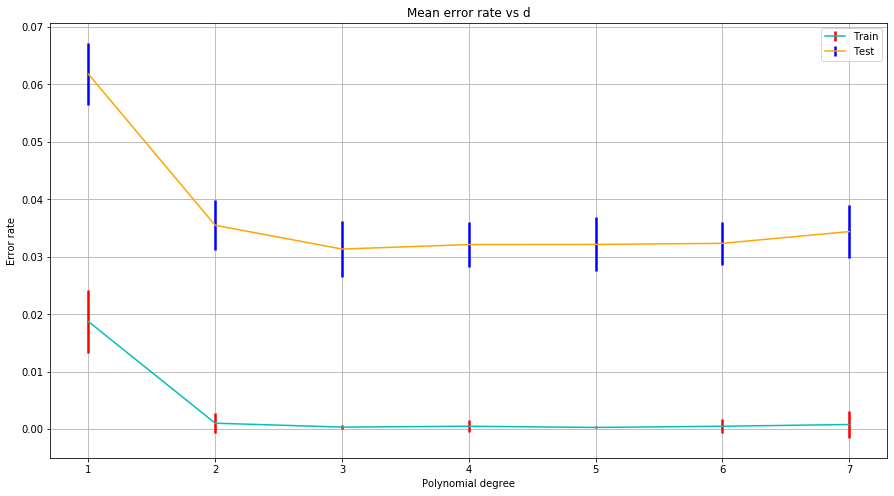

In [175]:
# Training results.
plt.figure(figsize = (15,8))
plt.title('Mean error rate vs d')
plt.errorbar(d_range, mean_d_tr, yerr = std_d_tr, label = 'Train', elinewidth = 2.5, ecolor = 'r', color = 'c')
plt.errorbar(d_range, mean_d_ts, yerr = std_d_ts, label = 'Test', elinewidth = 2.5, ecolor = 'b', color = 'orange')
plt.xlabel('Polynomial degree')
plt.ylabel('Error rate')
plt.legend()
plt.grid()

Temporary observations: (For now, to include later in the report). With higher d's, signs of overfitting, as shown in not only the increase of mean test error rate, but also the increase in standard deviation. While train error remains relatively low as compared to smaller d's, and the difference is attributed to the randomness of the data split. 

### Cross Validation (Polynomial Kernel)

In [141]:
# Auxiliary Functions
def getSubArray(x_train, y_train,n, seed = None):
    """
    Divide the training set into n sub-arrays
    
    Inputs:
    x_train,y train: m x n and m x 1 respectively. 
    n: # of sub-arrays
    """
    res_x = []; res_y = []; sub_arr_indexes = []
    n_samples = x_train.shape[0]; inc = n_samples/n;
    
    # Set seed to get repeatable results
    if seed is not None:
        random.seed(seed)
    
    # Not needed to shuffle because already shuffled before splitting to train and test
    # shuffle the training data before splitting to sub-arrays
#     permute = random.sample(range(n_samples), n_samples)
#     x_train = x_train[permute,:]
#     y_train = y_train[permute,:]
    
    # divide into sub-arrays
    start_idx = 0; end_idx = 0
    for _ in range(n):
        end_idx += inc
        round_end = math.floor(end_idx)
        sub_arr_indexes.append((start_idx, round_end))
        res_x.append(x_train[start_idx:round_end,:])
        res_y.append(y_train[start_idx:round_end,:])
        start_idx = round_end
    
    return res_x, res_y, sub_arr_indexes

def catSubArrays(folds):
    """
    Function to concatenate multiple sub-arrays to a single m x n array
    Input:
    folds: a list of 2d arrays to concatenate
    """
    res = folds[0]
    for idx in range(1,len(folds)):
        res = np.concatenate([res,folds[idx]],axis = 0)
    return res

In [171]:
# Loop 20 times
d_errors = []; best_ds = []; 
num_iter = 20
all_d_errors = np.zeros((len(d_range), num_iter))


for it in range(num_iter):
    # Do 1 cross-validation, and then outer-loop it by 20 times
    start_val = time.time()
    n = 5; n_epochs = 20; num_classes = 10; num_classifiers = 45
    
    # Split for every run
    train_samples, train_labels, test_samples, test_labels = split_train_test(data_samples, data_labels, 0.8, 0.2, seed = it)
    
    # Compute power 1 of kernel mat (later just raise to power d)
    kernel_pow1 = polynomial_kernel(train_samples, train_samples, 1)
    
    # Divide into sub-arrays
    x_train, y_train, sub_idxs = getSubArray(train_samples, train_labels.reshape(-1,1), n)

    # Convert to numpy arrays for ease of slicing
    x_train = np.array(x_train); y_train = np.array(y_train)

    # 1 5-fold cross validation starts here
    d_val_results = np.zeros((len(d_range)))
    for d in d_range:
        print(f"For d = {d}")
        kernel_mat_train = kernel_pow1 ** d
        kernel_mat_idxs = np.arange(kernel_mat_train.shape[0])
        # Iterate through each validation sub-array, the rest become training
        val_indexes = np.arange(n); val_err = []
        
        for val_idx in val_indexes:
            # Get training sub-array indexes
            train_indexes = np.delete(val_indexes, val_idx)

            # Get validation fold index range
            val_range = np.arange(sub_idxs[val_idx][0], sub_idxs[val_idx][1])

            # Slice off the validation samples from the large kernel matrix, and get the train and val based on the folds
            train_kernel_mat = np.delete(kernel_mat_train, val_range, axis = 0)
            val_kernel_mat = train_kernel_mat[:,val_range]
            train_kernel_mat = np.delete(train_kernel_mat, val_range, axis = 1)
            
            # Take one fold as val, rest becomes training
            val_samples = x_train[val_idx]; val_labels = y_train[val_idx].reshape(-1)

            # Training set
            train_mini_samples = catSubArrays(x_train[train_indexes])
            train_mini_labels = catSubArrays(y_train[train_indexes]).reshape(-1)
            
            # Train on training set for some epochs, and then test
            mistake_counters = init_mistake_counters(train_mini_samples, num_classifiers)
            
            mistake_counters, train_rate, train_preds, test_rate, test_preds = train_nepochs(train_mini_samples, train_mini_labels, val_samples, val_labels, mistake_counters
                                                                            , num_classifiers, num_classes, train_kernel_mat, val_kernel_mat, n_epochs)
            
            # Append validation results
            val_err.append(test_rate)

        # Store this d's results
        d_val_results[d-1] = np.mean(val_err)
        
        all_d_errors[d-1, it] = np.mean(val_err)
        
    # Find best d, re-train on whole train_samples and obtain final test performance
    d_star = np.argmin(d_val_results) + 1
    print(f"For iteration {it+1}, best d is {d_star}")
    
    # Re-train and re-evaluate for this new d
    kernel_mat_test = polynomial_kernel(train_samples, test_samples, d_star)
    kernel_mat_train = kernel_pow1 ** d_star
    mistake_counters = init_mistake_counters(train_samples, num_classifiers)
    
    mistake_counters, train_rate, train_preds, test_rate, test_preds = train_nepochs(train_samples, train_labels, test_samples, test_labels, mistake_counters
                                                                            , num_classifiers, num_classes, kernel_mat_train, kernel_mat_test, n_epochs)
    
    print(f"For d = {d_star}, retraining gives a final test error rate of {test_rate} and final train error rate of {train_rate}")
    
    # Append Results of this round of cross validation
    d_errors.append(test_rate); best_ds.append(d_star)
    
    print(f"Time for 1 cross validation across 7 d is {time.time() - start_val}")
    

For d = 1
For epoch 0, train error rate is 0.14115274743740547, and test error rate is 0.09011432414256892
For epoch 1, train error rate is 0.07998655688119644, and test error rate is 0.08406186953597848
For epoch 2, train error rate is 0.06687951604772308, and test error rate is 0.0726294552790854
For epoch 3, train error rate is 0.05242816333389346, and test error rate is 0.07531943510423672
For epoch 4, train error rate is 0.05024365652831457, and test error rate is 0.07868190988567586
For epoch 5, train error rate is 0.04150562930599899, and test error rate is 0.06859448554135844
For epoch 6, train error rate is 0.03562426482944043, and test error rate is 0.08002689979825152
For epoch 7, train error rate is 0.031759368173416236, and test error rate is 0.07330195023537324
For epoch 8, train error rate is 0.0299109393379264, and test error rate is 0.08069939475453934
For epoch 9, train error rate is 0.028734666442614687, and test error rate is 0.06455951580363148
For epoch 10, train 

For epoch 4, train error rate is 0.04907563025210084, and test error rate is 0.06451612903225806
For epoch 5, train error rate is 0.03882352941176471, and test error rate is 0.0846774193548387
For epoch 6, train error rate is 0.03663865546218487, and test error rate is 0.07459677419354839
For epoch 7, train error rate is 0.03394957983193277, and test error rate is 0.06989247311827956
For epoch 8, train error rate is 0.03159663865546219, and test error rate is 0.0846774193548387
For epoch 9, train error rate is 0.031092436974789917, and test error rate is 0.0678763440860215
For epoch 10, train error rate is 0.02689075630252101, and test error rate is 0.0739247311827957
For epoch 11, train error rate is 0.02369747899159664, and test error rate is 0.0739247311827957
For epoch 12, train error rate is 0.021512605042016807, and test error rate is 0.07056451612903226
For epoch 13, train error rate is 0.022016806722689075, and test error rate is 0.06384408602150538
For epoch 14, train error ra

For epoch 7, train error rate is 0.0030252100840336134, and test error rate is 0.03763440860215054
For epoch 8, train error rate is 0.0006722689075630252, and test error rate is 0.03763440860215054
For epoch 9, train error rate is 0.0001680672268907563, and test error rate is 0.03763440860215054
For epoch 10, train error rate is 0.0005042016806722689, and test error rate is 0.03763440860215054
For epoch 11, train error rate is 0.0001680672268907563, and test error rate is 0.03763440860215054
For epoch 12, train error rate is 0.0003361344537815126, and test error rate is 0.03763440860215054
Early stopping at 12 epochs
For d = 3
For epoch 0, train error rate is 0.10031927407158461, and test error rate is 0.07397444519166106
For epoch 1, train error rate is 0.03041505629305999, and test error rate is 0.0484196368527236
For epoch 2, train error rate is 0.016299781549319443, and test error rate is 0.04034969737726967
For epoch 3, train error rate is 0.008738027222315578, and test error rate

For epoch 8, train error rate is 0.0, and test error rate is 0.03698722259583053
For epoch 9, train error rate is 0.0, and test error rate is 0.03698722259583053
For epoch 10, train error rate is 0.0, and test error rate is 0.03698722259583053
For epoch 11, train error rate is 0.0, and test error rate is 0.03698722259583053
Early stopping at 11 epochs
For epoch 0, train error rate is 0.09193277310924369, and test error rate is 0.0625
For epoch 1, train error rate is 0.028067226890756303, and test error rate is 0.04435483870967742
For epoch 2, train error rate is 0.010588235294117647, and test error rate is 0.04233870967741935
For epoch 3, train error rate is 0.005042016806722689, and test error rate is 0.03494623655913978
For epoch 4, train error rate is 0.0025210084033613447, and test error rate is 0.03696236559139785
For epoch 5, train error rate is 0.0010084033613445378, and test error rate is 0.03494623655913978
For epoch 6, train error rate is 0.0006722689075630252, and test error

For epoch 5, train error rate is 0.0008403361344537816, and test error rate is 0.04032258064516129
For epoch 6, train error rate is 0.001176470588235294, and test error rate is 0.04099462365591398
For epoch 7, train error rate is 0.0006722689075630252, and test error rate is 0.04032258064516129
For epoch 8, train error rate is 0.0006722689075630252, and test error rate is 0.0396505376344086
For epoch 9, train error rate is 0.0006722689075630252, and test error rate is 0.0396505376344086
For epoch 10, train error rate is 0.0006722689075630252, and test error rate is 0.04032258064516129
Early stopping at 10 epochs
For epoch 0, train error rate is 0.09226890756302521, and test error rate is 0.06317204301075269
For epoch 1, train error rate is 0.025378151260504203, and test error rate is 0.041666666666666664
For epoch 2, train error rate is 0.009747899159663866, and test error rate is 0.03763440860215054
For epoch 3, train error rate is 0.0033613445378151263, and test error rate is 0.03293

For epoch 6, train error rate is 0.0003360779700890607, and test error rate is 0.03496973772696705
For epoch 7, train error rate is 0.001008233910267182, and test error rate is 0.03496973772696705
For epoch 8, train error rate is 0.0006721559401781214, and test error rate is 0.03564223268325487
For epoch 9, train error rate is 0.0003360779700890607, and test error rate is 0.03496973772696705
Early stopping at 9 epochs
For epoch 0, train error rate is 0.09025210084033614, and test error rate is 0.05981182795698925
For epoch 1, train error rate is 0.02638655462184874, and test error rate is 0.043682795698924734
For epoch 2, train error rate is 0.006554621848739495, and test error rate is 0.04435483870967742
For epoch 3, train error rate is 0.0031932773109243696, and test error rate is 0.04233870967741935
For epoch 4, train error rate is 0.0010084033613445378, and test error rate is 0.041666666666666664
For epoch 5, train error rate is 0.0006722689075630252, and test error rate is 0.04166

For epoch 7, train error rate is 0.03394387497899513, and test error rate is 0.07935440484196368
For epoch 8, train error rate is 0.0315913291883717, and test error rate is 0.06657700067249496
For epoch 9, train error rate is 0.027726432532347505, and test error rate is 0.07397444519166106
For epoch 10, train error rate is 0.022181146025878003, and test error rate is 0.06657700067249496
For epoch 11, train error rate is 0.023357418921189716, and test error rate is 0.06792199058507062
For epoch 12, train error rate is 0.017980171399764745, and test error rate is 0.06859448554135844
For epoch 13, train error rate is 0.0205007561754327, and test error rate is 0.06657700067249496
For epoch 14, train error rate is 0.019156444295076458, and test error rate is 0.06926698049764626
For epoch 15, train error rate is 0.017812132414720214, and test error rate is 0.07128446536650974
For epoch 16, train error rate is 0.014283313728785078, and test error rate is 0.07195696032279758
For epoch 17, trai

For epoch 15, train error rate is 0.0006722689075630252, and test error rate is 0.049059139784946235
Early stopping at 15 epochs
For epoch 0, train error rate is 0.11174592505461267, and test error rate is 0.07599193006052454
For epoch 1, train error rate is 0.03848092757519744, and test error rate is 0.05648957632817754
For epoch 2, train error rate is 0.022013107040833473, and test error rate is 0.0531271015467384
For epoch 3, train error rate is 0.01932448328012099, and test error rate is 0.05716207128446537
For epoch 4, train error rate is 0.009914300117627289, and test error rate is 0.0531271015467384
For epoch 5, train error rate is 0.009074105192404638, and test error rate is 0.0363147276395427
For epoch 6, train error rate is 0.004200974626113258, and test error rate is 0.03496973772696705
For epoch 7, train error rate is 0.003528818685935137, and test error rate is 0.03900470746469401
For epoch 8, train error rate is 0.0038648966560241977, and test error rate is 0.041022192333

For epoch 5, train error rate is 0.0013445378151260505, and test error rate is 0.03293010752688172
For epoch 6, train error rate is 0.0005042016806722689, and test error rate is 0.031586021505376344
For epoch 7, train error rate is 0.0003361344537815126, and test error rate is 0.035618279569892476
For epoch 8, train error rate is 0.0005042016806722689, and test error rate is 0.03225806451612903
For epoch 9, train error rate is 0.0003361344537815126, and test error rate is 0.031586021505376344
Early stopping at 9 epochs
For epoch 0, train error rate is 0.10352941176470588, and test error rate is 0.05241935483870968
For epoch 1, train error rate is 0.033109243697478995, and test error rate is 0.05241935483870968
For epoch 2, train error rate is 0.012605042016806723, and test error rate is 0.05040322580645161
For epoch 3, train error rate is 0.007058823529411765, and test error rate is 0.041666666666666664
For epoch 4, train error rate is 0.0036974789915966387, and test error rate is 0.03

For epoch 4, train error rate is 0.0018487394957983194, and test error rate is 0.04502688172043011
For epoch 5, train error rate is 0.0010084033613445378, and test error rate is 0.04435483870967742
For epoch 6, train error rate is 0.0010084033613445378, and test error rate is 0.04502688172043011
For epoch 7, train error rate is 0.0006722689075630252, and test error rate is 0.04435483870967742
For epoch 8, train error rate is 0.0006722689075630252, and test error rate is 0.04435483870967742
Early stopping at 8 epochs
For epoch 0, train error rate is 0.09763065031087212, and test error rate is 0.06119704102219233
For epoch 1, train error rate is 0.03041505629305999, and test error rate is 0.04640215198386012
For epoch 2, train error rate is 0.01008233910267182, and test error rate is 0.04707464694014795
For epoch 3, train error rate is 0.0026886237607124854, and test error rate is 0.0410221923335575
For epoch 4, train error rate is 0.0011762728953117123, and test error rate is 0.03900470

For epoch 2, train error rate is 0.008906066207360107, and test error rate is 0.03698722259583053
For epoch 3, train error rate is 0.002520584775667955, and test error rate is 0.0363147276395427
For epoch 4, train error rate is 0.001008233910267182, and test error rate is 0.03564223268325487
For epoch 5, train error rate is 0.0008401949252226517, and test error rate is 0.03564223268325487
For epoch 6, train error rate is 0.0006721559401781214, and test error rate is 0.03564223268325487
For epoch 7, train error rate is 0.0006721559401781214, and test error rate is 0.03564223268325487
Early stopping at 7 epochs
For epoch 0, train error rate is 0.09563025210084034, and test error rate is 0.07056451612903226
For epoch 1, train error rate is 0.02621848739495798, and test error rate is 0.053763440860215055
For epoch 2, train error rate is 0.00823529411764706, and test error rate is 0.04435483870967742
For epoch 3, train error rate is 0.0033613445378151263, and test error rate is 0.0470430107

For epoch 6, train error rate is 0.03361344537815126, and test error rate is 0.05510752688172043
For epoch 7, train error rate is 0.03428571428571429, and test error rate is 0.05981182795698925
For epoch 8, train error rate is 0.030252100840336135, and test error rate is 0.05846774193548387
For epoch 9, train error rate is 0.024705882352941175, and test error rate is 0.04771505376344086
For epoch 10, train error rate is 0.021680672268907564, and test error rate is 0.05846774193548387
For epoch 11, train error rate is 0.022857142857142857, and test error rate is 0.05846774193548387
For epoch 12, train error rate is 0.019327731092436976, and test error rate is 0.04973118279569892
For epoch 13, train error rate is 0.01865546218487395, and test error rate is 0.05846774193548387
For epoch 14, train error rate is 0.015126050420168067, and test error rate is 0.05040322580645161
For epoch 15, train error rate is 0.014621848739495798, and test error rate is 0.049059139784946235
For epoch 16, tr

For epoch 10, train error rate is 0.0008401949252226517, and test error rate is 0.03900470746469401
For epoch 11, train error rate is 0.0003360779700890607, and test error rate is 0.03900470746469401
For epoch 12, train error rate is 0.0006721559401781214, and test error rate is 0.03900470746469401
For epoch 13, train error rate is 0.0006721559401781214, and test error rate is 0.03833221250840619
For epoch 14, train error rate is 0.0006721559401781214, and test error rate is 0.03900470746469401
Early stopping at 14 epochs
For epoch 0, train error rate is 0.11495798319327731, and test error rate is 0.05846774193548387
For epoch 1, train error rate is 0.045042016806722686, and test error rate is 0.05913978494623656
For epoch 2, train error rate is 0.02504201680672269, and test error rate is 0.04838709677419355
For epoch 3, train error rate is 0.017142857142857144, and test error rate is 0.04502688172043011
For epoch 4, train error rate is 0.009411764705882352, and test error rate is 0.03

For epoch 3, train error rate is 0.0072256763569148045, and test error rate is 0.04371217215870881
For epoch 4, train error rate is 0.004537052596202319, and test error rate is 0.04371217215870881
For epoch 5, train error rate is 0.0023525457906234245, and test error rate is 0.04303967720242098
For epoch 6, train error rate is 0.0021845068055788945, and test error rate is 0.04303967720242098
For epoch 7, train error rate is 0.0011762728953117123, and test error rate is 0.04303967720242098
For epoch 8, train error rate is 0.0006721559401781214, and test error rate is 0.04371217215870881
For epoch 9, train error rate is 0.0006721559401781214, and test error rate is 0.04303967720242098
For epoch 10, train error rate is 0.0003360779700890607, and test error rate is 0.04303967720242098
For epoch 11, train error rate is 0.0003360779700890607, and test error rate is 0.04303967720242098
Early stopping at 11 epochs
For epoch 0, train error rate is 0.10151260504201681, and test error rate is 0.0

For epoch 3, train error rate is 0.0038648966560241977, and test error rate is 0.0363147276395427
For epoch 4, train error rate is 0.001008233910267182, and test error rate is 0.03564223268325487
For epoch 5, train error rate is 0.0006721559401781214, and test error rate is 0.03496973772696705
For epoch 6, train error rate is 0.0003360779700890607, and test error rate is 0.03496973772696705
For epoch 7, train error rate is 0.0003360779700890607, and test error rate is 0.03496973772696705
Early stopping at 7 epochs
For epoch 0, train error rate is 0.09697478991596639, and test error rate is 0.04099462365591398
For epoch 1, train error rate is 0.023865546218487396, and test error rate is 0.0396505376344086
For epoch 2, train error rate is 0.00957983193277311, and test error rate is 0.034274193548387094
For epoch 3, train error rate is 0.0016806722689075631, and test error rate is 0.031586021505376344
For epoch 4, train error rate is 0.0015126050420168067, and test error rate is 0.0315860

For epoch 3, train error rate is 0.002352941176470588, and test error rate is 0.04435483870967742
For epoch 4, train error rate is 0.0001680672268907563, and test error rate is 0.04233870967741935
For epoch 5, train error rate is 0.0003361344537815126, and test error rate is 0.04233870967741935
For epoch 6, train error rate is 0.0, and test error rate is 0.04233870967741935
For epoch 7, train error rate is 0.0, and test error rate is 0.04233870967741935
Early stopping at 7 epochs
For d = 7
For epoch 0, train error rate is 0.09662241640060494, and test error rate is 0.05985205110961668
For epoch 1, train error rate is 0.024197613846412367, and test error rate is 0.05043712172158709
For epoch 2, train error rate is 0.006049403461603092, and test error rate is 0.04774714189643578
For epoch 3, train error rate is 0.0013443118803562427, and test error rate is 0.04572965702757229
For epoch 4, train error rate is 0.00016803898504453034, and test error rate is 0.04640215198386012
For epoch 5, 

For epoch 6, train error rate is 0.041176470588235294, and test error rate is 0.06317204301075269
For epoch 7, train error rate is 0.03226890756302521, and test error rate is 0.06854838709677419
For epoch 8, train error rate is 0.029747899159663867, and test error rate is 0.06182795698924731
For epoch 9, train error rate is 0.026722689075630253, and test error rate is 0.06384408602150538
For epoch 10, train error rate is 0.028907563025210085, and test error rate is 0.06518817204301075
For epoch 11, train error rate is 0.02369747899159664, and test error rate is 0.061155913978494625
For epoch 12, train error rate is 0.021848739495798318, and test error rate is 0.06317204301075269
For epoch 13, train error rate is 0.02033613445378151, and test error rate is 0.06182795698924731
For epoch 14, train error rate is 0.017142857142857144, and test error rate is 0.06317204301075269
For epoch 15, train error rate is 0.015294117647058824, and test error rate is 0.06451612903225806
For epoch 16, tr

For epoch 11, train error rate is 0.0006721559401781214, and test error rate is 0.03564223268325487
For epoch 12, train error rate is 0.0003360779700890607, and test error rate is 0.03564223268325487
For epoch 13, train error rate is 0.0003360779700890607, and test error rate is 0.03564223268325487
For epoch 14, train error rate is 0.000504116955133591, and test error rate is 0.03698722259583053
Early stopping at 14 epochs
For epoch 0, train error rate is 0.11277310924369748, and test error rate is 0.06451612903225806
For epoch 1, train error rate is 0.04050420168067227, and test error rate is 0.05241935483870968
For epoch 2, train error rate is 0.02638655462184874, and test error rate is 0.038978494623655914
For epoch 3, train error rate is 0.015798319327731094, and test error rate is 0.043010752688172046
For epoch 4, train error rate is 0.010588235294117647, and test error rate is 0.035618279569892476
For epoch 5, train error rate is 0.00773109243697479, and test error rate is 0.0403

For epoch 6, train error rate is 0.002184873949579832, and test error rate is 0.02956989247311828
For epoch 7, train error rate is 0.001176470588235294, and test error rate is 0.02956989247311828
For epoch 8, train error rate is 0.0005042016806722689, and test error rate is 0.02956989247311828
For epoch 9, train error rate is 0.0005042016806722689, and test error rate is 0.02956989247311828
For epoch 10, train error rate is 0.0005042016806722689, and test error rate is 0.02956989247311828
For epoch 11, train error rate is 0.0005042016806722689, and test error rate is 0.02956989247311828
Early stopping at 11 epochs
For epoch 0, train error rate is 0.09880692320618384, and test error rate is 0.05245460659045057
For epoch 1, train error rate is 0.03243152411359435, and test error rate is 0.03698722259583053
For epoch 2, train error rate is 0.014115274743740547, and test error rate is 0.026899798251513115
For epoch 3, train error rate is 0.007897832297092925, and test error rate is 0.02488

For epoch 4, train error rate is 0.0015126050420168067, and test error rate is 0.033602150537634407
For epoch 5, train error rate is 0.0010084033613445378, and test error rate is 0.03293010752688172
For epoch 6, train error rate is 0.0008403361344537816, and test error rate is 0.03293010752688172
For epoch 7, train error rate is 0.0006722689075630252, and test error rate is 0.03293010752688172
For epoch 8, train error rate is 0.0006722689075630252, and test error rate is 0.03293010752688172
Early stopping at 8 epochs
For d = 5
For epoch 0, train error rate is 0.09342967568475886, and test error rate is 0.05245460659045057
For epoch 1, train error rate is 0.02705427659216938, and test error rate is 0.04505716207128446
For epoch 2, train error rate is 0.01008233910267182, and test error rate is 0.04169468728984533
For epoch 3, train error rate is 0.0026886237607124854, and test error rate is 0.03765971755211836
For epoch 4, train error rate is 0.0013443118803562427, and test error rate i

For epoch 4, train error rate is 0.0011762728953117123, and test error rate is 0.023537323470073975
For epoch 5, train error rate is 0.0006721559401781214, and test error rate is 0.023537323470073975
For epoch 6, train error rate is 0.0006721559401781214, and test error rate is 0.022864828513786146
For epoch 7, train error rate is 0.0008401949252226517, and test error rate is 0.022864828513786146
For epoch 8, train error rate is 0.0003360779700890607, and test error rate is 0.023537323470073975
For epoch 9, train error rate is 0.0003360779700890607, and test error rate is 0.023537323470073975
For epoch 10, train error rate is 0.0, and test error rate is 0.023537323470073975
For epoch 11, train error rate is 0.0, and test error rate is 0.023537323470073975
Early stopping at 11 epochs
For epoch 0, train error rate is 0.09193277310924369, and test error rate is 0.06720430107526881
For epoch 1, train error rate is 0.024873949579831932, and test error rate is 0.04435483870967742
For epoch 2

For epoch 2, train error rate is 0.009680021511158914, and test error rate is 0.03924731182795699
For epoch 3, train error rate is 0.005243344985211078, and test error rate is 0.037096774193548385
For epoch 4, train error rate is 0.002016671148158107, and test error rate is 0.03602150537634408
For epoch 5, train error rate is 0.0006722237160527024, and test error rate is 0.03602150537634408
For epoch 6, train error rate is 0.0006722237160527024, and test error rate is 0.03602150537634408
For epoch 7, train error rate is 0.0008066684592632429, and test error rate is 0.03602150537634408
For epoch 8, train error rate is 0.0005377789728421619, and test error rate is 0.03602150537634408
Early stopping at 8 epochs
For d = 4, retraining gives a final test error rate of 0.03602150537634408 and final train error rate of 0.00026888948642108095
Time for 1 cross validation across 7 d is 388.4673867225647
For d = 1
For epoch 0, train error rate is 0.15022685262981011, and test error rate is 0.12911

For epoch 15, train error rate is 0.015798319327731094, and test error rate is 0.06922043010752688
For epoch 16, train error rate is 0.01310924369747899, and test error rate is 0.0625
For epoch 17, train error rate is 0.015294117647058824, and test error rate is 0.06384408602150538
For epoch 18, train error rate is 0.013949579831932773, and test error rate is 0.061155913978494625
For epoch 19, train error rate is 0.012941176470588235, and test error rate is 0.07795698924731183
For epoch 0, train error rate is 0.14638655462184874, and test error rate is 0.10551075268817205
For epoch 1, train error rate is 0.08151260504201681, and test error rate is 0.07325268817204302
For epoch 2, train error rate is 0.05949579831932773, and test error rate is 0.07190860215053764
For epoch 3, train error rate is 0.049747899159663864, and test error rate is 0.07862903225806452
For epoch 4, train error rate is 0.048907563025210085, and test error rate is 0.061155913978494625
For epoch 5, train error rate 

For epoch 15, train error rate is 0.0008403361344537816, and test error rate is 0.04233870967741935
For epoch 16, train error rate is 0.001176470588235294, and test error rate is 0.043010752688172046
For epoch 17, train error rate is 0.0006722689075630252, and test error rate is 0.043010752688172046
For epoch 18, train error rate is 0.0006722689075630252, and test error rate is 0.043010752688172046
For epoch 19, train error rate is 0.0005042016806722689, and test error rate is 0.043010752688172046
For epoch 0, train error rate is 0.11243697478991596, and test error rate is 0.061155913978494625
For epoch 1, train error rate is 0.03630252100840336, and test error rate is 0.05712365591397849
For epoch 2, train error rate is 0.025210084033613446, and test error rate is 0.049059139784946235
For epoch 3, train error rate is 0.01310924369747899, and test error rate is 0.0456989247311828
For epoch 4, train error rate is 0.009243697478991597, and test error rate is 0.04435483870967742
For epoch

For epoch 2, train error rate is 0.01008233910267182, and test error rate is 0.03564223268325487
For epoch 3, train error rate is 0.0036968576709796672, and test error rate is 0.03833221250840619
For epoch 4, train error rate is 0.002016467820534364, and test error rate is 0.03833221250840619
For epoch 5, train error rate is 0.0013443118803562427, and test error rate is 0.0363147276395427
For epoch 6, train error rate is 0.0013443118803562427, and test error rate is 0.03765971755211836
For epoch 7, train error rate is 0.001008233910267182, and test error rate is 0.0363147276395427
For epoch 8, train error rate is 0.0013443118803562427, and test error rate is 0.0363147276395427
Early stopping at 8 epochs
For epoch 0, train error rate is 0.0957983193277311, and test error rate is 0.05309139784946237
For epoch 1, train error rate is 0.028739495798319328, and test error rate is 0.038306451612903226
For epoch 2, train error rate is 0.012436974789915966, and test error rate is 0.032258064516

For epoch 2, train error rate is 0.007563025210084034, and test error rate is 0.04099462365591398
For epoch 3, train error rate is 0.0036974789915966387, and test error rate is 0.041666666666666664
For epoch 4, train error rate is 0.001176470588235294, and test error rate is 0.041666666666666664
For epoch 5, train error rate is 0.002184873949579832, and test error rate is 0.04099462365591398
For epoch 6, train error rate is 0.0005042016806722689, and test error rate is 0.04099462365591398
For epoch 7, train error rate is 0.0003361344537815126, and test error rate is 0.041666666666666664
For epoch 8, train error rate is 0.0008403361344537816, and test error rate is 0.04032258064516129
For epoch 9, train error rate is 0.0005042016806722689, and test error rate is 0.041666666666666664
For epoch 10, train error rate is 0.0010084033613445378, and test error rate is 0.041666666666666664
For epoch 11, train error rate is 0.0006722689075630252, and test error rate is 0.04099462365591398
For ep

For epoch 7, train error rate is 0.0003361344537815126, and test error rate is 0.03763440860215054
For epoch 8, train error rate is 0.0003361344537815126, and test error rate is 0.03763440860215054
For epoch 9, train error rate is 0.0006722689075630252, and test error rate is 0.03763440860215054
Early stopping at 9 epochs
For epoch 0, train error rate is 0.09544614350529322, and test error rate is 0.05043712172158709
For epoch 1, train error rate is 0.0260460426819022, and test error rate is 0.0410221923335575
For epoch 2, train error rate is 0.0073937153419593345, and test error rate is 0.03900470746469401
For epoch 3, train error rate is 0.0016803898504453034, and test error rate is 0.03496973772696705
For epoch 4, train error rate is 0.0003360779700890607, and test error rate is 0.03496973772696705
For epoch 5, train error rate is 0.0003360779700890607, and test error rate is 0.03496973772696705
For epoch 6, train error rate is 0.0003360779700890607, and test error rate is 0.0349697

For epoch 1, train error rate is 0.07729793312048396, and test error rate is 0.07397444519166106
For epoch 2, train error rate is 0.06603932112250042, and test error rate is 0.06590450571620712
For epoch 3, train error rate is 0.05343639724416065, and test error rate is 0.06388702084734364
For epoch 4, train error rate is 0.046546798857334905, and test error rate is 0.05783456624075319
For epoch 5, train error rate is 0.04520248697697866, and test error rate is 0.0726294552790854
For epoch 6, train error rate is 0.04234582423122164, and test error rate is 0.06792199058507062
For epoch 7, train error rate is 0.03730465467988573, and test error rate is 0.05850706119704102
For epoch 8, train error rate is 0.03209544614350529, and test error rate is 0.05581708137188971
For epoch 9, train error rate is 0.03461603091917325, and test error rate is 0.05447209145931405
For epoch 10, train error rate is 0.02638212065199126, and test error rate is 0.05043712172158709
For epoch 11, train error rat

For epoch 7, train error rate is 0.0013445378151260505, and test error rate is 0.038306451612903226
For epoch 8, train error rate is 0.001176470588235294, and test error rate is 0.04233870967741935
For epoch 9, train error rate is 0.001176470588235294, and test error rate is 0.0396505376344086
For epoch 10, train error rate is 0.0008403361344537816, and test error rate is 0.038306451612903226
Early stopping at 10 epochs
For epoch 0, train error rate is 0.11040161317425642, and test error rate is 0.05917955615332885
For epoch 1, train error rate is 0.03730465467988573, and test error rate is 0.04303967720242098
For epoch 2, train error rate is 0.027558393547302974, and test error rate is 0.04572965702757229
For epoch 3, train error rate is 0.014283313728785078, and test error rate is 0.04640215198386012
For epoch 4, train error rate is 0.008906066207360107, and test error rate is 0.0531271015467384
For epoch 5, train error rate is 0.0075617543270038645, and test error rate is 0.04169468

For epoch 9, train error rate is 0.0006721559401781214, and test error rate is 0.03429724277067922
For epoch 10, train error rate is 0.0006721559401781214, and test error rate is 0.03429724277067922
For epoch 11, train error rate is 0.000504116955133591, and test error rate is 0.03496973772696705
Early stopping at 11 epochs
For epoch 0, train error rate is 0.09932773109243698, and test error rate is 0.04771505376344086
For epoch 1, train error rate is 0.033781512605042016, and test error rate is 0.038978494623655914
For epoch 2, train error rate is 0.016134453781512605, and test error rate is 0.0396505376344086
For epoch 3, train error rate is 0.00957983193277311, and test error rate is 0.03763440860215054
For epoch 4, train error rate is 0.004201680672268907, and test error rate is 0.035618279569892476
For epoch 5, train error rate is 0.0016806722689075631, and test error rate is 0.036290322580645164
For epoch 6, train error rate is 0.0016806722689075631, and test error rate is 0.0349

For epoch 10, train error rate is 0.0006722689075630252, and test error rate is 0.038306451612903226
Early stopping at 10 epochs
For d = 5
For epoch 0, train error rate is 0.09326163669971434, and test error rate is 0.04976462676529926
For epoch 1, train error rate is 0.023021340951100654, and test error rate is 0.04169468728984533
For epoch 2, train error rate is 0.008738027222315578, and test error rate is 0.03765971755211836
For epoch 3, train error rate is 0.003528818685935137, and test error rate is 0.03429724277067922
For epoch 4, train error rate is 0.001512350865400773, and test error rate is 0.03429724277067922
For epoch 5, train error rate is 0.0006721559401781214, and test error rate is 0.03496973772696705
For epoch 6, train error rate is 0.001008233910267182, and test error rate is 0.03496973772696705
For epoch 7, train error rate is 0.001008233910267182, and test error rate is 0.03429724277067922
For epoch 8, train error rate is 0.001008233910267182, and test error rate is

For epoch 8, train error rate is 0.0006721559401781214, and test error rate is 0.03564223268325487
Early stopping at 8 epochs
For epoch 0, train error rate is 0.09781512605042017, and test error rate is 0.046370967741935484
For epoch 1, train error rate is 0.02100840336134454, and test error rate is 0.036290322580645164
For epoch 2, train error rate is 0.005378151260504202, and test error rate is 0.035618279569892476
For epoch 3, train error rate is 0.0013445378151260505, and test error rate is 0.035618279569892476
For epoch 4, train error rate is 0.001176470588235294, and test error rate is 0.035618279569892476
For epoch 5, train error rate is 0.0008403361344537816, and test error rate is 0.035618279569892476
For epoch 6, train error rate is 0.0003361344537815126, and test error rate is 0.035618279569892476
For epoch 7, train error rate is 0.0003361344537815126, and test error rate is 0.035618279569892476
For epoch 8, train error rate is 0.0001680672268907563, and test error rate is 0

For d = 1
For epoch 0, train error rate is 0.13728785078138128, and test error rate is 0.0699394754539341
For epoch 1, train error rate is 0.08149890774659721, and test error rate is 0.07935440484196368
For epoch 2, train error rate is 0.06721559401781213, and test error rate is 0.0699394754539341
For epoch 3, train error rate is 0.05377247521424971, and test error rate is 0.0652320107599193
For epoch 4, train error rate is 0.047386993782557556, and test error rate is 0.06590450571620712
For epoch 5, train error rate is 0.03915308351537557, and test error rate is 0.0773369199731002
For epoch 6, train error rate is 0.03243152411359435, and test error rate is 0.0699394754539341
For epoch 7, train error rate is 0.03427995294908419, and test error rate is 0.05985205110961668
For epoch 8, train error rate is 0.029238783397748276, and test error rate is 0.06321452589105582
For epoch 9, train error rate is 0.02638212065199126, and test error rate is 0.05648957632817754
For epoch 10, train err

For epoch 5, train error rate is 0.04319327731092437, and test error rate is 0.07594086021505377
For epoch 6, train error rate is 0.030756302521008402, and test error rate is 0.07258064516129033
For epoch 7, train error rate is 0.031932773109243695, and test error rate is 0.06922043010752688
For epoch 8, train error rate is 0.029075630252100842, and test error rate is 0.07795698924731183
For epoch 9, train error rate is 0.028067226890756303, and test error rate is 0.07661290322580645
For epoch 10, train error rate is 0.024369747899159664, and test error rate is 0.07997311827956989
For epoch 11, train error rate is 0.0226890756302521, and test error rate is 0.07325268817204302
For epoch 12, train error rate is 0.022184873949579832, and test error rate is 0.07325268817204302
For epoch 13, train error rate is 0.020504201680672268, and test error rate is 0.07459677419354839
For epoch 14, train error rate is 0.018487394957983194, and test error rate is 0.06989247311827956
For epoch 15, trai

For epoch 6, train error rate is 0.0058823529411764705, and test error rate is 0.038978494623655914
For epoch 7, train error rate is 0.0030252100840336134, and test error rate is 0.04032258064516129
For epoch 8, train error rate is 0.0025210084033613447, and test error rate is 0.038978494623655914
For epoch 9, train error rate is 0.0006722689075630252, and test error rate is 0.03763440860215054
For epoch 10, train error rate is 0.0005042016806722689, and test error rate is 0.03763440860215054
For epoch 11, train error rate is 0.0006722689075630252, and test error rate is 0.03763440860215054
For epoch 12, train error rate is 0.0006722689075630252, and test error rate is 0.03763440860215054
Early stopping at 12 epochs
For d = 3
For epoch 0, train error rate is 0.09662241640060494, and test error rate is 0.05043712172158709
For epoch 1, train error rate is 0.031423290203327174, and test error rate is 0.04505716207128446
For epoch 2, train error rate is 0.013947235758696018, and test error

For epoch 2, train error rate is 0.011596638655462186, and test error rate is 0.043010752688172046
For epoch 3, train error rate is 0.004201680672268907, and test error rate is 0.043010752688172046
For epoch 4, train error rate is 0.0016806722689075631, and test error rate is 0.04099462365591398
For epoch 5, train error rate is 0.0005042016806722689, and test error rate is 0.04233870967741935
For epoch 6, train error rate is 0.0005042016806722689, and test error rate is 0.04099462365591398
For epoch 7, train error rate is 0.0003361344537815126, and test error rate is 0.04233870967741935
For epoch 8, train error rate is 0.0006722689075630252, and test error rate is 0.043010752688172046
Early stopping at 8 epochs
For epoch 0, train error rate is 0.09426987060998152, and test error rate is 0.05985205110961668
For epoch 1, train error rate is 0.023861535876323305, and test error rate is 0.05514458641560188
For epoch 2, train error rate is 0.01025037808771635, and test error rate is 0.04505

For epoch 8, train error rate is 0.0003361344537815126, and test error rate is 0.03293010752688172
Early stopping at 8 epochs
For d = 6
For epoch 0, train error rate is 0.09426987060998152, and test error rate is 0.04640215198386012
For epoch 1, train error rate is 0.02486976978659049, and test error rate is 0.04236718224613315
For epoch 2, train error rate is 0.009914300117627289, and test error rate is 0.03698722259583053
For epoch 3, train error rate is 0.002520584775667955, and test error rate is 0.0363147276395427
For epoch 4, train error rate is 0.0013443118803562427, and test error rate is 0.0363147276395427
For epoch 5, train error rate is 0.001008233910267182, and test error rate is 0.0363147276395427
For epoch 6, train error rate is 0.0003360779700890607, and test error rate is 0.0363147276395427
For epoch 7, train error rate is 0.0003360779700890607, and test error rate is 0.0363147276395427
For epoch 8, train error rate is 0.00016803898504453034, and test error rate is 0.03

For epoch 0, train error rate is 0.09277310924369749, and test error rate is 0.056451612903225805
For epoch 1, train error rate is 0.028907563025210085, and test error rate is 0.04838709677419355
For epoch 2, train error rate is 0.006386554621848739, and test error rate is 0.043682795698924734
For epoch 3, train error rate is 0.002352941176470588, and test error rate is 0.043682795698924734
For epoch 4, train error rate is 0.0020168067226890756, and test error rate is 0.043682795698924734
For epoch 5, train error rate is 0.0005042016806722689, and test error rate is 0.04233870967741935
For epoch 6, train error rate is 0.0001680672268907563, and test error rate is 0.04233870967741935
For epoch 7, train error rate is 0.0006722689075630252, and test error rate is 0.04233870967741935
For epoch 8, train error rate is 0.0003361344537815126, and test error rate is 0.04233870967741935
Early stopping at 8 epochs
For iteration 7, best d is 3
For epoch 0, train error rate is 0.0903468674374832, a

For epoch 1, train error rate is 0.07882352941176471, and test error rate is 0.07056451612903226
For epoch 2, train error rate is 0.06403361344537815, and test error rate is 0.06653225806451613
For epoch 3, train error rate is 0.05277310924369748, and test error rate is 0.07056451612903226
For epoch 4, train error rate is 0.04672268907563025, and test error rate is 0.06653225806451613
For epoch 5, train error rate is 0.045042016806722686, and test error rate is 0.05577956989247312
For epoch 6, train error rate is 0.03798319327731092, and test error rate is 0.056451612903225805
For epoch 7, train error rate is 0.034453781512605045, and test error rate is 0.04838709677419355
For epoch 8, train error rate is 0.029411764705882353, and test error rate is 0.05712365591397849
For epoch 9, train error rate is 0.028739495798319328, and test error rate is 0.05913978494623656
For epoch 10, train error rate is 0.030084033613445377, and test error rate is 0.06922043010752688
For epoch 11, train err

For epoch 0, train error rate is 0.11109243697478992, and test error rate is 0.06182795698924731
For epoch 1, train error rate is 0.038991596638655465, and test error rate is 0.051075268817204304
For epoch 2, train error rate is 0.022857142857142857, and test error rate is 0.05712365591397849
For epoch 3, train error rate is 0.0173109243697479, and test error rate is 0.04099462365591398
For epoch 4, train error rate is 0.009747899159663866, and test error rate is 0.0396505376344086
For epoch 5, train error rate is 0.0067226890756302525, and test error rate is 0.03696236559139785
For epoch 6, train error rate is 0.004201680672268907, and test error rate is 0.035618279569892476
For epoch 7, train error rate is 0.0030252100840336134, and test error rate is 0.04032258064516129
For epoch 8, train error rate is 0.0030252100840336134, and test error rate is 0.036290322580645164
For epoch 9, train error rate is 0.002352941176470588, and test error rate is 0.03696236559139785
For epoch 10, trai

For epoch 5, train error rate is 0.002857142857142857, and test error rate is 0.0396505376344086
For epoch 6, train error rate is 0.0016806722689075631, and test error rate is 0.03696236559139785
For epoch 7, train error rate is 0.001176470588235294, and test error rate is 0.038306451612903226
For epoch 8, train error rate is 0.0018487394957983194, and test error rate is 0.0396505376344086
For epoch 9, train error rate is 0.0010084033613445378, and test error rate is 0.038306451612903226
For epoch 10, train error rate is 0.0008403361344537816, and test error rate is 0.03763440860215054
For epoch 11, train error rate is 0.0006722689075630252, and test error rate is 0.03763440860215054
For epoch 12, train error rate is 0.0006722689075630252, and test error rate is 0.03763440860215054
Early stopping at 12 epochs
For d = 4
For epoch 0, train error rate is 0.09645437741556041, and test error rate is 0.04909213180901143
For epoch 1, train error rate is 0.02486976978659049, and test error rat

For epoch 0, train error rate is 0.09410183162493699, and test error rate is 0.06926698049764626
For epoch 1, train error rate is 0.02621408166694673, and test error rate is 0.05514458641560188
For epoch 2, train error rate is 0.008233910267181985, and test error rate is 0.04438466711499664
For epoch 3, train error rate is 0.004032935641068728, and test error rate is 0.04169468728984533
For epoch 4, train error rate is 0.001008233910267182, and test error rate is 0.04303967720242098
For epoch 5, train error rate is 0.0003360779700890607, and test error rate is 0.04236718224613315
For epoch 6, train error rate is 0.0003360779700890607, and test error rate is 0.04236718224613315
For epoch 7, train error rate is 0.0, and test error rate is 0.04236718224613315
For epoch 8, train error rate is 0.0, and test error rate is 0.04236718224613315
Early stopping at 8 epochs
For epoch 0, train error rate is 0.0988235294117647, and test error rate is 0.051075268817204304
For epoch 1, train error rat

For epoch 3, train error rate is 0.0026886237607124854, and test error rate is 0.0363147276395427
For epoch 4, train error rate is 0.001512350865400773, and test error rate is 0.0363147276395427
For epoch 5, train error rate is 0.0008401949252226517, and test error rate is 0.03698722259583053
For epoch 6, train error rate is 0.0006721559401781214, and test error rate is 0.03698722259583053
For epoch 7, train error rate is 0.0006721559401781214, and test error rate is 0.03765971755211836
For epoch 8, train error rate is 0.0003360779700890607, and test error rate is 0.03765971755211836
Early stopping at 8 epochs
For epoch 0, train error rate is 0.09663865546218488, and test error rate is 0.05712365591397849
For epoch 1, train error rate is 0.02504201680672269, and test error rate is 0.043682795698924734
For epoch 2, train error rate is 0.00823529411764706, and test error rate is 0.038306451612903226
For epoch 3, train error rate is 0.002352941176470588, and test error rate is 0.036962365

For epoch 5, train error rate is 0.045714285714285714, and test error rate is 0.0678763440860215
For epoch 6, train error rate is 0.03949579831932773, and test error rate is 0.08266129032258064
For epoch 7, train error rate is 0.03394957983193277, and test error rate is 0.053763440860215055
For epoch 8, train error rate is 0.02991596638655462, and test error rate is 0.053763440860215055
For epoch 9, train error rate is 0.02453781512605042, and test error rate is 0.05913978494623656
For epoch 10, train error rate is 0.031092436974789917, and test error rate is 0.061155913978494625
For epoch 11, train error rate is 0.025546218487394957, and test error rate is 0.06720430107526881
For epoch 12, train error rate is 0.020840336134453782, and test error rate is 0.0625
For epoch 13, train error rate is 0.02033613445378151, and test error rate is 0.05241935483870968
For epoch 14, train error rate is 0.01781512605042017, and test error rate is 0.06384408602150538
For epoch 15, train error rate i

For epoch 9, train error rate is 0.000504116955133591, and test error rate is 0.03564223268325487
For epoch 10, train error rate is 0.0003360779700890607, and test error rate is 0.03698722259583053
For epoch 11, train error rate is 0.001008233910267182, and test error rate is 0.03564223268325487
For epoch 12, train error rate is 0.0003360779700890607, and test error rate is 0.0363147276395427
For epoch 13, train error rate is 0.0003360779700890607, and test error rate is 0.03833221250840619
For epoch 14, train error rate is 0.0006721559401781214, and test error rate is 0.03564223268325487
For epoch 15, train error rate is 0.000504116955133591, and test error rate is 0.03564223268325487
Early stopping at 15 epochs
For epoch 0, train error rate is 0.11394957983193277, and test error rate is 0.053763440860215055
For epoch 1, train error rate is 0.04016806722689076, and test error rate is 0.0456989247311828
For epoch 2, train error rate is 0.028403361344537813, and test error rate is 0.063

For epoch 8, train error rate is 0.0006722689075630252, and test error rate is 0.027553763440860215
For epoch 9, train error rate is 0.0003361344537815126, and test error rate is 0.027553763440860215
For epoch 10, train error rate is 0.0001680672268907563, and test error rate is 0.027553763440860215
Early stopping at 10 epochs
For epoch 0, train error rate is 0.09847084523609477, and test error rate is 0.05581708137188971
For epoch 1, train error rate is 0.028902705427659218, and test error rate is 0.04034969737726967
For epoch 2, train error rate is 0.0166358595194085, and test error rate is 0.0410221923335575
For epoch 3, train error rate is 0.0072256763569148045, and test error rate is 0.0410221923335575
For epoch 4, train error rate is 0.00487313056629138, and test error rate is 0.04169468728984533
For epoch 5, train error rate is 0.0023525457906234245, and test error rate is 0.04034969737726967
For epoch 6, train error rate is 0.0006721559401781214, and test error rate is 0.039004

For epoch 7, train error rate is 0.0001680672268907563, and test error rate is 0.0396505376344086
For epoch 8, train error rate is 0.0, and test error rate is 0.0396505376344086
For epoch 9, train error rate is 0.0, and test error rate is 0.0396505376344086
For epoch 10, train error rate is 0.0, and test error rate is 0.0396505376344086
Early stopping at 10 epochs
For d = 5
For epoch 0, train error rate is 0.09897496219122837, and test error rate is 0.04640215198386012
For epoch 1, train error rate is 0.02100487313056629, and test error rate is 0.04976462676529926
For epoch 2, train error rate is 0.0075617543270038645, and test error rate is 0.03496973772696705
For epoch 3, train error rate is 0.0031927407158460763, and test error rate is 0.03765971755211836
For epoch 4, train error rate is 0.001512350865400773, and test error rate is 0.03698722259583053
For epoch 5, train error rate is 0.0008401949252226517, and test error rate is 0.0363147276395427
For epoch 6, train error rate is 0.

For epoch 3, train error rate is 0.0030252100840336134, and test error rate is 0.04771505376344086
For epoch 4, train error rate is 0.0013445378151260505, and test error rate is 0.04771505376344086
For epoch 5, train error rate is 0.0003361344537815126, and test error rate is 0.046370967741935484
For epoch 6, train error rate is 0.0003361344537815126, and test error rate is 0.04704301075268817
For epoch 7, train error rate is 0.0006722689075630252, and test error rate is 0.046370967741935484
For epoch 8, train error rate is 0.0001680672268907563, and test error rate is 0.04704301075268817
For epoch 9, train error rate is 0.0005042016806722689, and test error rate is 0.0456989247311828
For epoch 10, train error rate is 0.0001680672268907563, and test error rate is 0.046370967741935484
For epoch 11, train error rate is 0.0001680672268907563, and test error rate is 0.046370967741935484
Early stopping at 11 epochs
For epoch 0, train error rate is 0.09210084033613446, and test error rate is

For epoch 11, train error rate is 0.02184506805578894, and test error rate is 0.07666442501681238
For epoch 12, train error rate is 0.018316249369853807, and test error rate is 0.0605245460659045
For epoch 13, train error rate is 0.018652327339942865, and test error rate is 0.07128446536650974
For epoch 14, train error rate is 0.014283313728785078, and test error rate is 0.06926698049764626
For epoch 15, train error rate is 0.016131742564274913, and test error rate is 0.06859448554135844
For epoch 16, train error rate is 0.014451352713829609, and test error rate is 0.06388702084734364
For epoch 17, train error rate is 0.013443118803562427, and test error rate is 0.06590450571620712
For epoch 18, train error rate is 0.014451352713829609, and test error rate is 0.06388702084734364
For epoch 19, train error rate is 0.013443118803562427, and test error rate is 0.06455951580363148
For epoch 0, train error rate is 0.14319327731092438, and test error rate is 0.08736559139784947
For epoch 1, t

For epoch 15, train error rate is 0.015126050420168067, and test error rate is 0.06720430107526881
For epoch 16, train error rate is 0.014621848739495798, and test error rate is 0.06653225806451613
For epoch 17, train error rate is 0.018823529411764704, and test error rate is 0.06989247311827956
For epoch 18, train error rate is 0.015294117647058824, and test error rate is 0.05309139784946237
For epoch 19, train error rate is 0.013277310924369748, and test error rate is 0.06182795698924731
For d = 2
For epoch 0, train error rate is 0.10888926230885565, and test error rate is 0.0699394754539341
For epoch 1, train error rate is 0.04200974626113258, and test error rate is 0.05379959650302623
For epoch 2, train error rate is 0.024365652831456898, and test error rate is 0.0484196368527236
For epoch 3, train error rate is 0.01579566459418585, and test error rate is 0.04303967720242098
For epoch 4, train error rate is 0.011090573012939002, and test error rate is 0.04707464694014795
For epoch 

For epoch 4, train error rate is 0.00487313056629138, and test error rate is 0.04303967720242098
For epoch 5, train error rate is 0.0028566627457570154, and test error rate is 0.03900470746469401
For epoch 6, train error rate is 0.002016467820534364, and test error rate is 0.04505716207128446
For epoch 7, train error rate is 0.0013443118803562427, and test error rate is 0.0410221923335575
For epoch 8, train error rate is 0.001008233910267182, and test error rate is 0.04034969737726967
For epoch 9, train error rate is 0.0006721559401781214, and test error rate is 0.04034969737726967
For epoch 10, train error rate is 0.0006721559401781214, and test error rate is 0.04034969737726967
Early stopping at 10 epochs
For epoch 0, train error rate is 0.09915966386554621, and test error rate is 0.0678763440860215
For epoch 1, train error rate is 0.034453781512605045, and test error rate is 0.04099462365591398
For epoch 2, train error rate is 0.018487394957983194, and test error rate is 0.039650537

For epoch 7, train error rate is 0.0006721559401781214, and test error rate is 0.03698722259583053
For epoch 8, train error rate is 0.0006721559401781214, and test error rate is 0.03698722259583053
For epoch 9, train error rate is 0.0006721559401781214, and test error rate is 0.03698722259583053
For epoch 10, train error rate is 0.0006721559401781214, and test error rate is 0.03765971755211836
Early stopping at 10 epochs
For epoch 0, train error rate is 0.09512605042016807, and test error rate is 0.04973118279569892
For epoch 1, train error rate is 0.02957983193277311, and test error rate is 0.038306451612903226
For epoch 2, train error rate is 0.011932773109243698, and test error rate is 0.03293010752688172
For epoch 3, train error rate is 0.006554621848739495, and test error rate is 0.035618279569892476
For epoch 4, train error rate is 0.002857142857142857, and test error rate is 0.03696236559139785
For epoch 5, train error rate is 0.0016806722689075631, and test error rate is 0.0369

For epoch 3, train error rate is 0.0038648966560241977, and test error rate is 0.04236718224613315
For epoch 4, train error rate is 0.001512350865400773, and test error rate is 0.04169468728984533
For epoch 5, train error rate is 0.0006721559401781214, and test error rate is 0.0410221923335575
For epoch 6, train error rate is 0.000504116955133591, and test error rate is 0.04976462676529926
For epoch 7, train error rate is 0.0006721559401781214, and test error rate is 0.04976462676529926
For epoch 8, train error rate is 0.0006721559401781214, and test error rate is 0.05178211163416274
Early stopping at 8 epochs
For epoch 0, train error rate is 0.09277310924369749, and test error rate is 0.06048387096774194
For epoch 1, train error rate is 0.02588235294117647, and test error rate is 0.038306451612903226
For epoch 2, train error rate is 0.007563025210084034, and test error rate is 0.04233870967741935
For epoch 3, train error rate is 0.002857142857142857, and test error rate is 0.036290322

For epoch 6, train error rate is 0.0010084033613445378, and test error rate is 0.04099462365591398
For epoch 7, train error rate is 0.0006722689075630252, and test error rate is 0.0396505376344086
For epoch 8, train error rate is 0.0003361344537815126, and test error rate is 0.0396505376344086
Early stopping at 8 epochs
For epoch 0, train error rate is 0.09865546218487395, and test error rate is 0.043010752688172046
For epoch 1, train error rate is 0.024201680672268907, and test error rate is 0.04032258064516129
For epoch 2, train error rate is 0.006554621848739495, and test error rate is 0.036290322580645164
For epoch 3, train error rate is 0.002689075630252101, and test error rate is 0.03494623655913978
For epoch 4, train error rate is 0.0003361344537815126, and test error rate is 0.03494623655913978
For epoch 5, train error rate is 0.0, and test error rate is 0.03494623655913978
For epoch 6, train error rate is 0.0, and test error rate is 0.03494623655913978
For epoch 7, train error

For epoch 0, train error rate is 0.14201680672268907, and test error rate is 0.10147849462365591
For epoch 1, train error rate is 0.08252100840336135, and test error rate is 0.08602150537634409
For epoch 2, train error rate is 0.06050420168067227, and test error rate is 0.07661290322580645
For epoch 3, train error rate is 0.05546218487394958, and test error rate is 0.08266129032258064
For epoch 4, train error rate is 0.04739495798319328, and test error rate is 0.08198924731182795
For epoch 5, train error rate is 0.04151260504201681, and test error rate is 0.09206989247311828
For epoch 6, train error rate is 0.03663865546218487, and test error rate is 0.06720430107526881
For epoch 7, train error rate is 0.03260504201680672, and test error rate is 0.0907258064516129
For epoch 8, train error rate is 0.03210084033613445, and test error rate is 0.08064516129032258
For epoch 9, train error rate is 0.02689075630252101, and test error rate is 0.08131720430107527
For epoch 10, train error rate 

For epoch 10, train error rate is 0.001512350865400773, and test error rate is 0.03900470746469401
For epoch 11, train error rate is 0.0006721559401781214, and test error rate is 0.03900470746469401
For epoch 12, train error rate is 0.0006721559401781214, and test error rate is 0.03900470746469401
For epoch 13, train error rate is 0.001008233910267182, and test error rate is 0.04034969737726967
For epoch 14, train error rate is 0.001008233910267182, and test error rate is 0.03967720242098184
Early stopping at 14 epochs
For epoch 0, train error rate is 0.11126050420168067, and test error rate is 0.06720430107526881
For epoch 1, train error rate is 0.038991596638655465, and test error rate is 0.05443548387096774
For epoch 2, train error rate is 0.019663865546218486, and test error rate is 0.046370967741935484
For epoch 3, train error rate is 0.01495798319327731, and test error rate is 0.043682795698924734
For epoch 4, train error rate is 0.00907563025210084, and test error rate is 0.0409

For epoch 9, train error rate is 0.0006722689075630252, and test error rate is 0.034274193548387094
Early stopping at 9 epochs
For epoch 0, train error rate is 0.09949579831932773, and test error rate is 0.05846774193548387
For epoch 1, train error rate is 0.03092436974789916, and test error rate is 0.0456989247311828
For epoch 2, train error rate is 0.015630252100840337, and test error rate is 0.03225806451612903
For epoch 3, train error rate is 0.008739495798319327, and test error rate is 0.034274193548387094
For epoch 4, train error rate is 0.004873949579831933, and test error rate is 0.03225806451612903
For epoch 5, train error rate is 0.0020168067226890756, and test error rate is 0.033602150537634407
For epoch 6, train error rate is 0.0020168067226890756, and test error rate is 0.033602150537634407
For epoch 7, train error rate is 0.0008403361344537816, and test error rate is 0.03293010752688172
For epoch 8, train error rate is 0.0006722689075630252, and test error rate is 0.03293

For epoch 2, train error rate is 0.009242144177449169, and test error rate is 0.03362474781439139
For epoch 3, train error rate is 0.0031927407158460763, and test error rate is 0.03833221250840619
For epoch 4, train error rate is 0.002016467820534364, and test error rate is 0.04034969737726967
For epoch 5, train error rate is 0.0018484288354898336, and test error rate is 0.03362474781439139
For epoch 6, train error rate is 0.0013443118803562427, and test error rate is 0.03362474781439139
For epoch 7, train error rate is 0.0006721559401781214, and test error rate is 0.03362474781439139
For epoch 8, train error rate is 0.0006721559401781214, and test error rate is 0.03362474781439139
For epoch 9, train error rate is 0.000504116955133591, and test error rate is 0.03362474781439139
For epoch 10, train error rate is 0.0003360779700890607, and test error rate is 0.03362474781439139
Early stopping at 10 epochs
For epoch 0, train error rate is 0.09226890756302521, and test error rate is 0.0510

For epoch 8, train error rate is 0.0003360779700890607, and test error rate is 0.03765971755211836
Early stopping at 8 epochs
For epoch 0, train error rate is 0.09210084033613446, and test error rate is 0.05913978494623656
For epoch 1, train error rate is 0.02621848739495798, and test error rate is 0.043682795698924734
For epoch 2, train error rate is 0.00773109243697479, and test error rate is 0.04233870967741935
For epoch 3, train error rate is 0.002352941176470588, and test error rate is 0.04032258064516129
For epoch 4, train error rate is 0.0008403361344537816, and test error rate is 0.038978494623655914
For epoch 5, train error rate is 0.0005042016806722689, and test error rate is 0.038978494623655914
For epoch 6, train error rate is 0.0006722689075630252, and test error rate is 0.04032258064516129
For epoch 7, train error rate is 0.0, and test error rate is 0.04032258064516129
For epoch 8, train error rate is 0.0, and test error rate is 0.04032258064516129
For epoch 9, train erro

For epoch 6, train error rate is 0.03210084033613445, and test error rate is 0.06384408602150538
For epoch 7, train error rate is 0.03210084033613445, and test error rate is 0.05174731182795699
For epoch 8, train error rate is 0.02957983193277311, and test error rate is 0.06586021505376344
For epoch 9, train error rate is 0.025210084033613446, and test error rate is 0.05779569892473118
For epoch 10, train error rate is 0.02638655462184874, and test error rate is 0.06182795698924731
For epoch 11, train error rate is 0.020672268907563025, and test error rate is 0.05443548387096774
For epoch 12, train error rate is 0.016134453781512605, and test error rate is 0.05846774193548387
For epoch 13, train error rate is 0.019831932773109243, and test error rate is 0.06989247311827956
For epoch 14, train error rate is 0.015630252100840337, and test error rate is 0.05309139784946237
For epoch 15, train error rate is 0.012100840336134453, and test error rate is 0.06451612903225806
For epoch 16, trai

For epoch 10, train error rate is 0.000504116955133591, and test error rate is 0.03295225285810356
For epoch 11, train error rate is 0.000504116955133591, and test error rate is 0.03362474781439139
For epoch 12, train error rate is 0.0006721559401781214, and test error rate is 0.03295225285810356
For epoch 13, train error rate is 0.0003360779700890607, and test error rate is 0.03295225285810356
Early stopping at 13 epochs
For epoch 0, train error rate is 0.10621848739495798, and test error rate is 0.06451612903225806
For epoch 1, train error rate is 0.036470588235294116, and test error rate is 0.061155913978494625
For epoch 2, train error rate is 0.021680672268907564, and test error rate is 0.053763440860215055
For epoch 3, train error rate is 0.013949579831932773, and test error rate is 0.043682795698924734
For epoch 4, train error rate is 0.009243697478991597, and test error rate is 0.04233870967741935
For epoch 5, train error rate is 0.005546218487394958, and test error rate is 0.04

For epoch 7, train error rate is 0.0, and test error rate is 0.03763440860215054
For epoch 8, train error rate is 0.0, and test error rate is 0.03763440860215054
For epoch 9, train error rate is 0.0, and test error rate is 0.03763440860215054
Early stopping at 9 epochs
For epoch 0, train error rate is 0.096958494370694, and test error rate is 0.0531271015467384
For epoch 1, train error rate is 0.03075113426314905, and test error rate is 0.0410221923335575
For epoch 2, train error rate is 0.014787430683918669, and test error rate is 0.03765971755211836
For epoch 3, train error rate is 0.005377247521424971, and test error rate is 0.03160726294552791
For epoch 4, train error rate is 0.003528818685935137, and test error rate is 0.03429724277067922
For epoch 5, train error rate is 0.002520584775667955, and test error rate is 0.03026227303295225
For epoch 6, train error rate is 0.0018484288354898336, and test error rate is 0.025554808338937456
For epoch 7, train error rate is 0.0011762728953

For epoch 9, train error rate is 0.0006722689075630252, and test error rate is 0.035618279569892476
For epoch 10, train error rate is 0.0003361344537815126, and test error rate is 0.035618279569892476
Early stopping at 10 epochs
For epoch 0, train error rate is 0.09428571428571429, and test error rate is 0.06720430107526881
For epoch 1, train error rate is 0.024705882352941175, and test error rate is 0.04435483870967742
For epoch 2, train error rate is 0.00957983193277311, and test error rate is 0.03763440860215054
For epoch 3, train error rate is 0.0033613445378151263, and test error rate is 0.034274193548387094
For epoch 4, train error rate is 0.002352941176470588, and test error rate is 0.035618279569892476
For epoch 5, train error rate is 0.0003361344537815126, and test error rate is 0.03494623655913978
For epoch 6, train error rate is 0.0006722689075630252, and test error rate is 0.035618279569892476
For epoch 7, train error rate is 0.0005042016806722689, and test error rate is 0.

For epoch 7, train error rate is 0.0003360779700890607, and test error rate is 0.03429724277067922
Early stopping at 7 epochs
For epoch 0, train error rate is 0.09512605042016807, and test error rate is 0.05981182795698925
For epoch 1, train error rate is 0.023529411764705882, and test error rate is 0.04099462365591398
For epoch 2, train error rate is 0.007899159663865547, and test error rate is 0.041666666666666664
For epoch 3, train error rate is 0.0015126050420168067, and test error rate is 0.041666666666666664
For epoch 4, train error rate is 0.0003361344537815126, and test error rate is 0.04032258064516129
For epoch 5, train error rate is 0.0003361344537815126, and test error rate is 0.04032258064516129
For epoch 6, train error rate is 0.0003361344537815126, and test error rate is 0.04032258064516129
For epoch 7, train error rate is 0.0003361344537815126, and test error rate is 0.04099462365591398
Early stopping at 7 epochs
For epoch 0, train error rate is 0.09394957983193278, and

For epoch 7, train error rate is 0.033271719038817, and test error rate is 0.07397444519166106
For epoch 8, train error rate is 0.027558393547302974, and test error rate is 0.06119704102219233
For epoch 9, train error rate is 0.029238783397748276, and test error rate is 0.06321452589105582
For epoch 10, train error rate is 0.029238783397748276, and test error rate is 0.07599193006052454
For epoch 11, train error rate is 0.02486976978659049, and test error rate is 0.06724949562878278
For epoch 12, train error rate is 0.02100487313056629, and test error rate is 0.06657700067249496
For epoch 13, train error rate is 0.022853301966056123, and test error rate is 0.07531943510423672
For epoch 14, train error rate is 0.0205007561754327, and test error rate is 0.06859448554135844
For epoch 15, train error rate is 0.018820366324987396, and test error rate is 0.06657700067249496
For epoch 16, train error rate is 0.016971937489497563, and test error rate is 0.06321452589105582
For epoch 17, train 

For epoch 11, train error rate is 0.029243697478991595, and test error rate is 0.06586021505376344
For epoch 12, train error rate is 0.025378151260504203, and test error rate is 0.05779569892473118
For epoch 13, train error rate is 0.02453781512605042, and test error rate is 0.06384408602150538
For epoch 14, train error rate is 0.0226890756302521, and test error rate is 0.06720430107526881
For epoch 15, train error rate is 0.01899159663865546, and test error rate is 0.05913978494623656
For epoch 16, train error rate is 0.019663865546218486, and test error rate is 0.05712365591397849
For epoch 17, train error rate is 0.017478991596638654, and test error rate is 0.051075268817204304
For epoch 18, train error rate is 0.010924369747899159, and test error rate is 0.05577956989247312
For epoch 19, train error rate is 0.012773109243697478, and test error rate is 0.05309139784946237
For d = 2
For epoch 0, train error rate is 0.11056965215930095, and test error rate is 0.07128446536650974
For e

For epoch 11, train error rate is 0.0010084033613445378, and test error rate is 0.033602150537634407
For epoch 12, train error rate is 0.0008403361344537816, and test error rate is 0.038978494623655914
Early stopping at 12 epochs
For d = 3
For epoch 0, train error rate is 0.09628633843051589, and test error rate is 0.06119704102219233
For epoch 1, train error rate is 0.031759368173416236, and test error rate is 0.04640215198386012
For epoch 2, train error rate is 0.013443118803562427, and test error rate is 0.03967720242098184
For epoch 3, train error rate is 0.00504116955133591, and test error rate is 0.04236718224613315
For epoch 4, train error rate is 0.0026886237607124854, and test error rate is 0.04169468728984533
For epoch 5, train error rate is 0.0018484288354898336, and test error rate is 0.0410221923335575
For epoch 6, train error rate is 0.0006721559401781214, and test error rate is 0.04034969737726967
For epoch 7, train error rate is 0.0006721559401781214, and test error rat

For epoch 5, train error rate is 0.0011762728953117123, and test error rate is 0.03093476798924008
For epoch 6, train error rate is 0.000504116955133591, and test error rate is 0.03160726294552791
For epoch 7, train error rate is 0.0008401949252226517, and test error rate is 0.03160726294552791
For epoch 8, train error rate is 0.0006721559401781214, and test error rate is 0.03160726294552791
For epoch 9, train error rate is 0.0011762728953117123, and test error rate is 0.03160726294552791
Early stopping at 9 epochs
For epoch 0, train error rate is 0.09294117647058824, and test error rate is 0.06922043010752688
For epoch 1, train error rate is 0.024705882352941175, and test error rate is 0.05846774193548387
For epoch 2, train error rate is 0.010924369747899159, and test error rate is 0.04704301075268817
For epoch 3, train error rate is 0.0035294117647058825, and test error rate is 0.04233870967741935
For epoch 4, train error rate is 0.0020168067226890756, and test error rate is 0.043010

For epoch 7, train error rate is 0.0006721559401781214, and test error rate is 0.0410221923335575
For epoch 8, train error rate is 0.0006721559401781214, and test error rate is 0.0410221923335575
For epoch 9, train error rate is 0.0006721559401781214, and test error rate is 0.04169468728984533
For epoch 10, train error rate is 0.0006721559401781214, and test error rate is 0.04169468728984533
Early stopping at 10 epochs
For epoch 0, train error rate is 0.09462184873949579, and test error rate is 0.05241935483870968
For epoch 1, train error rate is 0.02638655462184874, and test error rate is 0.03696236559139785
For epoch 2, train error rate is 0.006554621848739495, and test error rate is 0.034274193548387094
For epoch 3, train error rate is 0.0036974789915966387, and test error rate is 0.033602150537634407
For epoch 4, train error rate is 0.0010084033613445378, and test error rate is 0.03293010752688172
For epoch 5, train error rate is 0.0003361344537815126, and test error rate is 0.0322

For epoch 9, train error rate is 0.0008403361344537816, and test error rate is 0.03763440860215054
Early stopping at 9 epochs
For iteration 13, best d is 3
For epoch 0, train error rate is 0.08886797526216725, and test error rate is 0.051075268817204304
For epoch 1, train error rate is 0.029577843506318903, and test error rate is 0.03225806451612903
For epoch 2, train error rate is 0.014923366496369992, and test error rate is 0.037096774193548385
For epoch 3, train error rate is 0.00847001882226405, and test error rate is 0.035483870967741936
For epoch 4, train error rate is 0.003764452809895133, and test error rate is 0.03602150537634408
For epoch 5, train error rate is 0.0016133369185264857, and test error rate is 0.03387096774193549
For epoch 6, train error rate is 0.0017477816617370262, and test error rate is 0.03494623655913978
For epoch 7, train error rate is 0.0014788921753159452, and test error rate is 0.034408602150537634
For epoch 8, train error rate is 0.0009411132024737832,

For epoch 7, train error rate is 0.03294117647058824, and test error rate is 0.07190860215053764
For epoch 8, train error rate is 0.025210084033613446, and test error rate is 0.0678763440860215
For epoch 9, train error rate is 0.024873949579831932, and test error rate is 0.06451612903225806
For epoch 10, train error rate is 0.023865546218487396, and test error rate is 0.06854838709677419
For epoch 11, train error rate is 0.022857142857142857, and test error rate is 0.0793010752688172
For epoch 12, train error rate is 0.02134453781512605, and test error rate is 0.07795698924731183
For epoch 13, train error rate is 0.018823529411764704, and test error rate is 0.08198924731182795
For epoch 14, train error rate is 0.017478991596638654, and test error rate is 0.06653225806451613
For epoch 15, train error rate is 0.014285714285714285, and test error rate is 0.06989247311827956
For epoch 16, train error rate is 0.013781512605042017, and test error rate is 0.06586021505376344
For epoch 17, tra

For epoch 8, train error rate is 0.0033613445378151263, and test error rate is 0.04502688172043011
For epoch 9, train error rate is 0.0025210084033613447, and test error rate is 0.046370967741935484
For epoch 10, train error rate is 0.0016806722689075631, and test error rate is 0.04233870967741935
For epoch 11, train error rate is 0.0005042016806722689, and test error rate is 0.0456989247311828
For epoch 12, train error rate is 0.0008403361344537816, and test error rate is 0.043010752688172046
For epoch 13, train error rate is 0.0003361344537815126, and test error rate is 0.043010752688172046
For epoch 14, train error rate is 0.0003361344537815126, and test error rate is 0.043010752688172046
For epoch 15, train error rate is 0.0003361344537815126, and test error rate is 0.043010752688172046
For epoch 16, train error rate is 0.0003361344537815126, and test error rate is 0.043010752688172046
Early stopping at 16 epochs
For epoch 0, train error rate is 0.10588235294117647, and test error 

For epoch 6, train error rate is 0.0006721559401781214, and test error rate is 0.03564223268325487
For epoch 7, train error rate is 0.0011762728953117123, and test error rate is 0.03564223268325487
For epoch 8, train error rate is 0.0006721559401781214, and test error rate is 0.03564223268325487
For epoch 9, train error rate is 0.0006721559401781214, and test error rate is 0.03564223268325487
For epoch 10, train error rate is 0.0006721559401781214, and test error rate is 0.03429724277067922
For epoch 11, train error rate is 0.000504116955133591, and test error rate is 0.03429724277067922
Early stopping at 11 epochs
For epoch 0, train error rate is 0.09260504201680672, and test error rate is 0.056451612903225805
For epoch 1, train error rate is 0.027058823529411764, and test error rate is 0.031586021505376344
For epoch 2, train error rate is 0.008907563025210084, and test error rate is 0.033602150537634407
For epoch 3, train error rate is 0.004369747899159664, and test error rate is 0.0

For epoch 6, train error rate is 0.0003361344537815126, and test error rate is 0.038306451612903226
For epoch 7, train error rate is 0.0001680672268907563, and test error rate is 0.038306451612903226
For epoch 8, train error rate is 0.0005042016806722689, and test error rate is 0.038306451612903226
Early stopping at 8 epochs
For epoch 0, train error rate is 0.09327731092436975, and test error rate is 0.05510752688172043
For epoch 1, train error rate is 0.025546218487394957, and test error rate is 0.0396505376344086
For epoch 2, train error rate is 0.010084033613445379, and test error rate is 0.041666666666666664
For epoch 3, train error rate is 0.005042016806722689, and test error rate is 0.03696236559139785
For epoch 4, train error rate is 0.0015126050420168067, and test error rate is 0.03763440860215054
For epoch 5, train error rate is 0.0010084033613445378, and test error rate is 0.03696236559139785
For epoch 6, train error rate is 0.0006722689075630252, and test error rate is 0.036

For epoch 0, train error rate is 0.09294117647058824, and test error rate is 0.06653225806451613
For epoch 1, train error rate is 0.024201680672268907, and test error rate is 0.038306451612903226
For epoch 2, train error rate is 0.006554621848739495, and test error rate is 0.036290322580645164
For epoch 3, train error rate is 0.002857142857142857, and test error rate is 0.035618279569892476
For epoch 4, train error rate is 0.0010084033613445378, and test error rate is 0.036290322580645164
For epoch 5, train error rate is 0.0003361344537815126, and test error rate is 0.036290322580645164
For epoch 6, train error rate is 0.0005042016806722689, and test error rate is 0.036290322580645164
For epoch 7, train error rate is 0.0003361344537815126, and test error rate is 0.036290322580645164
For epoch 8, train error rate is 0.0005042016806722689, and test error rate is 0.036290322580645164
Early stopping at 8 epochs
For epoch 0, train error rate is 0.0961344537815126, and test error rate is 0.0

For epoch 15, train error rate is 0.01529154763905226, and test error rate is 0.0652320107599193
For epoch 16, train error rate is 0.01562762560914132, and test error rate is 0.06321452589105582
For epoch 17, train error rate is 0.014115274743740547, and test error rate is 0.06119704102219233
For epoch 18, train error rate is 0.013443118803562427, and test error rate is 0.06186953597848016
For epoch 19, train error rate is 0.013611157788606956, and test error rate is 0.05514458641560188
For epoch 0, train error rate is 0.14319327731092438, and test error rate is 0.10618279569892473
For epoch 1, train error rate is 0.07647058823529412, and test error rate is 0.10013440860215053
For epoch 2, train error rate is 0.06084033613445378, and test error rate is 0.07661290322580645
For epoch 3, train error rate is 0.052941176470588235, and test error rate is 0.08669354838709678
For epoch 4, train error rate is 0.0480672268907563, and test error rate is 0.08064516129032258
For epoch 5, train erro

For epoch 12, train error rate is 0.001512350865400773, and test error rate is 0.03833221250840619
For epoch 13, train error rate is 0.0008401949252226517, and test error rate is 0.03833221250840619
For epoch 14, train error rate is 0.0011762728953117123, and test error rate is 0.03967720242098184
For epoch 15, train error rate is 0.0006721559401781214, and test error rate is 0.03967720242098184
For epoch 16, train error rate is 0.0003360779700890607, and test error rate is 0.03967720242098184
For epoch 17, train error rate is 0.000504116955133591, and test error rate is 0.03967720242098184
For epoch 18, train error rate is 0.0006721559401781214, and test error rate is 0.03967720242098184
Early stopping at 18 epochs
For epoch 0, train error rate is 0.10672268907563025, and test error rate is 0.06720430107526881
For epoch 1, train error rate is 0.04554621848739496, and test error rate is 0.05981182795698925
For epoch 2, train error rate is 0.022521008403361343, and test error rate is 0.

For epoch 0, train error rate is 0.10184873949579831, and test error rate is 0.05712365591397849
For epoch 1, train error rate is 0.03092436974789916, and test error rate is 0.03494623655913978
For epoch 2, train error rate is 0.01630252100840336, and test error rate is 0.038306451612903226
For epoch 3, train error rate is 0.008571428571428572, and test error rate is 0.033602150537634407
For epoch 4, train error rate is 0.004201680672268907, and test error rate is 0.033602150537634407
For epoch 5, train error rate is 0.0025210084033613447, and test error rate is 0.034274193548387094
For epoch 6, train error rate is 0.0020168067226890756, and test error rate is 0.03225806451612903
For epoch 7, train error rate is 0.0008403361344537816, and test error rate is 0.031586021505376344
For epoch 8, train error rate is 0.0005042016806722689, and test error rate is 0.03225806451612903
For epoch 9, train error rate is 0.0005042016806722689, and test error rate is 0.031586021505376344
For epoch 10

For epoch 5, train error rate is 0.0008401949252226517, and test error rate is 0.026227303295225286
For epoch 6, train error rate is 0.0008401949252226517, and test error rate is 0.026899798251513115
For epoch 7, train error rate is 0.0008401949252226517, and test error rate is 0.026227303295225286
For epoch 8, train error rate is 0.0008401949252226517, and test error rate is 0.026899798251513115
Early stopping at 8 epochs
For epoch 0, train error rate is 0.09176470588235294, and test error rate is 0.05510752688172043
For epoch 1, train error rate is 0.024873949579831932, and test error rate is 0.041666666666666664
For epoch 2, train error rate is 0.008403361344537815, and test error rate is 0.034274193548387094
For epoch 3, train error rate is 0.002857142857142857, and test error rate is 0.036290322580645164
For epoch 4, train error rate is 0.0010084033613445378, and test error rate is 0.03293010752688172
For epoch 5, train error rate is 0.0008403361344537816, and test error rate is 0

For epoch 2, train error rate is 0.009747899159663866, and test error rate is 0.03696236559139785
For epoch 3, train error rate is 0.0035294117647058825, and test error rate is 0.036290322580645164
For epoch 4, train error rate is 0.0018487394957983194, and test error rate is 0.03696236559139785
For epoch 5, train error rate is 0.0003361344537815126, and test error rate is 0.03696236559139785
For epoch 6, train error rate is 0.0003361344537815126, and test error rate is 0.03696236559139785
For epoch 7, train error rate is 0.0003361344537815126, and test error rate is 0.03696236559139785
For epoch 8, train error rate is 0.0003361344537815126, and test error rate is 0.03696236559139785
Early stopping at 8 epochs
For epoch 0, train error rate is 0.08756302521008404, and test error rate is 0.05981182795698925
For epoch 1, train error rate is 0.029243697478991595, and test error rate is 0.04502688172043011
For epoch 2, train error rate is 0.007226890756302521, and test error rate is 0.04233

For epoch 7, train error rate is 0.03612838178457402, and test error rate is 0.06119704102219233
For epoch 8, train error rate is 0.03091917324819358, and test error rate is 0.06119704102219233
For epoch 9, train error rate is 0.033271719038817, and test error rate is 0.07666442501681238
For epoch 10, train error rate is 0.028902705427659218, and test error rate is 0.06859448554135844
For epoch 11, train error rate is 0.02520584775667955, and test error rate is 0.07061197041022192
For epoch 12, train error rate is 0.023021340951100654, and test error rate is 0.05985205110961668
For epoch 13, train error rate is 0.02117291211561082, and test error rate is 0.05716207128446537
For epoch 14, train error rate is 0.023189379936145185, and test error rate is 0.06186953597848016
For epoch 15, train error rate is 0.017308015459586625, and test error rate is 0.0531271015467384
For epoch 16, train error rate is 0.017812132414720214, and test error rate is 0.06119704102219233
For epoch 17, train e

For epoch 11, train error rate is 0.01915966386554622, and test error rate is 0.05577956989247312
For epoch 12, train error rate is 0.019831932773109243, and test error rate is 0.053763440860215055
For epoch 13, train error rate is 0.01764705882352941, and test error rate is 0.05040322580645161
For epoch 14, train error rate is 0.01361344537815126, and test error rate is 0.05309139784946237
For epoch 15, train error rate is 0.018319327731092436, and test error rate is 0.05779569892473118
For epoch 16, train error rate is 0.011932773109243698, and test error rate is 0.06048387096774194
For epoch 17, train error rate is 0.015294117647058824, and test error rate is 0.06586021505376344
For epoch 18, train error rate is 0.012605042016806723, and test error rate is 0.049059139784946235
For epoch 19, train error rate is 0.010924369747899159, and test error rate is 0.05309139784946237
For d = 2
For epoch 0, train error rate is 0.11292219794992438, and test error rate is 0.06388702084734364
For

For epoch 3, train error rate is 0.006385481431692153, and test error rate is 0.028917283120376596
For epoch 4, train error rate is 0.0036968576709796672, and test error rate is 0.026227303295225286
For epoch 5, train error rate is 0.0023525457906234245, and test error rate is 0.026899798251513115
For epoch 6, train error rate is 0.0013443118803562427, and test error rate is 0.025554808338937456
For epoch 7, train error rate is 0.00016803898504453034, and test error rate is 0.025554808338937456
For epoch 8, train error rate is 0.00016803898504453034, and test error rate is 0.0242098184263618
For epoch 9, train error rate is 0.000504116955133591, and test error rate is 0.0242098184263618
For epoch 10, train error rate is 0.0003360779700890607, and test error rate is 0.02488231338264963
Early stopping at 10 epochs
For epoch 0, train error rate is 0.09630252100840336, and test error rate is 0.06048387096774194
For epoch 1, train error rate is 0.03159663865546219, and test error rate is 0.

For epoch 0, train error rate is 0.09529411764705882, and test error rate is 0.05174731182795699
For epoch 1, train error rate is 0.025210084033613446, and test error rate is 0.049059139784946235
For epoch 2, train error rate is 0.00907563025210084, and test error rate is 0.04502688172043011
For epoch 3, train error rate is 0.005042016806722689, and test error rate is 0.04233870967741935
For epoch 4, train error rate is 0.0016806722689075631, and test error rate is 0.041666666666666664
For epoch 5, train error rate is 0.0001680672268907563, and test error rate is 0.0396505376344086
For epoch 6, train error rate is 0.0, and test error rate is 0.0396505376344086
For epoch 7, train error rate is 0.0, and test error rate is 0.0396505376344086
For epoch 8, train error rate is 0.0, and test error rate is 0.0396505376344086
Early stopping at 8 epochs
For epoch 0, train error rate is 0.0961344537815126, and test error rate is 0.05577956989247312
For epoch 1, train error rate is 0.0268907563025

For epoch 4, train error rate is 0.0013443118803562427, and test error rate is 0.03833221250840619
For epoch 5, train error rate is 0.0006721559401781214, and test error rate is 0.03833221250840619
For epoch 6, train error rate is 0.0, and test error rate is 0.03833221250840619
For epoch 7, train error rate is 0.0, and test error rate is 0.03833221250840619
For epoch 8, train error rate is 0.0, and test error rate is 0.03833221250840619
For epoch 9, train error rate is 0.0, and test error rate is 0.03833221250840619
Early stopping at 9 epochs
For epoch 0, train error rate is 0.09411764705882353, and test error rate is 0.07190860215053764
For epoch 1, train error rate is 0.024873949579831932, and test error rate is 0.049059139784946235
For epoch 2, train error rate is 0.008067226890756302, and test error rate is 0.04771505376344086
For epoch 3, train error rate is 0.002689075630252101, and test error rate is 0.04032258064516129
For epoch 4, train error rate is 0.0005042016806722689, and

For epoch 6, train error rate is 0.03091917324819358, and test error rate is 0.08540685944855414
For epoch 7, train error rate is 0.03058309527810452, and test error rate is 0.06859448554135844
For epoch 8, train error rate is 0.024197613846412367, and test error rate is 0.07800941492938802
For epoch 9, train error rate is 0.02453369181650143, and test error rate is 0.06657700067249496
For epoch 10, train error rate is 0.0205007561754327, and test error rate is 0.06590450571620712
For epoch 11, train error rate is 0.019828600235254578, and test error rate is 0.07195696032279758
For epoch 12, train error rate is 0.018316249369853807, and test error rate is 0.06321452589105582
For epoch 13, train error rate is 0.01545958662409679, and test error rate is 0.06254203093476798
For epoch 14, train error rate is 0.012602923878339774, and test error rate is 0.06792199058507062
For epoch 15, train error rate is 0.01008233910267182, and test error rate is 0.05716207128446537
For epoch 16, train e

For epoch 11, train error rate is 0.018487394957983194, and test error rate is 0.043682795698924734
For epoch 12, train error rate is 0.017478991596638654, and test error rate is 0.05913978494623656
For epoch 13, train error rate is 0.017983193277310926, and test error rate is 0.04032258064516129
For epoch 14, train error rate is 0.01815126050420168, and test error rate is 0.041666666666666664
For epoch 15, train error rate is 0.014789915966386555, and test error rate is 0.04771505376344086
For epoch 16, train error rate is 0.01546218487394958, and test error rate is 0.04771505376344086
For epoch 17, train error rate is 0.015294117647058824, and test error rate is 0.043010752688172046
For epoch 18, train error rate is 0.011260504201680671, and test error rate is 0.04973118279569892
For epoch 19, train error rate is 0.00957983193277311, and test error rate is 0.04435483870967742
For d = 2
For epoch 0, train error rate is 0.10401613174256427, and test error rate is 0.06792199058507062
Fo

For epoch 6, train error rate is 0.0006721559401781214, and test error rate is 0.04774714189643578
For epoch 7, train error rate is 0.0008401949252226517, and test error rate is 0.04505716207128446
For epoch 8, train error rate is 0.00016803898504453034, and test error rate is 0.04505716207128446
For epoch 9, train error rate is 0.00016803898504453034, and test error rate is 0.04438466711499664
For epoch 10, train error rate is 0.0006721559401781214, and test error rate is 0.04438466711499664
For epoch 11, train error rate is 0.0003360779700890607, and test error rate is 0.04438466711499664
Early stopping at 11 epochs
For epoch 0, train error rate is 0.09932773109243698, and test error rate is 0.05241935483870968
For epoch 1, train error rate is 0.03226890756302521, and test error rate is 0.051075268817204304
For epoch 2, train error rate is 0.014453781512605042, and test error rate is 0.04233870967741935
For epoch 3, train error rate is 0.006890756302521009, and test error rate is 0.0

For epoch 3, train error rate is 0.0036974789915966387, and test error rate is 0.03225806451612903
For epoch 4, train error rate is 0.001176470588235294, and test error rate is 0.03225806451612903
For epoch 5, train error rate is 0.0003361344537815126, and test error rate is 0.03225806451612903
For epoch 6, train error rate is 0.0001680672268907563, and test error rate is 0.03225806451612903
For epoch 7, train error rate is 0.0001680672268907563, and test error rate is 0.03225806451612903
For epoch 8, train error rate is 0.0003361344537815126, and test error rate is 0.031586021505376344
Early stopping at 8 epochs
For epoch 0, train error rate is 0.0961344537815126, and test error rate is 0.05309139784946237
For epoch 1, train error rate is 0.02823529411764706, and test error rate is 0.033602150537634407
For epoch 2, train error rate is 0.010252100840336134, and test error rate is 0.031586021505376344
For epoch 3, train error rate is 0.005546218487394958, and test error rate is 0.028225

For epoch 3, train error rate is 0.0036968576709796672, and test error rate is 0.03833221250840619
For epoch 4, train error rate is 0.002016467820534364, and test error rate is 0.0410221923335575
For epoch 5, train error rate is 0.0006721559401781214, and test error rate is 0.03900470746469401
For epoch 6, train error rate is 0.000504116955133591, and test error rate is 0.03900470746469401
For epoch 7, train error rate is 0.0003360779700890607, and test error rate is 0.03900470746469401
For epoch 8, train error rate is 0.0003360779700890607, and test error rate is 0.03967720242098184
Early stopping at 8 epochs
For epoch 0, train error rate is 0.09647058823529411, and test error rate is 0.049059139784946235
For epoch 1, train error rate is 0.020840336134453782, and test error rate is 0.04032258064516129
For epoch 2, train error rate is 0.007899159663865547, and test error rate is 0.041666666666666664
For epoch 3, train error rate is 0.002689075630252101, and test error rate is 0.0409946

For d = 1
For epoch 0, train error rate is 0.14266509830280624, and test error rate is 0.121049092131809
For epoch 1, train error rate is 0.08133086876155268, and test error rate is 0.0941492938802959
For epoch 2, train error rate is 0.06200638548143169, and test error rate is 0.08876933422999328
For epoch 3, train error rate is 0.04973953957318098, and test error rate is 0.09078681909885676
For epoch 4, train error rate is 0.042177785246177116, and test error rate is 0.10827168796234028
For epoch 5, train error rate is 0.03848092757519744, and test error rate is 0.08607935440484196
For epoch 6, train error rate is 0.03007897832297093, and test error rate is 0.07464694014794888
For epoch 7, train error rate is 0.03058309527810452, and test error rate is 0.09011432414256892
For epoch 8, train error rate is 0.0260460426819022, and test error rate is 0.06926698049764626
For epoch 9, train error rate is 0.024029574861367836, and test error rate is 0.0847343644922663
For epoch 10, train err

For epoch 5, train error rate is 0.03663865546218487, and test error rate is 0.06451612903225806
For epoch 6, train error rate is 0.03932773109243697, and test error rate is 0.06720430107526881
For epoch 7, train error rate is 0.03042016806722689, and test error rate is 0.06048387096774194
For epoch 8, train error rate is 0.028067226890756303, and test error rate is 0.07190860215053764
For epoch 9, train error rate is 0.024705882352941175, and test error rate is 0.06451612903225806
For epoch 10, train error rate is 0.02134453781512605, and test error rate is 0.05846774193548387
For epoch 11, train error rate is 0.022184873949579832, and test error rate is 0.06586021505376344
For epoch 12, train error rate is 0.020168067226890758, and test error rate is 0.05981182795698925
For epoch 13, train error rate is 0.018487394957983194, and test error rate is 0.06384408602150538
For epoch 14, train error rate is 0.02, and test error rate is 0.06048387096774194
For epoch 15, train error rate is 0

For epoch 4, train error rate is 0.0033607797008906068, and test error rate is 0.03967720242098184
For epoch 5, train error rate is 0.002016467820534364, and test error rate is 0.0410221923335575
For epoch 6, train error rate is 0.0011762728953117123, and test error rate is 0.03765971755211836
For epoch 7, train error rate is 0.0006721559401781214, and test error rate is 0.0363147276395427
For epoch 8, train error rate is 0.0006721559401781214, and test error rate is 0.03698722259583053
For epoch 9, train error rate is 0.000504116955133591, and test error rate is 0.03698722259583053
For epoch 10, train error rate is 0.0006721559401781214, and test error rate is 0.03765971755211836
Early stopping at 10 epochs
For epoch 0, train error rate is 0.09697478991596639, and test error rate is 0.06182795698924731
For epoch 1, train error rate is 0.031932773109243695, and test error rate is 0.04099462365591398
For epoch 2, train error rate is 0.012941176470588235, and test error rate is 0.0362903

For epoch 0, train error rate is 0.09411764705882353, and test error rate is 0.05779569892473118
For epoch 1, train error rate is 0.027899159663865546, and test error rate is 0.04435483870967742
For epoch 2, train error rate is 0.011092436974789916, and test error rate is 0.03494623655913978
For epoch 3, train error rate is 0.005210084033613446, and test error rate is 0.034274193548387094
For epoch 4, train error rate is 0.0016806722689075631, and test error rate is 0.03225806451612903
For epoch 5, train error rate is 0.0015126050420168067, and test error rate is 0.03024193548387097
For epoch 6, train error rate is 0.0006722689075630252, and test error rate is 0.030913978494623656
For epoch 7, train error rate is 0.001176470588235294, and test error rate is 0.03024193548387097
For epoch 8, train error rate is 0.0005042016806722689, and test error rate is 0.03024193548387097
For epoch 9, train error rate is 0.0006722689075630252, and test error rate is 0.03024193548387097
For epoch 10, 

For epoch 1, train error rate is 0.02403361344537815, and test error rate is 0.038978494623655914
For epoch 2, train error rate is 0.005210084033613446, and test error rate is 0.034274193548387094
For epoch 3, train error rate is 0.0025210084033613447, and test error rate is 0.03293010752688172
For epoch 4, train error rate is 0.0010084033613445378, and test error rate is 0.033602150537634407
For epoch 5, train error rate is 0.0006722689075630252, and test error rate is 0.033602150537634407
For epoch 6, train error rate is 0.0, and test error rate is 0.033602150537634407
For epoch 7, train error rate is 0.0, and test error rate is 0.033602150537634407
For epoch 8, train error rate is 0.0, and test error rate is 0.033602150537634407
For epoch 9, train error rate is 0.0, and test error rate is 0.033602150537634407
Early stopping at 9 epochs
For epoch 0, train error rate is 0.09359771466980339, and test error rate is 0.04707464694014795
For epoch 1, train error rate is 0.02470173080154596

For epoch 6, train error rate is 0.0008403361344537816, and test error rate is 0.0396505376344086
For epoch 7, train error rate is 0.0003361344537815126, and test error rate is 0.0396505376344086
For epoch 8, train error rate is 0.0005042016806722689, and test error rate is 0.0396505376344086
For epoch 9, train error rate is 0.0003361344537815126, and test error rate is 0.0396505376344086
For epoch 10, train error rate is 0.0005042016806722689, and test error rate is 0.0396505376344086
Early stopping at 10 epochs
For iteration 18, best d is 4
For epoch 0, train error rate is 0.08443129873621942, and test error rate is 0.053763440860215055
For epoch 1, train error rate is 0.02594783543963431, and test error rate is 0.038172043010752686
For epoch 2, train error rate is 0.009948910997579994, and test error rate is 0.03225806451612903
For epoch 3, train error rate is 0.004033342296316214, and test error rate is 0.03387096774193549
For epoch 4, train error rate is 0.002016671148158107, and 

For epoch 6, train error rate is 0.03764705882352941, and test error rate is 0.07862903225806452
For epoch 7, train error rate is 0.031932773109243695, and test error rate is 0.0793010752688172
For epoch 8, train error rate is 0.030252100840336135, and test error rate is 0.08870967741935484
For epoch 9, train error rate is 0.02588235294117647, and test error rate is 0.10013440860215053
For epoch 10, train error rate is 0.022184873949579832, and test error rate is 0.07661290322580645
For epoch 11, train error rate is 0.025378151260504203, and test error rate is 0.07190860215053764
For epoch 12, train error rate is 0.02369747899159664, and test error rate is 0.08669354838709678
For epoch 13, train error rate is 0.018319327731092436, and test error rate is 0.08198924731182795
For epoch 14, train error rate is 0.019327731092436976, and test error rate is 0.0793010752688172
For epoch 15, train error rate is 0.015630252100840337, and test error rate is 0.0967741935483871
For epoch 16, train 

For epoch 4, train error rate is 0.010420168067226891, and test error rate is 0.04973118279569892
For epoch 5, train error rate is 0.006554621848739495, and test error rate is 0.04099462365591398
For epoch 6, train error rate is 0.004201680672268907, and test error rate is 0.046370967741935484
For epoch 7, train error rate is 0.004033613445378151, and test error rate is 0.038306451612903226
For epoch 8, train error rate is 0.002689075630252101, and test error rate is 0.03763440860215054
For epoch 9, train error rate is 0.0008403361344537816, and test error rate is 0.035618279569892476
For epoch 10, train error rate is 0.001176470588235294, and test error rate is 0.035618279569892476
For epoch 11, train error rate is 0.0008403361344537816, and test error rate is 0.036290322580645164
For epoch 12, train error rate is 0.0008403361344537816, and test error rate is 0.035618279569892476
Early stopping at 12 epochs
For epoch 0, train error rate is 0.11563025210084034, and test error rate is 0

For epoch 3, train error rate is 0.00907563025210084, and test error rate is 0.04099462365591398
For epoch 4, train error rate is 0.007226890756302521, and test error rate is 0.038978494623655914
For epoch 5, train error rate is 0.002689075630252101, and test error rate is 0.043010752688172046
For epoch 6, train error rate is 0.001176470588235294, and test error rate is 0.038978494623655914
For epoch 7, train error rate is 0.0015126050420168067, and test error rate is 0.0396505376344086
For epoch 8, train error rate is 0.0006722689075630252, and test error rate is 0.0396505376344086
For epoch 9, train error rate is 0.0006722689075630252, and test error rate is 0.0396505376344086
For epoch 10, train error rate is 0.001176470588235294, and test error rate is 0.0396505376344086
For epoch 11, train error rate is 0.001176470588235294, and test error rate is 0.0396505376344086
Early stopping at 11 epochs
For d = 4
For epoch 0, train error rate is 0.09359771466980339, and test error rate is 0

For epoch 8, train error rate is 0.0005042016806722689, and test error rate is 0.04099462365591398
For epoch 9, train error rate is 0.0010084033613445378, and test error rate is 0.04099462365591398
For epoch 10, train error rate is 0.0008403361344537816, and test error rate is 0.041666666666666664
For epoch 11, train error rate is 0.0010084033613445378, and test error rate is 0.04099462365591398
Early stopping at 11 epochs
For epoch 0, train error rate is 0.09326163669971434, and test error rate is 0.05110961667787491
For epoch 1, train error rate is 0.0260460426819022, and test error rate is 0.03900470746469401
For epoch 2, train error rate is 0.01008233910267182, and test error rate is 0.03833221250840619
For epoch 3, train error rate is 0.0036968576709796672, and test error rate is 0.03429724277067922
For epoch 4, train error rate is 0.0011762728953117123, and test error rate is 0.03564223268325487
For epoch 5, train error rate is 0.001008233910267182, and test error rate is 0.03496

For epoch 3, train error rate is 0.004032935641068728, and test error rate is 0.0410221923335575
For epoch 4, train error rate is 0.0006721559401781214, and test error rate is 0.03967720242098184
For epoch 5, train error rate is 0.0003360779700890607, and test error rate is 0.03967720242098184
For epoch 6, train error rate is 0.000504116955133591, and test error rate is 0.03967720242098184
For epoch 7, train error rate is 0.0003360779700890607, and test error rate is 0.03967720242098184
Early stopping at 7 epochs
For epoch 0, train error rate is 0.09361344537815126, and test error rate is 0.05846774193548387
For epoch 1, train error rate is 0.02621848739495798, and test error rate is 0.04032258064516129
For epoch 2, train error rate is 0.006218487394957983, and test error rate is 0.04233870967741935
For epoch 3, train error rate is 0.002857142857142857, and test error rate is 0.04435483870967742
For epoch 4, train error rate is 0.0016806722689075631, and test error rate is 0.0423387096

For epoch 2, train error rate is 0.06470588235294118, and test error rate is 0.07594086021505377
For epoch 3, train error rate is 0.05243697478991596, and test error rate is 0.07728494623655914
For epoch 4, train error rate is 0.047058823529411764, and test error rate is 0.0739247311827957
For epoch 5, train error rate is 0.04319327731092437, and test error rate is 0.0678763440860215
For epoch 6, train error rate is 0.036470588235294116, and test error rate is 0.06854838709677419
For epoch 7, train error rate is 0.03630252100840336, and test error rate is 0.07190860215053764
For epoch 8, train error rate is 0.03142857142857143, and test error rate is 0.056451612903225805
For epoch 9, train error rate is 0.027899159663865546, and test error rate is 0.05443548387096774
For epoch 10, train error rate is 0.024705882352941175, and test error rate is 0.06048387096774194
For epoch 11, train error rate is 0.027058823529411764, and test error rate is 0.05981182795698925
For epoch 12, train erro

For epoch 6, train error rate is 0.0021845068055788945, and test error rate is 0.03765971755211836
For epoch 7, train error rate is 0.0036968576709796672, and test error rate is 0.03833221250840619
For epoch 8, train error rate is 0.001512350865400773, and test error rate is 0.03765971755211836
For epoch 9, train error rate is 0.0006721559401781214, and test error rate is 0.03765971755211836
For epoch 10, train error rate is 0.0006721559401781214, and test error rate is 0.03765971755211836
For epoch 11, train error rate is 0.0006721559401781214, and test error rate is 0.03833221250840619
For epoch 12, train error rate is 0.0003360779700890607, and test error rate is 0.03833221250840619
Early stopping at 12 epochs
For epoch 0, train error rate is 0.10840336134453782, and test error rate is 0.056451612903225805
For epoch 1, train error rate is 0.03949579831932773, and test error rate is 0.053763440860215055
For epoch 2, train error rate is 0.023025210084033614, and test error rate is 0.0

For epoch 5, train error rate is 0.002352941176470588, and test error rate is 0.03293010752688172
For epoch 6, train error rate is 0.0005042016806722689, and test error rate is 0.030913978494623656
For epoch 7, train error rate is 0.0006722689075630252, and test error rate is 0.03024193548387097
For epoch 8, train error rate is 0.0001680672268907563, and test error rate is 0.03024193548387097
For epoch 9, train error rate is 0.0001680672268907563, and test error rate is 0.030913978494623656
For epoch 10, train error rate is 0.0006722689075630252, and test error rate is 0.030913978494623656
For epoch 11, train error rate is 0.0001680672268907563, and test error rate is 0.030913978494623656
For epoch 12, train error rate is 0.0, and test error rate is 0.030913978494623656
For epoch 13, train error rate is 0.0, and test error rate is 0.030913978494623656
For epoch 14, train error rate is 0.0, and test error rate is 0.030913978494623656
Early stopping at 14 epochs
For epoch 0, train error 

For epoch 2, train error rate is 0.01226890756302521, and test error rate is 0.04435483870967742
For epoch 3, train error rate is 0.004705882352941176, and test error rate is 0.041666666666666664
For epoch 4, train error rate is 0.002184873949579832, and test error rate is 0.04233870967741935
For epoch 5, train error rate is 0.0013445378151260505, and test error rate is 0.04032258064516129
For epoch 6, train error rate is 0.001176470588235294, and test error rate is 0.04032258064516129
For epoch 7, train error rate is 0.0008403361344537816, and test error rate is 0.0396505376344086
For epoch 8, train error rate is 0.0005042016806722689, and test error rate is 0.04233870967741935
For epoch 9, train error rate is 0.0003361344537815126, and test error rate is 0.0396505376344086
For epoch 10, train error rate is 0.0003361344537815126, and test error rate is 0.0396505376344086
For epoch 11, train error rate is 0.0003361344537815126, and test error rate is 0.0396505376344086
Early stopping a

For epoch 7, train error rate is 0.0, and test error rate is 0.031586021505376344
For epoch 8, train error rate is 0.0003361344537815126, and test error rate is 0.031586021505376344
For epoch 9, train error rate is 0.0001680672268907563, and test error rate is 0.03225806451612903
Early stopping at 9 epochs
For epoch 0, train error rate is 0.09057301293900184, and test error rate is 0.04976462676529926
For epoch 1, train error rate is 0.023861535876323305, and test error rate is 0.03698722259583053
For epoch 2, train error rate is 0.006385481431692153, and test error rate is 0.03496973772696705
For epoch 3, train error rate is 0.0021845068055788945, and test error rate is 0.03496973772696705
For epoch 4, train error rate is 0.0003360779700890607, and test error rate is 0.03496973772696705
For epoch 5, train error rate is 0.00016803898504453034, and test error rate is 0.03496973772696705
For epoch 6, train error rate is 0.0, and test error rate is 0.03496973772696705
For epoch 7, train e

For epoch 13, train error rate is 0.0005377789728421619, and test error rate is 0.034408602150537634
For epoch 14, train error rate is 0.0005377789728421619, and test error rate is 0.034408602150537634
Early stopping at 14 epochs
For d = 3, retraining gives a final test error rate of 0.034408602150537634 and final train error rate of 0.00026888948642108095
Time for 1 cross validation across 7 d is 380.56876158714294


Average of d* is 3.9 with a standard deviation of 0.8306623862918076
Average test error is 0.03236559139784946 with a standard deviation of 0.00471036475565796
Best d's over cross validations
[5, 3, 3, 4, 4, 4, 3, 3, 4, 4, 4, 3, 4, 6, 5, 5, 3, 4, 4, 3]


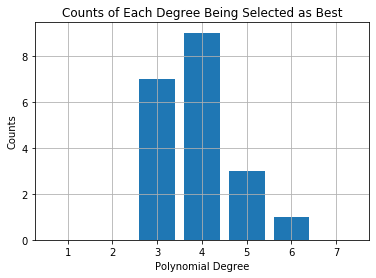

In [170]:
# Print out results
print(f"Average of d* is {np.mean(best_ds)} with a standard deviation of {np.std(best_ds)}")
print(f"Average test error is {np.mean(d_errors)} with a standard deviation of {np.std(d_errors)}")

# Print best ds
print("Best d's over cross validations")
print(best_ds)
d_counts = np.zeros((len(d_range)))
unique, counts = np.unique(best_ds, return_counts = True)
d_counts[unique-1] = counts

plt.figure()
plt.title('Counts of Each Degree Being Selected as Best')
plt.bar(1 + np.arange(7), d_counts)
plt.xlabel('Polynomial Degree')
plt.ylabel('Counts')
plt.grid()

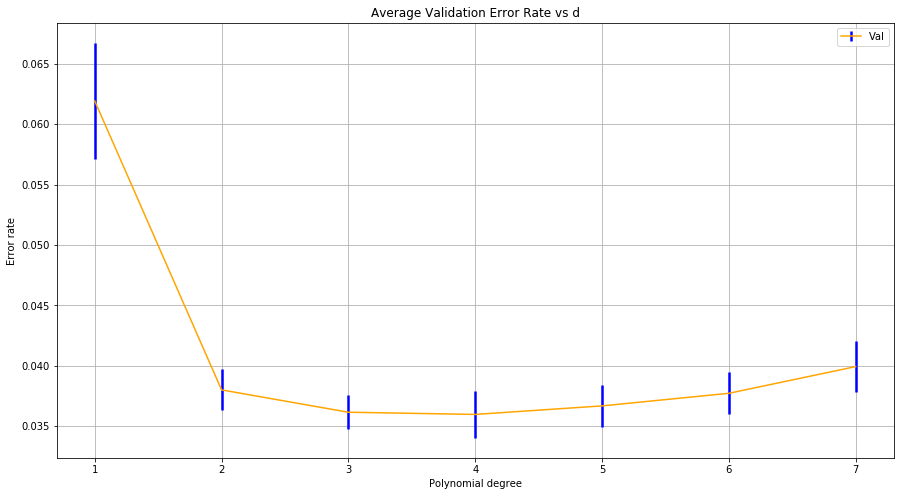

In [179]:
# Cross validation visualisation
av_val_error = np.mean(all_d_errors, axis = 1); std_val_error = np.std(all_d_errors, axis = 1)
plt.figure(figsize = (15,8))
plt.title('Average Validation Error Rate vs d')
plt.errorbar(d_range, av_val_error, yerr = std_val_error, label = 'Val', elinewidth = 2.5, ecolor = 'b', color = 'orange')
plt.xlabel('Polynomial degree')
plt.ylabel('Error rate')
plt.legend()
plt.grid()

### Basic Result (Gaussian)

For fair comparison with one versus all approach, we use the same Gaussian Kernel Coefficients found in 1.5

In [153]:
# Auxiliary Functions
def split_train_test_distances(data_samples, data_labels, train_prop, test_prop, seed = 88):
    """
    Split to 80% train and 20% test as required, randomly by first shuffling
    """
    n_tot = data_samples.shape[0]; n_train = round(train_prop * n_tot)
    
    np.random.seed(seed)
    permute = np.random.permutation(n_tot)
    
    data_shuffled = data_samples[permute,:]
    data_shuffled_labels = data_labels[permute]
    
    train_samples = data_shuffled[:n_train, :]; train_labels = data_shuffled_labels[:n_train]
    test_samples = data_shuffled[n_train:, :]; test_labels = data_shuffled_labels[n_train:]
    
    S = data_shuffled @ data_shuffled.T
    diag_s = np.sum(data_shuffled * data_shuffled, axis = 1)
    distances = diag_s.reshape(-1,1) + diag_s.reshape(1,-1) - 2 * S
    
    train_distances = distances[:n_train, :n_train]
    test_distances = distances[:n_train, n_train:]
    
    return train_samples, train_labels, test_samples, test_labels, train_distances, test_distances

def gaussian_kernel(train_dat, test_pt, c):
    """
    Computes the gaussian kernel for a given c
    """
    
    Sxx = np.sum(train_dat * train_dat, axis = 1).reshape(-1,1)
    Syy = np.sum(test_pt * test_pt, axis = 1).reshape(1,-1)
    Sxy = train_dat @ test_pt.T
    
    distances_train_test = Sxx + Syy - 2 * Sxy
    
    return np.exp(-c * distances_train_test)

In [176]:
n_epochs = 20; num_classes = 10; num_classifiers = 45; num_iter = 20; c_pow_range = np.arange(-10, -3, 1)

# Create array to store the results of every d's. The results stored are the END results after training is stopped
c_results_train = np.zeros((len(c_pow_range), num_iter)); c_results_test = np.zeros((len(c_pow_range), num_iter))

for it in range(num_iter):
    # For each iteration re-split. But NOT re-split for every d, lest it won't be a fair comparison
    start_iter = time.time()
    train_samples, train_labels, test_samples, test_labels = split_train_test(data_samples, data_labels, 0.8, 0.2, seed = it)
    print(f"Iteration {it+1}/{num_iter}")
    
    # Iterate through d's on the SAME split for this run
    for c_pow_ind in range(len(c_pow_range)):
        c_pow = c_pow_range[c_pow_ind]; c = 2 ** float(c_pow)
        print(f"c = 2^{c_pow}")
        # Pre-compute the kernel matrices before running epochs of training
        kernel_mat_train = gaussian_kernel(train_samples, train_samples, c)
        kernel_mat = gaussian_kernel(train_samples, test_samples, c)
        
        # Initialise mistake counters
        mistake_counters = init_mistake_counters(train_samples, num_classifiers)
        
        # Run the training
        mistake_counters, train_rate, train_preds, test_rate, test_preds = train_nepochs(train_samples, train_labels, test_samples, test_labels, mistake_counters
                                                                            , num_classifiers, num_classes, kernel_mat_train, kernel_mat, n_epochs)
        
        # Append result for this d
        c_results_train[c_pow_ind, it] = train_rate; c_results_test[c_pow_ind, it] = test_rate
        
    print(f"Iteration done at {time.time() - start_iter}")

Iteration 1/20
c = 2^-10
For epoch 0, train error rate is 0.17666039257865018, and test error rate is 0.13870967741935483
For epoch 1, train error rate is 0.0950524334498521, and test error rate is 0.0956989247311828
For epoch 2, train error rate is 0.0727346060769024, and test error rate is 0.06666666666666667
For epoch 3, train error rate is 0.062382360849690774, and test error rate is 0.06559139784946237
For epoch 4, train error rate is 0.053374563054584566, and test error rate is 0.08602150537634409
For epoch 5, train error rate is 0.0471901048668997, and test error rate is 0.0967741935483871
For epoch 6, train error rate is 0.04423232051626781, and test error rate is 0.06827956989247312
For epoch 7, train error rate is 0.040871201936004305, and test error rate is 0.06451612903225806
For epoch 8, train error rate is 0.03240118311374025, and test error rate is 0.06774193548387097
For epoch 9, train error rate is 0.03092229093842431, and test error rate is 0.053763440860215055
For ep

For epoch 1, train error rate is 0.020435600968002152, and test error rate is 0.04139784946236559
For epoch 2, train error rate is 0.004705566012368916, and test error rate is 0.03655913978494624
For epoch 3, train error rate is 0.0014788921753159452, and test error rate is 0.034408602150537634
For epoch 4, train error rate is 0.0008066684592632429, and test error rate is 0.034408602150537634
For epoch 5, train error rate is 0.0005377789728421619, and test error rate is 0.03494623655913978
For epoch 6, train error rate is 0.00026888948642108095, and test error rate is 0.034408602150537634
For epoch 7, train error rate is 0.00026888948642108095, and test error rate is 0.034408602150537634
Early stopping at 7 epochs
c = 2^-4
For epoch 0, train error rate is 0.09948910997579995, and test error rate is 0.06397849462365592
For epoch 1, train error rate is 0.0232589405754235, and test error rate is 0.046236559139784944
For epoch 2, train error rate is 0.0029577843506318905, and test error ra

For epoch 1, train error rate is 0.023931164291476202, and test error rate is 0.032795698924731186
For epoch 2, train error rate is 0.009411132024737832, and test error rate is 0.03387096774193549
For epoch 3, train error rate is 0.003361118580263512, and test error rate is 0.03118279569892473
For epoch 4, train error rate is 0.0021511158913686476, and test error rate is 0.02903225806451613
For epoch 5, train error rate is 0.0006722237160527024, and test error rate is 0.02795698924731183
For epoch 6, train error rate is 0.0008066684592632429, and test error rate is 0.02795698924731183
For epoch 7, train error rate is 0.0005377789728421619, and test error rate is 0.02795698924731183
For epoch 8, train error rate is 0.00026888948642108095, and test error rate is 0.02849462365591398
Early stopping at 8 epochs
c = 2^-5
For epoch 0, train error rate is 0.0894057542350094, and test error rate is 0.0543010752688172
For epoch 1, train error rate is 0.024872277493949987, and test error rate is 

For epoch 1, train error rate is 0.030115622479161063, and test error rate is 0.041935483870967745
For epoch 2, train error rate is 0.015595590212422693, and test error rate is 0.03602150537634408
For epoch 3, train error rate is 0.006722237160527024, and test error rate is 0.023655913978494623
For epoch 4, train error rate is 0.004840010755579457, and test error rate is 0.026344086021505377
For epoch 5, train error rate is 0.002554450121000269, and test error rate is 0.024193548387096774
For epoch 6, train error rate is 0.0005377789728421619, and test error rate is 0.02043010752688172
For epoch 7, train error rate is 0.00040333422963162143, and test error rate is 0.023118279569892472
For epoch 8, train error rate is 0.0006722237160527024, and test error rate is 0.02043010752688172
For epoch 9, train error rate is 0.00040333422963162143, and test error rate is 0.02043010752688172
Early stopping at 9 epochs
c = 2^-6
For epoch 0, train error rate is 0.08214573810164022, and test error ra

For epoch 5, train error rate is 0.007932239849421888, and test error rate is 0.046236559139784944
For epoch 6, train error rate is 0.004571121269158376, and test error rate is 0.041935483870967745
For epoch 7, train error rate is 0.00282333960742135, and test error rate is 0.046236559139784944
For epoch 8, train error rate is 0.003092229093842431, and test error rate is 0.043548387096774194
For epoch 9, train error rate is 0.002285560634579188, and test error rate is 0.0456989247311828
For epoch 10, train error rate is 0.0009411132024737832, and test error rate is 0.04408602150537634
For epoch 11, train error rate is 0.0008066684592632429, and test error rate is 0.044623655913978495
For epoch 12, train error rate is 0.0005377789728421619, and test error rate is 0.04408602150537634
For epoch 13, train error rate is 0.0010755579456843238, and test error rate is 0.04408602150537634
Early stopping at 13 epochs
c = 2^-7
For epoch 0, train error rate is 0.0916913148695886, and test error ra

For epoch 15, train error rate is 0.006453347674105943, and test error rate is 0.04247311827956989
For epoch 16, train error rate is 0.007260016133369185, and test error rate is 0.03924731182795699
For epoch 17, train error rate is 0.005108900242000538, and test error rate is 0.04032258064516129
For epoch 18, train error rate is 0.004705566012368916, and test error rate is 0.04086021505376344
For epoch 19, train error rate is 0.004302231782737295, and test error rate is 0.04032258064516129
c = 2^-8
For epoch 0, train error rate is 0.11804248453885453, and test error rate is 0.09301075268817205
For epoch 1, train error rate is 0.04275342834095187, and test error rate is 0.04946236559139785
For epoch 2, train error rate is 0.02312449583221296, and test error rate is 0.03064516129032258
For epoch 3, train error rate is 0.015057811239580532, and test error rate is 0.03870967741935484
For epoch 4, train error rate is 0.010486689970422156, and test error rate is 0.041935483870967745
For epoc

For epoch 14, train error rate is 0.022048937886528636, and test error rate is 0.05860215053763441
For epoch 15, train error rate is 0.018150040333422962, and test error rate is 0.0532258064516129
For epoch 16, train error rate is 0.018418929819844044, and test error rate is 0.0543010752688172
For epoch 17, train error rate is 0.01707448238773864, and test error rate is 0.04946236559139785
For epoch 18, train error rate is 0.014788921753159451, and test error rate is 0.05053763440860215
For epoch 19, train error rate is 0.01398225329389621, and test error rate is 0.05698924731182796
c = 2^-9
For epoch 0, train error rate is 0.14493143318096263, and test error rate is 0.08709677419354839
For epoch 1, train error rate is 0.07085237967195483, and test error rate is 0.08118279569892473
For epoch 2, train error rate is 0.04907233127184727, and test error rate is 0.05806451612903226
For epoch 3, train error rate is 0.03683785963968809, and test error rate is 0.05053763440860215
For epoch 4, 

For epoch 1, train error rate is 0.08954019897821995, and test error rate is 0.06881720430107527
For epoch 2, train error rate is 0.07502016671148158, and test error rate is 0.07849462365591398
For epoch 3, train error rate is 0.06439903199784888, and test error rate is 0.07258064516129033
For epoch 4, train error rate is 0.053374563054584566, and test error rate is 0.06075268817204301
For epoch 5, train error rate is 0.04705566012368916, and test error rate is 0.0478494623655914
For epoch 6, train error rate is 0.040871201936004305, and test error rate is 0.05268817204301075
For epoch 7, train error rate is 0.04046786770637268, and test error rate is 0.0553763440860215
For epoch 8, train error rate is 0.0345522990051089, and test error rate is 0.04516129032258064
For epoch 9, train error rate is 0.032266738370529714, and test error rate is 0.046236559139784944
For epoch 10, train error rate is 0.021914493143318097, and test error rate is 0.04516129032258064
For epoch 11, train error r

For epoch 3, train error rate is 0.0032266738370529714, and test error rate is 0.04247311827956989
For epoch 4, train error rate is 0.0010755579456843238, and test error rate is 0.04139784946236559
For epoch 5, train error rate is 0.00026888948642108095, and test error rate is 0.04139784946236559
For epoch 6, train error rate is 0.00026888948642108095, and test error rate is 0.041935483870967745
For epoch 7, train error rate is 0.00026888948642108095, and test error rate is 0.041935483870967745
For epoch 8, train error rate is 0.00026888948642108095, and test error rate is 0.041935483870967745
Early stopping at 8 epochs
c = 2^-4
For epoch 0, train error rate is 0.10137133638074751, and test error rate is 0.06935483870967742
For epoch 1, train error rate is 0.024737832750739448, and test error rate is 0.0553763440860215
For epoch 2, train error rate is 0.003361118580263512, and test error rate is 0.05698924731182796
For epoch 3, train error rate is 0.0016133369185264857, and test error 

For epoch 4, train error rate is 0.0013444474321054048, and test error rate is 0.026344086021505377
For epoch 5, train error rate is 0.0009411132024737832, and test error rate is 0.026344086021505377
For epoch 6, train error rate is 0.0005377789728421619, and test error rate is 0.026344086021505377
For epoch 7, train error rate is 0.0005377789728421619, and test error rate is 0.026344086021505377
For epoch 8, train error rate is 0.00026888948642108095, and test error rate is 0.026344086021505377
For epoch 9, train error rate is 0.00026888948642108095, and test error rate is 0.026344086021505377
Early stopping at 9 epochs
c = 2^-5
For epoch 0, train error rate is 0.08779241731648292, and test error rate is 0.043548387096774194
For epoch 1, train error rate is 0.021107824684054855, and test error rate is 0.034408602150537634
For epoch 2, train error rate is 0.006050013444474321, and test error rate is 0.03333333333333333
For epoch 3, train error rate is 0.0018822264049475664, and test er

For epoch 7, train error rate is 0.00026888948642108095, and test error rate is 0.03064516129032258
For epoch 8, train error rate is 0.00026888948642108095, and test error rate is 0.03118279569892473
For epoch 9, train error rate is 0.00040333422963162143, and test error rate is 0.03064516129032258
Early stopping at 9 epochs
c = 2^-6
For epoch 0, train error rate is 0.08133906964237698, and test error rate is 0.03870967741935484
For epoch 1, train error rate is 0.023931164291476202, and test error rate is 0.034408602150537634
For epoch 2, train error rate is 0.010486689970422156, and test error rate is 0.031720430107526884
For epoch 3, train error rate is 0.0024200053777897286, and test error rate is 0.02956989247311828
For epoch 4, train error rate is 0.0010755579456843238, and test error rate is 0.030107526881720432
For epoch 5, train error rate is 0.0005377789728421619, and test error rate is 0.02956989247311828
For epoch 6, train error rate is 0.00040333422963162143, and test error

For epoch 13, train error rate is 0.0005377789728421619, and test error rate is 0.038172043010752686
Early stopping at 13 epochs
c = 2^-7
For epoch 0, train error rate is 0.0937079860177467, and test error rate is 0.05913978494623656
For epoch 1, train error rate is 0.03092229093842431, and test error rate is 0.03387096774193549
For epoch 2, train error rate is 0.01452003226673837, and test error rate is 0.03763440860215054
For epoch 3, train error rate is 0.007260016133369185, and test error rate is 0.035483870967741936
For epoch 4, train error rate is 0.004974455498789997, and test error rate is 0.030107526881720432
For epoch 5, train error rate is 0.002016671148158107, and test error rate is 0.03064516129032258
For epoch 6, train error rate is 0.0017477816617370262, and test error rate is 0.03333333333333333
For epoch 7, train error rate is 0.0018822264049475664, and test error rate is 0.02956989247311828
For epoch 8, train error rate is 0.0009411132024737832, and test error rate is

For epoch 17, train error rate is 0.0017477816617370262, and test error rate is 0.03870967741935484
For epoch 18, train error rate is 0.0014788921753159452, and test error rate is 0.04032258064516129
For epoch 19, train error rate is 0.0013444474321054048, and test error rate is 0.03870967741935484
c = 2^-8
For epoch 0, train error rate is 0.11320247378327507, and test error rate is 0.06075268817204301
For epoch 1, train error rate is 0.04611454692121538, and test error rate is 0.05698924731182796
For epoch 2, train error rate is 0.02312449583221296, and test error rate is 0.0456989247311828
For epoch 3, train error rate is 0.01774670610379134, and test error rate is 0.04086021505376344
For epoch 4, train error rate is 0.013041140091422425, and test error rate is 0.04086021505376344
For epoch 5, train error rate is 0.007663350363000807, and test error rate is 0.03602150537634408
For epoch 6, train error rate is 0.005377789728421619, and test error rate is 0.03118279569892473
For epoch 

For epoch 4, train error rate is 0.029712288249529442, and test error rate is 0.056451612903225805
For epoch 5, train error rate is 0.01936004302231783, and test error rate is 0.053763440860215055
For epoch 6, train error rate is 0.015595590212422693, and test error rate is 0.05698924731182796
For epoch 7, train error rate is 0.011696692659317021, and test error rate is 0.08548387096774193
For epoch 8, train error rate is 0.010755579456843238, and test error rate is 0.05967741935483871
For epoch 9, train error rate is 0.012637805861790804, and test error rate is 0.0532258064516129
For epoch 10, train error rate is 0.008335574079053509, and test error rate is 0.054838709677419356
For epoch 11, train error rate is 0.007528905619790266, and test error rate is 0.0543010752688172
For epoch 12, train error rate is 0.006184458187684862, and test error rate is 0.05268817204301075
For epoch 13, train error rate is 0.004167787039526754, and test error rate is 0.05
For epoch 14, train error rate 

For epoch 15, train error rate is 0.022183382629739175, and test error rate is 0.0467741935483871
For epoch 16, train error rate is 0.018418929819844044, and test error rate is 0.0478494623655914
For epoch 17, train error rate is 0.015192255982791072, and test error rate is 0.04946236559139785
For epoch 18, train error rate is 0.01398225329389621, and test error rate is 0.05053763440860215
For epoch 19, train error rate is 0.01465447700994891, and test error rate is 0.047311827956989246
c = 2^-9
For epoch 0, train error rate is 0.1371336380747513, and test error rate is 0.08172043010752689
For epoch 1, train error rate is 0.0684323742941651, and test error rate is 0.05591397849462366
For epoch 2, train error rate is 0.049744554987899973, and test error rate is 0.06397849462365592
For epoch 3, train error rate is 0.0395267545038989, and test error rate is 0.05161290322580645
For epoch 4, train error rate is 0.0289056197902662, and test error rate is 0.05913978494623656
For epoch 5, trai

For epoch 2, train error rate is 0.06816348480774402, and test error rate is 0.12473118279569892
For epoch 3, train error rate is 0.06076902393116429, and test error rate is 0.08387096774193549
For epoch 4, train error rate is 0.050820112933584294, and test error rate is 0.10913978494623656
For epoch 5, train error rate is 0.04302231782737295, and test error rate is 0.11397849462365592
For epoch 6, train error rate is 0.04060231244958322, and test error rate is 0.08870967741935484
For epoch 7, train error rate is 0.036300080666845924, and test error rate is 0.09731182795698924
For epoch 8, train error rate is 0.030787846195213766, and test error rate is 0.10053763440860215
For epoch 9, train error rate is 0.029443398763108364, and test error rate is 0.08440860215053764
For epoch 10, train error rate is 0.028233396074213497, and test error rate is 0.08602150537634409
For epoch 11, train error rate is 0.02554450121000269, and test error rate is 0.09301075268817205
For epoch 12, train err

For epoch 1, train error rate is 0.023662274805055124, and test error rate is 0.04946236559139785
For epoch 2, train error rate is 0.0036300080666845924, and test error rate is 0.05053763440860215
For epoch 3, train error rate is 0.0006722237160527024, and test error rate is 0.05053763440860215
For epoch 4, train error rate is 0.0005377789728421619, and test error rate is 0.05053763440860215
For epoch 5, train error rate is 0.00013444474321054048, and test error rate is 0.05053763440860215
For epoch 6, train error rate is 0.0005377789728421619, and test error rate is 0.05053763440860215
For epoch 7, train error rate is 0.00026888948642108095, and test error rate is 0.051075268817204304
For epoch 8, train error rate is 0.0, and test error rate is 0.051075268817204304
Early stopping at 8 epochs
Iteration done at 119.36566972732544
Iteration 15/20
c = 2^-10
For epoch 0, train error rate is 0.1770637268082818, and test error rate is 0.1
For epoch 1, train error rate is 0.09317020704490454,

For epoch 7, train error rate is 0.00026888948642108095, and test error rate is 0.03387096774193549
For epoch 8, train error rate is 0.00026888948642108095, and test error rate is 0.03387096774193549
For epoch 9, train error rate is 0.00026888948642108095, and test error rate is 0.034408602150537634
Early stopping at 9 epochs
c = 2^-5
For epoch 0, train error rate is 0.0833557407905351, and test error rate is 0.05161290322580645
For epoch 1, train error rate is 0.022048937886528636, and test error rate is 0.03602150537634408
For epoch 2, train error rate is 0.007663350363000807, and test error rate is 0.035483870967741936
For epoch 3, train error rate is 0.0016133369185264857, and test error rate is 0.035483870967741936
For epoch 4, train error rate is 0.0005377789728421619, and test error rate is 0.035483870967741936
For epoch 5, train error rate is 0.0008066684592632429, and test error rate is 0.035483870967741936
For epoch 6, train error rate is 0.00026888948642108095, and test erro

For epoch 9, train error rate is 0.00026888948642108095, and test error rate is 0.030107526881720432
For epoch 10, train error rate is 0.00026888948642108095, and test error rate is 0.02849462365591398
Early stopping at 10 epochs
c = 2^-6
For epoch 0, train error rate is 0.08295240656090347, and test error rate is 0.037096774193548385
For epoch 1, train error rate is 0.020973379940844313, and test error rate is 0.02956989247311828
For epoch 2, train error rate is 0.006587792417316483, and test error rate is 0.023118279569892472
For epoch 3, train error rate is 0.0026888948642108095, and test error rate is 0.023655913978494623
For epoch 4, train error rate is 0.0009411132024737832, and test error rate is 0.024193548387096774
For epoch 5, train error rate is 0.00013444474321054048, and test error rate is 0.024731182795698924
For epoch 6, train error rate is 0.0, and test error rate is 0.024731182795698924
For epoch 7, train error rate is 0.0, and test error rate is 0.024731182795698924
F

For epoch 3, train error rate is 0.006587792417316483, and test error rate is 0.034408602150537634
For epoch 4, train error rate is 0.0021511158913686476, and test error rate is 0.03870967741935484
For epoch 5, train error rate is 0.0013444474321054048, and test error rate is 0.035483870967741936
For epoch 6, train error rate is 0.00040333422963162143, and test error rate is 0.035483870967741936
For epoch 7, train error rate is 0.00040333422963162143, and test error rate is 0.035483870967741936
For epoch 8, train error rate is 0.00026888948642108095, and test error rate is 0.035483870967741936
For epoch 9, train error rate is 0.0006722237160527024, and test error rate is 0.035483870967741936
Early stopping at 9 epochs
c = 2^-6
For epoch 0, train error rate is 0.08308685130411401, and test error rate is 0.05268817204301075
For epoch 1, train error rate is 0.022452272116160257, and test error rate is 0.046236559139784944
For epoch 2, train error rate is 0.009007797795106211, and test err

For epoch 10, train error rate is 0.002016671148158107, and test error rate is 0.03924731182795699
For epoch 11, train error rate is 0.0008066684592632429, and test error rate is 0.03870967741935484
For epoch 12, train error rate is 0.00040333422963162143, and test error rate is 0.03924731182795699
For epoch 13, train error rate is 0.0005377789728421619, and test error rate is 0.03924731182795699
For epoch 14, train error rate is 0.0005377789728421619, and test error rate is 0.03924731182795699
For epoch 15, train error rate is 0.0008066684592632429, and test error rate is 0.03924731182795699
Early stopping at 15 epochs
c = 2^-7
For epoch 0, train error rate is 0.09478354396343103, and test error rate is 0.06129032258064516
For epoch 1, train error rate is 0.027292282871739716, and test error rate is 0.03655913978494624
For epoch 2, train error rate is 0.01452003226673837, and test error rate is 0.03655913978494624
For epoch 3, train error rate is 0.007932239849421888, and test error r

For epoch 13, train error rate is 0.005108900242000538, and test error rate is 0.04086021505376344
For epoch 14, train error rate is 0.004302231782737295, and test error rate is 0.04838709677419355
For epoch 15, train error rate is 0.0038988975531056734, and test error rate is 0.04139784946236559
For epoch 16, train error rate is 0.004167787039526754, and test error rate is 0.0456989247311828
For epoch 17, train error rate is 0.0014788921753159452, and test error rate is 0.044623655913978495
For epoch 18, train error rate is 0.0013444474321054048, and test error rate is 0.04086021505376344
For epoch 19, train error rate is 0.0014788921753159452, and test error rate is 0.0467741935483871
c = 2^-8
For epoch 0, train error rate is 0.11548803441785427, and test error rate is 0.09731182795698924
For epoch 1, train error rate is 0.04544232320516268, and test error rate is 0.04032258064516129
For epoch 2, train error rate is 0.030518956708792688, and test error rate is 0.05268817204301075
For

For epoch 4, train error rate is 0.03186340414089809, and test error rate is 0.06720430107526881
For epoch 5, train error rate is 0.021376714170475934, and test error rate is 0.05806451612903226
For epoch 6, train error rate is 0.016671148158107017, and test error rate is 0.05053763440860215
For epoch 7, train error rate is 0.013578919064264587, and test error rate is 0.04838709677419355
For epoch 8, train error rate is 0.012772250605001345, and test error rate is 0.0543010752688172
For epoch 9, train error rate is 0.01156224791610648, and test error rate is 0.0456989247311828
For epoch 10, train error rate is 0.011024468943264318, and test error rate is 0.05591397849462366
For epoch 11, train error rate is 0.00873890830868513, and test error rate is 0.046236559139784944
For epoch 12, train error rate is 0.007260016133369185, and test error rate is 0.044623655913978495
For epoch 13, train error rate is 0.006856681903737564, and test error rate is 0.04032258064516129
For epoch 14, train

In [181]:
c_results_test[-1,:]

array([0.04408602, 0.04677419, 0.03602151, 0.04677419, 0.04623656,
       0.04946237, 0.05537634, 0.04032258, 0.05322581, 0.05107527,
       0.03763441, 0.05215054, 0.04032258, 0.05107527, 0.04623656,
       0.04731183, 0.05537634, 0.04677419, 0.04516129, 0.05053763])

In [184]:
means_train = np.mean(c_results_train, axis = 1); stds_train = np.std(c_results_train, axis = 1)
means_test = np.mean(c_results_test, axis = 1); stds_test = np.std(c_results_test, axis = 1)
for c_pow_ind in range(len(c_pow_range)):
    print(f"For c = 2^{c_pow_range[c_pow_ind]}, mean train error is {means_train[c_pow_ind]} with a standard deviation of {stds_train[c_pow_ind]}")
    print(f"For c = 2^{c_pow_range[c_pow_ind]}, mean test error is {means_test[c_pow_ind]} with a standard deviation of {stds_test[c_pow_ind]}")

For c = 2^-10, mean train error is 0.016765259478354395 with a standard deviation of 0.008030088629041069
For c = 2^-10, mean test error is 0.056075268817204295 with a standard deviation of 0.00848389822419542
For c = 2^-9, mean train error is 0.0024872277493949986 with a standard deviation of 0.00242205852374969
For c = 2^-9, mean test error is 0.04161290322580645 with a standard deviation of 0.005216439235095558
For c = 2^-8, mean train error is 0.00033611185802635114 with a standard deviation of 0.00020166711481581071
For c = 2^-8, mean test error is 0.03588709677419355 with a standard deviation of 0.004347448262349162
For c = 2^-7, mean train error is 0.00040333422963162143 with a standard deviation of 0.0003942693815169449
For c = 2^-7, mean test error is 0.031263440860215055 with a standard deviation of 0.004866333930153119
For c = 2^-6, mean train error is 0.0002083893519763377 with a standard deviation of 0.00015606596889276552
For c = 2^-6, mean test error is 0.030430107526881

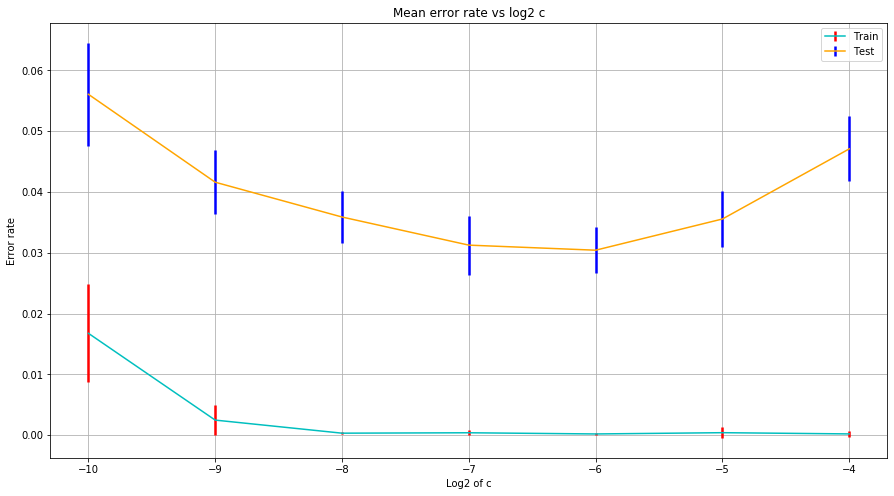

In [183]:
# Visualisation
means_train = np.mean(c_results_train, axis = 1); stds_train = np.std(c_results_train, axis = 1)
means_test = np.mean(c_results_test, axis = 1); stds_test = np.std(c_results_test, axis = 1)
plt.figure(figsize = (15,8))
plt.title('Mean error rate vs log2 c')
plt.errorbar(c_pow_range, means_train, yerr = stds_train, label = 'Train', elinewidth = 2.5, ecolor = 'r', color = 'c')
plt.errorbar(c_pow_range, means_test, yerr = stds_test, label = 'Test', elinewidth = 2.5, ecolor = 'b', color = 'orange')
plt.xlabel('Log2 of c')
plt.ylabel('Error rate')
plt.legend()
plt.grid()

### Cross Validation

In [159]:
# Loop 20 times
num_iter = 20
c_errors = []; best_cs = []; c_pow_range = np.arange(-10, -3, 1); all_c_errors = np.zeros((len(c_pow_range), num_iter))
for it in range(num_iter):
    # Do 1 cross-validation, and then outer-loop it by 20 times
    start_val = time.time()
    n = 5; n_epochs = 20; num_classes = 10
    # Split for every run
    train_samples, train_labels, test_samples, test_labels, train_distances, test_distances = split_train_test_distances(data_samples, data_labels, 0.8, 0.2, seed = it)

    # Divide into sub-arrays
    x_train, y_train, sub_idxs = getSubArray(train_samples, train_labels.reshape(-1,1), n)

    # Convert to numpy arrays for ease of slicing
    x_train = np.array(x_train); y_train = np.array(y_train)

    # 1 5-fold cross validation starts here
    c_val_results = np.zeros((len(c_pow_range)))
    for pow_idx in range(len(c_pow_range)):
        power = c_pow_range[pow_idx]
        print(f"For c = c^{power}")
        c = 2 ** float(power)
        kernel_mat_train = np.exp(train_distances * -c)
        kernel_mat_idxs = np.arange(kernel_mat_train.shape[0])
        # Iterate through each validation sub-array, the rest become training
        val_indexes = np.arange(n); val_err = []

        for val_idx in val_indexes:
            # Get training sub-array indexes
            train_indexes = np.delete(val_indexes, val_idx)

            # Get validation fold index range
            val_range = np.arange(sub_idxs[val_idx][0], sub_idxs[val_idx][1])

            # Slice off the validation samples from the large kernel matrix, and get the train and val based on the folds
            train_kernel_mat = np.delete(kernel_mat_train, val_range, axis = 0)
            val_kernel_mat = train_kernel_mat[:,val_range]
            train_kernel_mat = np.delete(train_kernel_mat, val_range, axis = 1)

            # Take one fold as val, rest becomes training
            val_samples = x_train[val_idx]; val_labels = y_train[val_idx].reshape(-1)

            # Training set
            train_mini_samples = catSubArrays(x_train[train_indexes]); train_mini_labels = catSubArrays(y_train[train_indexes]).reshape(-1)

            # Train on training set for some epochs, and then test
            mistake_counters = init_mistake_counters(train_mini_samples, num_classifiers)
            mistake_counters, train_rate, train_preds, test_rate, test_preds = train_nepochs(train_mini_samples, train_mini_labels, val_samples, val_labels, mistake_counters
                                                                                          ,num_classifiers, num_classes, train_kernel_mat, val_kernel_mat, n_epochs)


            # Append validation results
            val_err.append(test_rate)

        # Store this c's results
        c_val_results[pow_idx] = np.mean(val_err); all_c_errors[pow_idx, it] = np.mean(val_err)

    # # Find best c, re-train on whole train_samples and obtain final test performance
    power_idx_star = np.argmin(c_val_results); power_star = c_pow_range[power_idx_star]; c_star = 2 ** float(power_star)
    print(f"For iteration {it+1}, best c is {c_star}")
    kernel_mat_test = np.exp(test_distances * -c_star)
    kernel_mat_train = np.exp(train_distances * -c_star)
    mistake_counters = init_mistake_counters(train_samples, num_classifiers)
    mistake_counters, train_rate, train_preds, test_rate, test_preds = train_nepochs(train_samples, train_labels, test_samples, test_labels, mistake_counters
                                                                                      ,num_classifiers, num_classes, kernel_mat_train, kernel_mat_test, n_epochs)
    print(f"For c = {c_star}, retraining gives a final test error rate of {test_rate}")

    # Append result of this cross validation
    c_errors.append(test_rate); best_cs.append(c_star)
    
    print(f"Time for 1 cross validation across given c is {time.time() - start_val}")

For c = c^-10
For epoch 0, train error rate is 0.1833305326835826, and test error rate is 0.11230665770006724
For epoch 1, train error rate is 0.09796672828096119, and test error rate is 0.11903160726294552
For epoch 2, train error rate is 0.07360107544950428, and test error rate is 0.12172158708809684
For epoch 3, train error rate is 0.05948580070576374, and test error rate is 0.08069939475453934
For epoch 4, train error rate is 0.05679717694505125, and test error rate is 0.08069939475453934
For epoch 5, train error rate is 0.04957150058813645, and test error rate is 0.09549428379287156
For epoch 6, train error rate is 0.038312888590152916, and test error rate is 0.09145931405514458
For epoch 7, train error rate is 0.0337758359939506, and test error rate is 0.10558170813718896
For epoch 8, train error rate is 0.03427995294908419, and test error rate is 0.0941492938802959
For epoch 9, train error rate is 0.027726432532347505, and test error rate is 0.0847343644922663
For epoch 10, trai

For epoch 8, train error rate is 0.0373109243697479, and test error rate is 0.06720430107526881
For epoch 9, train error rate is 0.030756302521008402, and test error rate is 0.07190860215053764
For epoch 10, train error rate is 0.023361344537815125, and test error rate is 0.061155913978494625
For epoch 11, train error rate is 0.021680672268907564, and test error rate is 0.0678763440860215
For epoch 12, train error rate is 0.024201680672268907, and test error rate is 0.07526881720430108
For epoch 13, train error rate is 0.018487394957983194, and test error rate is 0.06922043010752688
For epoch 14, train error rate is 0.01546218487394958, and test error rate is 0.06518817204301075
For epoch 15, train error rate is 0.01361344537815126, and test error rate is 0.07594086021505377
For epoch 16, train error rate is 0.00823529411764706, and test error rate is 0.05510752688172043
For epoch 17, train error rate is 0.011932773109243698, and test error rate is 0.056451612903225805
For epoch 18, tr

For epoch 15, train error rate is 0.007226890756302521, and test error rate is 0.06854838709677419
For epoch 16, train error rate is 0.002857142857142857, and test error rate is 0.04771505376344086
For epoch 17, train error rate is 0.002689075630252101, and test error rate is 0.04838709677419355
For epoch 18, train error rate is 0.0025210084033613447, and test error rate is 0.04771505376344086
For epoch 19, train error rate is 0.0015126050420168067, and test error rate is 0.04771505376344086
For epoch 0, train error rate is 0.15008403361344538, and test error rate is 0.07594086021505377
For epoch 1, train error rate is 0.07243697478991597, and test error rate is 0.09475806451612903
For epoch 2, train error rate is 0.05378151260504202, and test error rate is 0.0967741935483871
For epoch 3, train error rate is 0.037815126050420166, and test error rate is 0.06720430107526881
For epoch 4, train error rate is 0.025210084033613446, and test error rate is 0.05443548387096774
For epoch 5, trai

For epoch 12, train error rate is 0.0008403361344537816, and test error rate is 0.0456989247311828
For epoch 13, train error rate is 0.0010084033613445378, and test error rate is 0.0456989247311828
For epoch 14, train error rate is 0.0010084033613445378, and test error rate is 0.0456989247311828
Early stopping at 14 epochs
For epoch 0, train error rate is 0.12336134453781512, and test error rate is 0.10215053763440861
For epoch 1, train error rate is 0.04386554621848739, and test error rate is 0.06854838709677419
For epoch 2, train error rate is 0.03042016806722689, and test error rate is 0.06182795698924731
For epoch 3, train error rate is 0.01915966386554622, and test error rate is 0.06451612903225806
For epoch 4, train error rate is 0.016638655462184872, and test error rate is 0.07325268817204302
For epoch 5, train error rate is 0.00907563025210084, and test error rate is 0.046370967741935484
For epoch 6, train error rate is 0.006050420168067227, and test error rate is 0.05241935483

For epoch 3, train error rate is 0.0023525457906234245, and test error rate is 0.03698722259583053
For epoch 4, train error rate is 0.0003360779700890607, and test error rate is 0.03698722259583053
For epoch 5, train error rate is 0.0, and test error rate is 0.03698722259583053
For epoch 6, train error rate is 0.0, and test error rate is 0.03698722259583053
For epoch 7, train error rate is 0.0, and test error rate is 0.03698722259583053
Early stopping at 7 epochs
For epoch 0, train error rate is 0.08756302521008404, and test error rate is 0.0625
For epoch 1, train error rate is 0.02369747899159664, and test error rate is 0.03763440860215054
For epoch 2, train error rate is 0.010084033613445379, and test error rate is 0.034274193548387094
For epoch 3, train error rate is 0.0033613445378151263, and test error rate is 0.031586021505376344
For epoch 4, train error rate is 0.002184873949579832, and test error rate is 0.03293010752688172
For epoch 5, train error rate is 0.001176470588235294,

For epoch 2, train error rate is 0.006050420168067227, and test error rate is 0.034274193548387094
For epoch 3, train error rate is 0.0018487394957983194, and test error rate is 0.034274193548387094
For epoch 4, train error rate is 0.0006722689075630252, and test error rate is 0.033602150537634407
For epoch 5, train error rate is 0.0003361344537815126, and test error rate is 0.033602150537634407
For epoch 6, train error rate is 0.0003361344537815126, and test error rate is 0.034274193548387094
For epoch 7, train error rate is 0.0001680672268907563, and test error rate is 0.034274193548387094
Early stopping at 7 epochs
For c = c^-4
For epoch 0, train error rate is 0.10351201478743069, and test error rate is 0.06859448554135844
For epoch 1, train error rate is 0.03091917324819358, and test error rate is 0.05716207128446537
For epoch 2, train error rate is 0.00520920853638044, and test error rate is 0.05716207128446537
For epoch 3, train error rate is 0.0003360779700890607, and test error

For epoch 5, train error rate is 0.04722689075630252, and test error rate is 0.07123655913978495
For epoch 6, train error rate is 0.042352941176470586, and test error rate is 0.06518817204301075
For epoch 7, train error rate is 0.03932773109243697, and test error rate is 0.0625
For epoch 8, train error rate is 0.028739495798319328, and test error rate is 0.06317204301075269
For epoch 9, train error rate is 0.028739495798319328, and test error rate is 0.08333333333333333
For epoch 10, train error rate is 0.02588235294117647, and test error rate is 0.07661290322580645
For epoch 11, train error rate is 0.02134453781512605, and test error rate is 0.061155913978494625
For epoch 12, train error rate is 0.021176470588235293, and test error rate is 0.06317204301075269
For epoch 13, train error rate is 0.018823529411764704, and test error rate is 0.05981182795698925
For epoch 14, train error rate is 0.01915966386554622, and test error rate is 0.0678763440860215
For epoch 15, train error rate is

For epoch 9, train error rate is 0.014283313728785078, and test error rate is 0.05514458641560188
For epoch 10, train error rate is 0.012098806923206184, and test error rate is 0.04707464694014795
For epoch 11, train error rate is 0.009914300117627289, and test error rate is 0.04976462676529926
For epoch 12, train error rate is 0.007897832297092925, and test error rate is 0.0484196368527236
For epoch 13, train error rate is 0.00520920853638044, and test error rate is 0.04572965702757229
For epoch 14, train error rate is 0.004032935641068728, and test error rate is 0.05043712172158709
For epoch 15, train error rate is 0.004705091581246849, and test error rate is 0.04572965702757229
For epoch 16, train error rate is 0.0031927407158460763, and test error rate is 0.04774714189643578
For epoch 17, train error rate is 0.003024701730801546, and test error rate is 0.04707464694014795
For epoch 18, train error rate is 0.0023525457906234245, and test error rate is 0.04438466711499664
For epoch 1

For epoch 12, train error rate is 0.004369747899159664, and test error rate is 0.05577956989247312
For epoch 13, train error rate is 0.0035294117647058825, and test error rate is 0.0456989247311828
For epoch 14, train error rate is 0.001176470588235294, and test error rate is 0.046370967741935484
For epoch 15, train error rate is 0.0015126050420168067, and test error rate is 0.046370967741935484
For epoch 16, train error rate is 0.0016806722689075631, and test error rate is 0.0456989247311828
For epoch 17, train error rate is 0.0006722689075630252, and test error rate is 0.046370967741935484
For epoch 18, train error rate is 0.0005042016806722689, and test error rate is 0.04502688172043011
For epoch 19, train error rate is 0.0006722689075630252, and test error rate is 0.043682795698924734
For c = c^-8
For epoch 0, train error rate is 0.12720551167870947, and test error rate is 0.0605245460659045
For epoch 1, train error rate is 0.04721895479751302, and test error rate is 0.057162071284

For epoch 11, train error rate is 0.0005042016806722689, and test error rate is 0.04099462365591398
For epoch 12, train error rate is 0.001176470588235294, and test error rate is 0.04032258064516129
For epoch 13, train error rate is 0.0006722689075630252, and test error rate is 0.04032258064516129
For epoch 14, train error rate is 0.001176470588235294, and test error rate is 0.04502688172043011
For epoch 15, train error rate is 0.0006722689075630252, and test error rate is 0.0456989247311828
For epoch 16, train error rate is 0.0008403361344537816, and test error rate is 0.04032258064516129
For epoch 17, train error rate is 0.0006722689075630252, and test error rate is 0.04032258064516129
For epoch 18, train error rate is 0.0008403361344537816, and test error rate is 0.0396505376344086
Early stopping at 18 epochs
For c = c^-7
For epoch 0, train error rate is 0.10334397580238615, and test error rate is 0.05178211163416274
For epoch 1, train error rate is 0.03091917324819358, and test err

For epoch 9, train error rate is 0.0005042016806722689, and test error rate is 0.038978494623655914
Early stopping at 9 epochs
For epoch 0, train error rate is 0.09813476726600572, and test error rate is 0.05447209145931405
For epoch 1, train error rate is 0.02621408166694673, and test error rate is 0.0410221923335575
For epoch 2, train error rate is 0.012434884893295245, and test error rate is 0.03698722259583053
For epoch 3, train error rate is 0.006049403461603092, and test error rate is 0.03496973772696705
For epoch 4, train error rate is 0.0023525457906234245, and test error rate is 0.0363147276395427
For epoch 5, train error rate is 0.001008233910267182, and test error rate is 0.03564223268325487
For epoch 6, train error rate is 0.0008401949252226517, and test error rate is 0.03496973772696705
For epoch 7, train error rate is 0.0003360779700890607, and test error rate is 0.03564223268325487
For epoch 8, train error rate is 0.0008401949252226517, and test error rate is 0.036987222

For epoch 5, train error rate is 0.0003361344537815126, and test error rate is 0.05241935483870968
For epoch 6, train error rate is 0.0003361344537815126, and test error rate is 0.05309139784946237
Early stopping at 6 epochs
For epoch 0, train error rate is 0.11040161317425642, and test error rate is 0.06388702084734364
For epoch 1, train error rate is 0.02570996471181314, and test error rate is 0.05447209145931405
For epoch 2, train error rate is 0.004369013611157789, and test error rate is 0.0531271015467384
For epoch 3, train error rate is 0.0011762728953117123, and test error rate is 0.0531271015467384
For epoch 4, train error rate is 0.000504116955133591, and test error rate is 0.05245460659045057
For epoch 5, train error rate is 0.0003360779700890607, and test error rate is 0.05245460659045057
For epoch 6, train error rate is 0.0003360779700890607, and test error rate is 0.0531271015467384
For epoch 7, train error rate is 0.0008401949252226517, and test error rate is 0.0531271015

For epoch 6, train error rate is 0.04621072088724584, and test error rate is 0.08406186953597848
For epoch 7, train error rate is 0.037472693664930265, and test error rate is 0.08069939475453934
For epoch 8, train error rate is 0.03528818685935137, and test error rate is 0.07666442501681238
For epoch 9, train error rate is 0.032263485128549825, and test error rate is 0.082044384667115
For epoch 10, train error rate is 0.027894471517392036, and test error rate is 0.06455951580363148
For epoch 11, train error rate is 0.028230549487481094, and test error rate is 0.06186953597848016
For epoch 12, train error rate is 0.02520584775667955, and test error rate is 0.08338937457969066
For epoch 13, train error rate is 0.023357418921189716, and test error rate is 0.08675184936112978
For epoch 14, train error rate is 0.02083683414552176, and test error rate is 0.06119704102219233
For epoch 15, train error rate is 0.01932448328012099, and test error rate is 0.0605245460659045
For epoch 16, train er

For epoch 10, train error rate is 0.004873949579831933, and test error rate is 0.043010752688172046
For epoch 11, train error rate is 0.002184873949579832, and test error rate is 0.043010752688172046
For epoch 12, train error rate is 0.0025210084033613447, and test error rate is 0.04435483870967742
For epoch 13, train error rate is 0.002184873949579832, and test error rate is 0.043010752688172046
For epoch 14, train error rate is 0.0020168067226890756, and test error rate is 0.043010752688172046
For epoch 15, train error rate is 0.001176470588235294, and test error rate is 0.043010752688172046
For epoch 16, train error rate is 0.0008403361344537816, and test error rate is 0.043010752688172046
For epoch 17, train error rate is 0.0006722689075630252, and test error rate is 0.043682795698924734
For epoch 18, train error rate is 0.0001680672268907563, and test error rate is 0.043682795698924734
For epoch 19, train error rate is 0.0005042016806722689, and test error rate is 0.04368279569892

For epoch 13, train error rate is 0.0006721559401781214, and test error rate is 0.04572965702757229
For epoch 14, train error rate is 0.0008401949252226517, and test error rate is 0.04505716207128446
For epoch 15, train error rate is 0.0003360779700890607, and test error rate is 0.04505716207128446
For epoch 16, train error rate is 0.0003360779700890607, and test error rate is 0.04505716207128446
For epoch 17, train error rate is 0.0003360779700890607, and test error rate is 0.04505716207128446
For epoch 18, train error rate is 0.0003360779700890607, and test error rate is 0.04505716207128446
Early stopping at 18 epochs
For epoch 0, train error rate is 0.1280672268907563, and test error rate is 0.0678763440860215
For epoch 1, train error rate is 0.048403361344537814, and test error rate is 0.05443548387096774
For epoch 2, train error rate is 0.029411764705882353, and test error rate is 0.04435483870967742
For epoch 3, train error rate is 0.015966386554621848, and test error rate is 0.0

For epoch 1, train error rate is 0.028734666442614687, and test error rate is 0.05379959650302623
For epoch 2, train error rate is 0.0166358595194085, and test error rate is 0.05178211163416274
For epoch 3, train error rate is 0.009578222147538229, and test error rate is 0.04909213180901143
For epoch 4, train error rate is 0.005713325491514031, and test error rate is 0.04976462676529926
For epoch 5, train error rate is 0.0013443118803562427, and test error rate is 0.0484196368527236
For epoch 6, train error rate is 0.0008401949252226517, and test error rate is 0.04774714189643578
For epoch 7, train error rate is 0.0013443118803562427, and test error rate is 0.04774714189643578
For epoch 8, train error rate is 0.001008233910267182, and test error rate is 0.04572965702757229
For epoch 9, train error rate is 0.000504116955133591, and test error rate is 0.04572965702757229
For epoch 10, train error rate is 0.0003360779700890607, and test error rate is 0.04640215198386012
For epoch 11, trai

For epoch 3, train error rate is 0.0011762728953117123, and test error rate is 0.03967720242098184
For epoch 4, train error rate is 0.000504116955133591, and test error rate is 0.03967720242098184
For epoch 5, train error rate is 0.0003360779700890607, and test error rate is 0.03967720242098184
For epoch 6, train error rate is 0.0003360779700890607, and test error rate is 0.0410221923335575
For epoch 7, train error rate is 0.0003360779700890607, and test error rate is 0.04236718224613315
Early stopping at 7 epochs
For epoch 0, train error rate is 0.09781512605042017, and test error rate is 0.04771505376344086
For epoch 1, train error rate is 0.025210084033613446, and test error rate is 0.034274193548387094
For epoch 2, train error rate is 0.007394957983193277, and test error rate is 0.03225806451612903
For epoch 3, train error rate is 0.0018487394957983194, and test error rate is 0.034274193548387094
For epoch 4, train error rate is 0.0008403361344537816, and test error rate is 0.03427

For epoch 4, train error rate is 0.004840010755579457, and test error rate is 0.026344086021505377
For epoch 5, train error rate is 0.002554450121000269, and test error rate is 0.024193548387096774
For epoch 6, train error rate is 0.0005377789728421619, and test error rate is 0.02043010752688172
For epoch 7, train error rate is 0.00040333422963162143, and test error rate is 0.023118279569892472
For epoch 8, train error rate is 0.0006722237160527024, and test error rate is 0.02043010752688172
For epoch 9, train error rate is 0.00040333422963162143, and test error rate is 0.02043010752688172
Early stopping at 9 epochs
For c = 0.0078125, retraining gives a final test error rate of 0.02043010752688172
Time for 1 cross validation across given c is 491.11137890815735
For c = c^-10
For epoch 0, train error rate is 0.185683078474206, and test error rate is 0.16476126429051782
For epoch 1, train error rate is 0.09107712989413544, and test error rate is 0.07868190988567586
For epoch 2, train err

For epoch 16, train error rate is 0.012605042016806723, and test error rate is 0.056451612903225805
For epoch 17, train error rate is 0.011764705882352941, and test error rate is 0.05443548387096774
For epoch 18, train error rate is 0.007563025210084034, and test error rate is 0.05577956989247312
For epoch 19, train error rate is 0.00907563025210084, and test error rate is 0.05712365591397849
For epoch 0, train error rate is 0.19630252100840337, and test error rate is 0.15120967741935484
For epoch 1, train error rate is 0.09798319327731092, and test error rate is 0.10618279569892473
For epoch 2, train error rate is 0.07394957983193277, and test error rate is 0.09946236559139784
For epoch 3, train error rate is 0.0626890756302521, and test error rate is 0.0739247311827957
For epoch 4, train error rate is 0.05512605042016807, and test error rate is 0.06922043010752688
For epoch 5, train error rate is 0.05142857142857143, and test error rate is 0.06854838709677419
For epoch 6, train error

For epoch 2, train error rate is 0.050756302521008406, and test error rate is 0.06451612903225806
For epoch 3, train error rate is 0.04050420168067227, and test error rate is 0.0625
For epoch 4, train error rate is 0.03142857142857143, and test error rate is 0.05779569892473118
For epoch 5, train error rate is 0.023865546218487396, and test error rate is 0.05174731182795699
For epoch 6, train error rate is 0.017142857142857144, and test error rate is 0.051075268817204304
For epoch 7, train error rate is 0.015798319327731094, and test error rate is 0.05443548387096774
For epoch 8, train error rate is 0.01361344537815126, and test error rate is 0.04704301075268817
For epoch 9, train error rate is 0.009915966386554622, and test error rate is 0.04973118279569892
For epoch 10, train error rate is 0.008571428571428572, and test error rate is 0.051075268817204304
For epoch 11, train error rate is 0.007394957983193277, and test error rate is 0.04973118279569892
For epoch 12, train error rate i

For epoch 3, train error rate is 0.016638655462184872, and test error rate is 0.043682795698924734
For epoch 4, train error rate is 0.007899159663865547, and test error rate is 0.04973118279569892
For epoch 5, train error rate is 0.006050420168067227, and test error rate is 0.049059139784946235
For epoch 6, train error rate is 0.004369747899159664, and test error rate is 0.0456989247311828
For epoch 7, train error rate is 0.0008403361344537816, and test error rate is 0.046370967741935484
For epoch 8, train error rate is 0.001176470588235294, and test error rate is 0.0456989247311828
For epoch 9, train error rate is 0.0008403361344537816, and test error rate is 0.0456989247311828
For epoch 10, train error rate is 0.0003361344537815126, and test error rate is 0.0456989247311828
For epoch 11, train error rate is 0.0008403361344537816, and test error rate is 0.0456989247311828
For epoch 12, train error rate is 0.001176470588235294, and test error rate is 0.04704301075268817
For epoch 13, t

For epoch 10, train error rate is 0.0003361344537815126, and test error rate is 0.03024193548387097
Early stopping at 10 epochs
For c = c^-6
For epoch 0, train error rate is 0.08838850613342296, and test error rate is 0.05245460659045057
For epoch 1, train error rate is 0.022181146025878003, and test error rate is 0.04371217215870881
For epoch 2, train error rate is 0.008233910267181985, and test error rate is 0.04236718224613315
For epoch 3, train error rate is 0.003024701730801546, and test error rate is 0.03900470746469401
For epoch 4, train error rate is 0.0008401949252226517, and test error rate is 0.03833221250840619
For epoch 5, train error rate is 0.0003360779700890607, and test error rate is 0.03833221250840619
For epoch 6, train error rate is 0.0003360779700890607, and test error rate is 0.03833221250840619
For epoch 7, train error rate is 0.000504116955133591, and test error rate is 0.03833221250840619
For epoch 8, train error rate is 0.0003360779700890607, and test error ra

For epoch 8, train error rate is 0.0, and test error rate is 0.038978494623655914
For epoch 9, train error rate is 0.0, and test error rate is 0.038978494623655914
Early stopping at 9 epochs
For epoch 0, train error rate is 0.09630252100840336, and test error rate is 0.04502688172043011
For epoch 1, train error rate is 0.019831932773109243, and test error rate is 0.033602150537634407
For epoch 2, train error rate is 0.005210084033613446, and test error rate is 0.028225806451612902
For epoch 3, train error rate is 0.002352941176470588, and test error rate is 0.03293010752688172
For epoch 4, train error rate is 0.0013445378151260505, and test error rate is 0.030913978494623656
For epoch 5, train error rate is 0.0001680672268907563, and test error rate is 0.030913978494623656
For epoch 6, train error rate is 0.0006722689075630252, and test error rate is 0.030913978494623656
For epoch 7, train error rate is 0.0005042016806722689, and test error rate is 0.030913978494623656
For epoch 8, tra

For epoch 2, train error rate is 0.0865546218487395, and test error rate is 0.0739247311827957
For epoch 3, train error rate is 0.0719327731092437, and test error rate is 0.08669354838709678
For epoch 4, train error rate is 0.05781512605042017, and test error rate is 0.06384408602150538
For epoch 5, train error rate is 0.05378151260504202, and test error rate is 0.07997311827956989
For epoch 6, train error rate is 0.045042016806722686, and test error rate is 0.051075268817204304
For epoch 7, train error rate is 0.04151260504201681, and test error rate is 0.05174731182795699
For epoch 8, train error rate is 0.03764705882352941, and test error rate is 0.06384408602150538
For epoch 9, train error rate is 0.02957983193277311, and test error rate is 0.04771505376344086
For epoch 10, train error rate is 0.027394957983193278, and test error rate is 0.049059139784946235
For epoch 11, train error rate is 0.02403361344537815, and test error rate is 0.05241935483870968
For epoch 12, train error r

For epoch 7, train error rate is 0.01529154763905226, and test error rate is 0.05245460659045057
For epoch 8, train error rate is 0.01041841707276088, and test error rate is 0.07666442501681238
For epoch 9, train error rate is 0.01041841707276088, and test error rate is 0.04572965702757229
For epoch 10, train error rate is 0.009074105192404638, and test error rate is 0.04572965702757229
For epoch 11, train error rate is 0.0075617543270038645, and test error rate is 0.04572965702757229
For epoch 12, train error rate is 0.004200974626113258, and test error rate is 0.04572965702757229
For epoch 13, train error rate is 0.006553520416736683, and test error rate is 0.04640215198386012
For epoch 14, train error rate is 0.005545286506469501, and test error rate is 0.04774714189643578
For epoch 15, train error rate is 0.005881364476558562, and test error rate is 0.05245460659045057
For epoch 16, train error rate is 0.0031927407158460763, and test error rate is 0.04909213180901143
For epoch 17, 

For epoch 11, train error rate is 0.006554621848739495, and test error rate is 0.05913978494623656
For epoch 12, train error rate is 0.003865546218487395, and test error rate is 0.06317204301075269
For epoch 13, train error rate is 0.004033613445378151, and test error rate is 0.05846774193548387
For epoch 14, train error rate is 0.002857142857142857, and test error rate is 0.05981182795698925
For epoch 15, train error rate is 0.002689075630252101, and test error rate is 0.05510752688172043
For epoch 16, train error rate is 0.002184873949579832, and test error rate is 0.05577956989247312
For epoch 17, train error rate is 0.0018487394957983194, and test error rate is 0.05779569892473118
For epoch 18, train error rate is 0.001176470588235294, and test error rate is 0.05510752688172043
For epoch 19, train error rate is 0.0016806722689075631, and test error rate is 0.05712365591397849
For c = c^-8
For epoch 0, train error rate is 0.13056629137960007, and test error rate is 0.093476798924008

For epoch 6, train error rate is 0.006218487394957983, and test error rate is 0.04973118279569892
For epoch 7, train error rate is 0.004201680672268907, and test error rate is 0.05241935483870968
For epoch 8, train error rate is 0.0018487394957983194, and test error rate is 0.05040322580645161
For epoch 9, train error rate is 0.0015126050420168067, and test error rate is 0.05040322580645161
For epoch 10, train error rate is 0.0010084033613445378, and test error rate is 0.05174731182795699
For epoch 11, train error rate is 0.001176470588235294, and test error rate is 0.04973118279569892
For epoch 12, train error rate is 0.0015126050420168067, and test error rate is 0.04973118279569892
For epoch 13, train error rate is 0.0008403361344537816, and test error rate is 0.04973118279569892
For epoch 14, train error rate is 0.0001680672268907563, and test error rate is 0.04973118279569892
For epoch 15, train error rate is 0.0003361344537815126, and test error rate is 0.04973118279569892
For epo

For epoch 4, train error rate is 0.0013445378151260505, and test error rate is 0.030913978494623656
For epoch 5, train error rate is 0.0005042016806722689, and test error rate is 0.02956989247311828
For epoch 6, train error rate is 0.0005042016806722689, and test error rate is 0.02956989247311828
For epoch 7, train error rate is 0.0006722689075630252, and test error rate is 0.02956989247311828
For epoch 8, train error rate is 0.0003361344537815126, and test error rate is 0.02956989247311828
Early stopping at 8 epochs
For epoch 0, train error rate is 0.09662241640060494, and test error rate is 0.04707464694014795
For epoch 1, train error rate is 0.023357418921189716, and test error rate is 0.04707464694014795
For epoch 2, train error rate is 0.011090573012939002, and test error rate is 0.04505716207128446
For epoch 3, train error rate is 0.003024701730801546, and test error rate is 0.04707464694014795
For epoch 4, train error rate is 0.001008233910267182, and test error rate is 0.043712

For epoch 9, train error rate is 0.00016803898504453034, and test error rate is 0.05850706119704102
For epoch 10, train error rate is 0.0, and test error rate is 0.05850706119704102
Early stopping at 10 epochs
For epoch 0, train error rate is 0.10823529411764705, and test error rate is 0.05779569892473118
For epoch 1, train error rate is 0.025546218487394957, and test error rate is 0.05040322580645161
For epoch 2, train error rate is 0.0058823529411764705, and test error rate is 0.04838709677419355
For epoch 3, train error rate is 0.0013445378151260505, and test error rate is 0.04771505376344086
For epoch 4, train error rate is 0.0013445378151260505, and test error rate is 0.04704301075268817
For epoch 5, train error rate is 0.0006722689075630252, and test error rate is 0.04704301075268817
For epoch 6, train error rate is 0.0008403361344537816, and test error rate is 0.046370967741935484
For epoch 7, train error rate is 0.0005042016806722689, and test error rate is 0.046370967741935484

For epoch 15, train error rate is 0.014789915966386555, and test error rate is 0.05846774193548387
For epoch 16, train error rate is 0.01361344537815126, and test error rate is 0.05510752688172043
For epoch 17, train error rate is 0.011260504201680671, and test error rate is 0.05846774193548387
For epoch 18, train error rate is 0.011932773109243698, and test error rate is 0.06586021505376344
For epoch 19, train error rate is 0.012941176470588235, and test error rate is 0.05577956989247312
For epoch 0, train error rate is 0.19458914468156613, and test error rate is 0.11230665770006724
For epoch 1, train error rate is 0.1030078978322971, and test error rate is 0.07464694014794888
For epoch 2, train error rate is 0.08351537556713158, and test error rate is 0.07935440484196368
For epoch 3, train error rate is 0.0704083347336582, and test error rate is 0.0773369199731002
For epoch 4, train error rate is 0.059653839690808265, and test error rate is 0.07800941492938802
For epoch 5, train erro

For epoch 0, train error rate is 0.15764705882352942, and test error rate is 0.08602150537634409
For epoch 1, train error rate is 0.07865546218487394, and test error rate is 0.06182795698924731
For epoch 2, train error rate is 0.055630252100840334, and test error rate is 0.06518817204301075
For epoch 3, train error rate is 0.0426890756302521, and test error rate is 0.0625
For epoch 4, train error rate is 0.033109243697478995, and test error rate is 0.05577956989247312
For epoch 5, train error rate is 0.020504201680672268, and test error rate is 0.06586021505376344
For epoch 6, train error rate is 0.016974789915966387, and test error rate is 0.05174731182795699
For epoch 7, train error rate is 0.015294117647058824, and test error rate is 0.04838709677419355
For epoch 8, train error rate is 0.011260504201680671, and test error rate is 0.04838709677419355
For epoch 9, train error rate is 0.011092436974789916, and test error rate is 0.053763440860215055
For epoch 10, train error rate is 0.

For epoch 4, train error rate is 0.013275079818517896, and test error rate is 0.0484196368527236
For epoch 5, train error rate is 0.01058645605780541, and test error rate is 0.05985205110961668
For epoch 6, train error rate is 0.006049403461603092, and test error rate is 0.04909213180901143
For epoch 7, train error rate is 0.0026886237607124854, and test error rate is 0.05178211163416274
For epoch 8, train error rate is 0.004705091581246849, and test error rate is 0.04640215198386012
For epoch 9, train error rate is 0.0026886237607124854, and test error rate is 0.04640215198386012
For epoch 10, train error rate is 0.002520584775667955, and test error rate is 0.04572965702757229
For epoch 11, train error rate is 0.0013443118803562427, and test error rate is 0.04640215198386012
For epoch 12, train error rate is 0.0011762728953117123, and test error rate is 0.04438466711499664
For epoch 13, train error rate is 0.001008233910267182, and test error rate is 0.04438466711499664
For epoch 14, 

For epoch 10, train error rate is 0.0011762728953117123, and test error rate is 0.0410221923335575
For epoch 11, train error rate is 0.0003360779700890607, and test error rate is 0.04236718224613315
For epoch 12, train error rate is 0.000504116955133591, and test error rate is 0.04169468728984533
For epoch 13, train error rate is 0.000504116955133591, and test error rate is 0.04438466711499664
For epoch 14, train error rate is 0.0003360779700890607, and test error rate is 0.04438466711499664
Early stopping at 14 epochs
For epoch 0, train error rate is 0.10504201680672269, and test error rate is 0.07661290322580645
For epoch 1, train error rate is 0.02823529411764706, and test error rate is 0.05309139784946237
For epoch 2, train error rate is 0.021176470588235293, and test error rate is 0.046370967741935484
For epoch 3, train error rate is 0.010756302521008404, and test error rate is 0.046370967741935484
For epoch 4, train error rate is 0.006218487394957983, and test error rate is 0.043

For epoch 8, train error rate is 0.0003360779700890607, and test error rate is 0.029589778076664425
Early stopping at 8 epochs
For epoch 0, train error rate is 0.09226890756302521, and test error rate is 0.05712365591397849
For epoch 1, train error rate is 0.024369747899159664, and test error rate is 0.03494623655913978
For epoch 2, train error rate is 0.0058823529411764705, and test error rate is 0.0396505376344086
For epoch 3, train error rate is 0.002352941176470588, and test error rate is 0.03696236559139785
For epoch 4, train error rate is 0.0006722689075630252, and test error rate is 0.034274193548387094
For epoch 5, train error rate is 0.0, and test error rate is 0.034274193548387094
For epoch 6, train error rate is 0.0, and test error rate is 0.034274193548387094
For epoch 7, train error rate is 0.0, and test error rate is 0.034274193548387094
For epoch 8, train error rate is 0.0, and test error rate is 0.034274193548387094
Early stopping at 8 epochs
For epoch 0, train error ra

For epoch 5, train error rate is 0.0, and test error rate is 0.04505716207128446
For epoch 6, train error rate is 0.0, and test error rate is 0.04505716207128446
Early stopping at 6 epochs
For epoch 0, train error rate is 0.10773109243697479, and test error rate is 0.06518817204301075
For epoch 1, train error rate is 0.022521008403361343, and test error rate is 0.049059139784946235
For epoch 2, train error rate is 0.004033613445378151, and test error rate is 0.04704301075268817
For epoch 3, train error rate is 0.0010084033613445378, and test error rate is 0.0456989247311828
For epoch 4, train error rate is 0.0, and test error rate is 0.0456989247311828
For epoch 5, train error rate is 0.0, and test error rate is 0.0456989247311828
For epoch 6, train error rate is 0.0, and test error rate is 0.0456989247311828
For epoch 7, train error rate is 0.0, and test error rate is 0.0456989247311828
Early stopping at 7 epochs
For epoch 0, train error rate is 0.10890756302521008, and test error rat

For epoch 14, train error rate is 0.013947235758696018, and test error rate is 0.0531271015467384
For epoch 15, train error rate is 0.011090573012939002, and test error rate is 0.05985205110961668
For epoch 16, train error rate is 0.011426650983028062, and test error rate is 0.05783456624075319
For epoch 17, train error rate is 0.011594689968072593, and test error rate is 0.05581708137188971
For epoch 18, train error rate is 0.008906066207360107, and test error rate is 0.05716207128446537
For epoch 19, train error rate is 0.01025037808771635, and test error rate is 0.05985205110961668
For epoch 0, train error rate is 0.19394957983193278, and test error rate is 0.15658602150537634
For epoch 1, train error rate is 0.09747899159663866, and test error rate is 0.0846774193548387
For epoch 2, train error rate is 0.07647058823529412, and test error rate is 0.08736559139784947
For epoch 3, train error rate is 0.06890756302521009, and test error rate is 0.06586021505376344
For epoch 4, train er

For epoch 18, train error rate is 0.0005042016806722689, and test error rate is 0.04099462365591398
For epoch 19, train error rate is 0.0003361344537815126, and test error rate is 0.04099462365591398
Early stopping at 19 epochs
For epoch 0, train error rate is 0.15694841203159132, and test error rate is 0.07397444519166106
For epoch 1, train error rate is 0.07343303646445976, and test error rate is 0.0726294552790854
For epoch 2, train error rate is 0.053940514199294236, and test error rate is 0.07061197041022192
For epoch 3, train error rate is 0.03596034279952949, and test error rate is 0.0605245460659045
For epoch 4, train error rate is 0.029406822382792807, and test error rate is 0.0531271015467384
For epoch 5, train error rate is 0.024197613846412367, and test error rate is 0.05917955615332885
For epoch 6, train error rate is 0.01545958662409679, and test error rate is 0.05178211163416274
For epoch 7, train error rate is 0.013611157788606956, and test error rate is 0.0497646267652

For epoch 5, train error rate is 0.010252100840336134, and test error rate is 0.043010752688172046
For epoch 6, train error rate is 0.005210084033613446, and test error rate is 0.043010752688172046
For epoch 7, train error rate is 0.00453781512605042, and test error rate is 0.0396505376344086
For epoch 8, train error rate is 0.0015126050420168067, and test error rate is 0.04032258064516129
For epoch 9, train error rate is 0.0020168067226890756, and test error rate is 0.0396505376344086
For epoch 10, train error rate is 0.0003361344537815126, and test error rate is 0.04099462365591398
For epoch 11, train error rate is 0.0003361344537815126, and test error rate is 0.04099462365591398
For epoch 12, train error rate is 0.0003361344537815126, and test error rate is 0.04099462365591398
For epoch 13, train error rate is 0.0003361344537815126, and test error rate is 0.04099462365591398
Early stopping at 13 epochs
For epoch 0, train error rate is 0.127373550663754, and test error rate is 0.0759

For epoch 2, train error rate is 0.012941176470588235, and test error rate is 0.04704301075268817
For epoch 3, train error rate is 0.009411764705882352, and test error rate is 0.04032258064516129
For epoch 4, train error rate is 0.004201680672268907, and test error rate is 0.036290322580645164
For epoch 5, train error rate is 0.0015126050420168067, and test error rate is 0.03696236559139785
For epoch 6, train error rate is 0.0015126050420168067, and test error rate is 0.036290322580645164
For epoch 7, train error rate is 0.0001680672268907563, and test error rate is 0.036290322580645164
For epoch 8, train error rate is 0.0, and test error rate is 0.036290322580645164
For epoch 9, train error rate is 0.0, and test error rate is 0.036290322580645164
For epoch 10, train error rate is 0.0, and test error rate is 0.036290322580645164
Early stopping at 10 epochs
For epoch 0, train error rate is 0.1011764705882353, and test error rate is 0.06317204301075269
For epoch 1, train error rate is 0.

For epoch 0, train error rate is 0.09107712989413544, and test error rate is 0.06590450571620712
For epoch 1, train error rate is 0.0260460426819022, and test error rate is 0.04707464694014795
For epoch 2, train error rate is 0.009074105192404638, and test error rate is 0.04572965702757229
For epoch 3, train error rate is 0.0016803898504453034, and test error rate is 0.04438466711499664
For epoch 4, train error rate is 0.000504116955133591, and test error rate is 0.04505716207128446
For epoch 5, train error rate is 0.000504116955133591, and test error rate is 0.04438466711499664
For epoch 6, train error rate is 0.0003360779700890607, and test error rate is 0.04371217215870881
For epoch 7, train error rate is 0.0003360779700890607, and test error rate is 0.04438466711499664
Early stopping at 7 epochs
For epoch 0, train error rate is 0.09142857142857143, and test error rate is 0.05040322580645161
For epoch 1, train error rate is 0.02638655462184874, and test error rate is 0.0470430107526

For epoch 7, train error rate is 0.0410015123508654, and test error rate is 0.06254203093476798
For epoch 8, train error rate is 0.037976810620063854, and test error rate is 0.07935440484196368
For epoch 9, train error rate is 0.02974290035288187, and test error rate is 0.0484196368527236
For epoch 10, train error rate is 0.02520584775667955, and test error rate is 0.05850706119704102
For epoch 11, train error rate is 0.023021340951100654, and test error rate is 0.082044384667115
For epoch 12, train error rate is 0.023861535876323305, and test error rate is 0.05043712172158709
For epoch 13, train error rate is 0.016971937489497563, and test error rate is 0.05447209145931405
For epoch 14, train error rate is 0.017139976474542094, and test error rate is 0.0484196368527236
For epoch 15, train error rate is 0.018484288354898338, and test error rate is 0.04976462676529926
For epoch 16, train error rate is 0.013779196773651487, and test error rate is 0.04707464694014795
For epoch 17, train e

For epoch 12, train error rate is 0.022857142857142857, and test error rate is 0.07661290322580645
For epoch 13, train error rate is 0.017142857142857144, and test error rate is 0.06384408602150538
For epoch 14, train error rate is 0.012773109243697478, and test error rate is 0.061155913978494625
For epoch 15, train error rate is 0.013277310924369748, and test error rate is 0.05913978494623656
For epoch 16, train error rate is 0.010924369747899159, and test error rate is 0.05712365591397849
For epoch 17, train error rate is 0.009915966386554622, and test error rate is 0.05779569892473118
For epoch 18, train error rate is 0.008403361344537815, and test error rate is 0.06653225806451613
For epoch 19, train error rate is 0.011764705882352941, and test error rate is 0.05846774193548387
For c = c^-9
For epoch 0, train error rate is 0.15493194421105697, and test error rate is 0.09347679892400806
For epoch 1, train error rate is 0.08082675180641909, and test error rate is 0.05985205110961668


For epoch 17, train error rate is 0.0020168067226890756, and test error rate is 0.0396505376344086
For epoch 18, train error rate is 0.0015126050420168067, and test error rate is 0.038978494623655914
For epoch 19, train error rate is 0.0010084033613445378, and test error rate is 0.038978494623655914
For epoch 0, train error rate is 0.16084033613445378, and test error rate is 0.10685483870967742
For epoch 1, train error rate is 0.07260504201680672, and test error rate is 0.0739247311827957
For epoch 2, train error rate is 0.055630252100840334, and test error rate is 0.07526881720430108
For epoch 3, train error rate is 0.043697478991596636, and test error rate is 0.07056451612903226
For epoch 4, train error rate is 0.0346218487394958, and test error rate is 0.06451612903225806
For epoch 5, train error rate is 0.027899159663865546, and test error rate is 0.05510752688172043
For epoch 6, train error rate is 0.01915966386554622, and test error rate is 0.06586021505376344
For epoch 7, train 

For epoch 1, train error rate is 0.049747899159663864, and test error rate is 0.06518817204301075
For epoch 2, train error rate is 0.031260504201680674, and test error rate is 0.05309139784946237
For epoch 3, train error rate is 0.021680672268907564, and test error rate is 0.04838709677419355
For epoch 4, train error rate is 0.012436974789915966, and test error rate is 0.04502688172043011
For epoch 5, train error rate is 0.00957983193277311, and test error rate is 0.04838709677419355
For epoch 6, train error rate is 0.00823529411764706, and test error rate is 0.04771505376344086
For epoch 7, train error rate is 0.004705882352941176, and test error rate is 0.03763440860215054
For epoch 8, train error rate is 0.002184873949579832, and test error rate is 0.03763440860215054
For epoch 9, train error rate is 0.0020168067226890756, and test error rate is 0.038306451612903226
For epoch 10, train error rate is 0.0020168067226890756, and test error rate is 0.04502688172043011
For epoch 11, trai

For epoch 2, train error rate is 0.009747899159663866, and test error rate is 0.03024193548387097
For epoch 3, train error rate is 0.004033613445378151, and test error rate is 0.030913978494623656
For epoch 4, train error rate is 0.002184873949579832, and test error rate is 0.03024193548387097
For epoch 5, train error rate is 0.0010084033613445378, and test error rate is 0.02956989247311828
For epoch 6, train error rate is 0.0003361344537815126, and test error rate is 0.02956989247311828
For epoch 7, train error rate is 0.0003361344537815126, and test error rate is 0.02956989247311828
For epoch 8, train error rate is 0.0003361344537815126, and test error rate is 0.03024193548387097
For epoch 9, train error rate is 0.0005042016806722689, and test error rate is 0.030913978494623656
Early stopping at 9 epochs
For epoch 0, train error rate is 0.09191732481935809, and test error rate is 0.06186953597848016
For epoch 1, train error rate is 0.02554192572676861, and test error rate is 0.041022

For epoch 3, train error rate is 0.0006721559401781214, and test error rate is 0.04909213180901143
For epoch 4, train error rate is 0.0, and test error rate is 0.04909213180901143
For epoch 5, train error rate is 0.0, and test error rate is 0.04909213180901143
For epoch 6, train error rate is 0.0, and test error rate is 0.04909213180901143
For epoch 7, train error rate is 0.0, and test error rate is 0.04909213180901143
Early stopping at 7 epochs
For epoch 0, train error rate is 0.11277310924369748, and test error rate is 0.05913978494623656
For epoch 1, train error rate is 0.02621848739495798, and test error rate is 0.04838709677419355
For epoch 2, train error rate is 0.004201680672268907, and test error rate is 0.05040322580645161
For epoch 3, train error rate is 0.001176470588235294, and test error rate is 0.049059139784946235
For epoch 4, train error rate is 0.0006722689075630252, and test error rate is 0.05040322580645161
For epoch 5, train error rate is 0.0005042016806722689, and 

For epoch 15, train error rate is 0.02100840336134454, and test error rate is 0.06451612903225806
For epoch 16, train error rate is 0.019495798319327733, and test error rate is 0.056451612903225805
For epoch 17, train error rate is 0.01495798319327731, and test error rate is 0.046370967741935484
For epoch 18, train error rate is 0.013277310924369748, and test error rate is 0.06317204301075269
For epoch 19, train error rate is 0.010252100840336134, and test error rate is 0.06182795698924731
For epoch 0, train error rate is 0.193916988741388, and test error rate is 0.11701412239408204
For epoch 1, train error rate is 0.09578222147538229, and test error rate is 0.07868190988567586
For epoch 2, train error rate is 0.08469164846244329, and test error rate is 0.09078681909885676
For epoch 3, train error rate is 0.06889598386825743, and test error rate is 0.07666442501681238
For epoch 4, train error rate is 0.053940514199294236, and test error rate is 0.08809683927370544
For epoch 5, train er

For epoch 19, train error rate is 0.0023525457906234245, and test error rate is 0.04371217215870881
For epoch 0, train error rate is 0.1546218487394958, and test error rate is 0.08534946236559139
For epoch 1, train error rate is 0.07378151260504201, and test error rate is 0.0625
For epoch 2, train error rate is 0.0546218487394958, and test error rate is 0.07190860215053764
For epoch 3, train error rate is 0.04689075630252101, and test error rate is 0.07056451612903226
For epoch 4, train error rate is 0.03411764705882353, and test error rate is 0.04771505376344086
For epoch 5, train error rate is 0.02957983193277311, and test error rate is 0.06317204301075269
For epoch 6, train error rate is 0.021176470588235293, and test error rate is 0.04435483870967742
For epoch 7, train error rate is 0.01815126050420168, and test error rate is 0.046370967741935484
For epoch 8, train error rate is 0.014621848739495798, and test error rate is 0.046370967741935484
For epoch 9, train error rate is 0.011

For epoch 5, train error rate is 0.009242144177449169, and test error rate is 0.0410221923335575
For epoch 6, train error rate is 0.005881364476558562, and test error rate is 0.04236718224613315
For epoch 7, train error rate is 0.0036968576709796672, and test error rate is 0.03765971755211836
For epoch 8, train error rate is 0.0031927407158460763, and test error rate is 0.03160726294552791
For epoch 9, train error rate is 0.001008233910267182, and test error rate is 0.03295225285810356
For epoch 10, train error rate is 0.0003360779700890607, and test error rate is 0.03227975790181574
For epoch 11, train error rate is 0.000504116955133591, and test error rate is 0.03227975790181574
For epoch 12, train error rate is 0.0003360779700890607, and test error rate is 0.03227975790181574
For epoch 13, train error rate is 0.0003360779700890607, and test error rate is 0.03362474781439139
Early stopping at 13 epochs
For epoch 0, train error rate is 0.13327731092436976, and test error rate is 0.063

For epoch 5, train error rate is 0.0020168067226890756, and test error rate is 0.033602150537634407
For epoch 6, train error rate is 0.0013445378151260505, and test error rate is 0.03225806451612903
For epoch 7, train error rate is 0.0006722689075630252, and test error rate is 0.03225806451612903
For epoch 8, train error rate is 0.0006722689075630252, and test error rate is 0.03225806451612903
For epoch 9, train error rate is 0.0003361344537815126, and test error rate is 0.03225806451612903
For epoch 10, train error rate is 0.0005042016806722689, and test error rate is 0.03225806451612903
Early stopping at 10 epochs
For epoch 0, train error rate is 0.1041841707276088, and test error rate is 0.06657700067249496
For epoch 1, train error rate is 0.03209544614350529, and test error rate is 0.04371217215870881
For epoch 2, train error rate is 0.014451352713829609, and test error rate is 0.03160726294552791
For epoch 3, train error rate is 0.007897832297092925, and test error rate is 0.03698

For epoch 6, train error rate is 0.0, and test error rate is 0.036290322580645164
For epoch 7, train error rate is 0.0, and test error rate is 0.036290322580645164
Early stopping at 7 epochs
For c = c^-5
For epoch 0, train error rate is 0.09376575365484792, and test error rate is 0.05447209145931405
For epoch 1, train error rate is 0.022685262981011596, and test error rate is 0.03900470746469401
For epoch 2, train error rate is 0.0067215594017812135, and test error rate is 0.03429724277067922
For epoch 3, train error rate is 0.0018484288354898336, and test error rate is 0.03362474781439139
For epoch 4, train error rate is 0.0013443118803562427, and test error rate is 0.03295225285810356
For epoch 5, train error rate is 0.0003360779700890607, and test error rate is 0.03295225285810356
For epoch 6, train error rate is 0.0003360779700890607, and test error rate is 0.03295225285810356
For epoch 7, train error rate is 0.0003360779700890607, and test error rate is 0.03295225285810356
For epo

For epoch 3, train error rate is 0.0024200053777897286, and test error rate is 0.02956989247311828
For epoch 4, train error rate is 0.0010755579456843238, and test error rate is 0.030107526881720432
For epoch 5, train error rate is 0.0005377789728421619, and test error rate is 0.02956989247311828
For epoch 6, train error rate is 0.00040333422963162143, and test error rate is 0.030107526881720432
For epoch 7, train error rate is 0.00026888948642108095, and test error rate is 0.030107526881720432
For epoch 8, train error rate is 0.00026888948642108095, and test error rate is 0.030107526881720432
Early stopping at 8 epochs
For c = 0.015625, retraining gives a final test error rate of 0.030107526881720432
Time for 1 cross validation across given c is 438.7791714668274
For c = c^-10
For epoch 0, train error rate is 0.18417072760880523, and test error rate is 0.13651647612642906
For epoch 1, train error rate is 0.09628633843051589, and test error rate is 0.10221923335574983
For epoch 2, trai

For epoch 17, train error rate is 0.010588235294117647, and test error rate is 0.05241935483870968
For epoch 18, train error rate is 0.007899159663865547, and test error rate is 0.05712365591397849
For epoch 19, train error rate is 0.010252100840336134, and test error rate is 0.05443548387096774
For epoch 0, train error rate is 0.1969747899159664, and test error rate is 0.1297043010752688
For epoch 1, train error rate is 0.10571428571428572, and test error rate is 0.10080645161290322
For epoch 2, train error rate is 0.07663865546218487, and test error rate is 0.0739247311827957
For epoch 3, train error rate is 0.07226890756302522, and test error rate is 0.06317204301075269
For epoch 4, train error rate is 0.05512605042016807, and test error rate is 0.06451612903225806
For epoch 5, train error rate is 0.04184873949579832, and test error rate is 0.06048387096774194
For epoch 6, train error rate is 0.03831932773109244, and test error rate is 0.061155913978494625
For epoch 7, train error r

For epoch 1, train error rate is 0.07512605042016807, and test error rate is 0.06518817204301075
For epoch 2, train error rate is 0.05226890756302521, and test error rate is 0.07459677419354839
For epoch 3, train error rate is 0.03882352941176471, and test error rate is 0.05510752688172043
For epoch 4, train error rate is 0.029411764705882353, and test error rate is 0.05510752688172043
For epoch 5, train error rate is 0.023865546218487396, and test error rate is 0.05241935483870968
For epoch 6, train error rate is 0.019831932773109243, and test error rate is 0.04838709677419355
For epoch 7, train error rate is 0.01546218487394958, and test error rate is 0.043682795698924734
For epoch 8, train error rate is 0.011596638655462186, and test error rate is 0.046370967741935484
For epoch 9, train error rate is 0.008067226890756302, and test error rate is 0.04704301075268817
For epoch 10, train error rate is 0.005546218487394958, and test error rate is 0.04099462365591398
For epoch 11, train e

For epoch 14, train error rate is 0.000504116955133591, and test error rate is 0.03967720242098184
Early stopping at 14 epochs
For epoch 0, train error rate is 0.12857142857142856, and test error rate is 0.10215053763440861
For epoch 1, train error rate is 0.04655462184873949, and test error rate is 0.04838709677419355
For epoch 2, train error rate is 0.030756302521008402, and test error rate is 0.04771505376344086
For epoch 3, train error rate is 0.021176470588235293, and test error rate is 0.043010752688172046
For epoch 4, train error rate is 0.013277310924369748, and test error rate is 0.05040322580645161
For epoch 5, train error rate is 0.010756302521008404, and test error rate is 0.0396505376344086
For epoch 6, train error rate is 0.007899159663865547, and test error rate is 0.0396505376344086
For epoch 7, train error rate is 0.00453781512605042, and test error rate is 0.03763440860215054
For epoch 8, train error rate is 0.0015126050420168067, and test error rate is 0.037634408602

For epoch 7, train error rate is 0.0010084033613445378, and test error rate is 0.03696236559139785
For epoch 8, train error rate is 0.0005042016806722689, and test error rate is 0.035618279569892476
For epoch 9, train error rate is 0.0003361344537815126, and test error rate is 0.035618279569892476
For epoch 10, train error rate is 0.0003361344537815126, and test error rate is 0.035618279569892476
For epoch 11, train error rate is 0.0006722689075630252, and test error rate is 0.035618279569892476
Early stopping at 11 epochs
For c = c^-6
For epoch 0, train error rate is 0.085867921357755, and test error rate is 0.06321452589105582
For epoch 1, train error rate is 0.02621408166694673, and test error rate is 0.04034969737726967
For epoch 2, train error rate is 0.01008233910267182, and test error rate is 0.04303967720242098
For epoch 3, train error rate is 0.0038648966560241977, and test error rate is 0.04034969737726967
For epoch 4, train error rate is 0.0008401949252226517, and test error

For epoch 7, train error rate is 0.0003360779700890607, and test error rate is 0.0484196368527236
Early stopping at 7 epochs
For epoch 0, train error rate is 0.09378151260504201, and test error rate is 0.049059139784946235
For epoch 1, train error rate is 0.02369747899159664, and test error rate is 0.04502688172043011
For epoch 2, train error rate is 0.005042016806722689, and test error rate is 0.0456989247311828
For epoch 3, train error rate is 0.002689075630252101, and test error rate is 0.043682795698924734
For epoch 4, train error rate is 0.0010084033613445378, and test error rate is 0.0456989247311828
For epoch 5, train error rate is 0.0005042016806722689, and test error rate is 0.046370967741935484
For epoch 6, train error rate is 0.0005042016806722689, and test error rate is 0.0456989247311828
For epoch 7, train error rate is 0.0001680672268907563, and test error rate is 0.046370967741935484
For epoch 8, train error rate is 0.0003361344537815126, and test error rate is 0.0470430

For epoch 8, train error rate is 0.03343975802386154, and test error rate is 0.05648957632817754
For epoch 9, train error rate is 0.029238783397748276, and test error rate is 0.08002689979825152
For epoch 10, train error rate is 0.02537388674172408, and test error rate is 0.0773369199731002
For epoch 11, train error rate is 0.02117291211561082, and test error rate is 0.06455951580363148
For epoch 12, train error rate is 0.017644093429675684, and test error rate is 0.07800941492938802
For epoch 13, train error rate is 0.01545958662409679, and test error rate is 0.0531271015467384
For epoch 14, train error rate is 0.012434884893295245, and test error rate is 0.05110961667787491
For epoch 15, train error rate is 0.011090573012939002, and test error rate is 0.05850706119704102
For epoch 16, train error rate is 0.008569988237271047, and test error rate is 0.05178211163416274
For epoch 17, train error rate is 0.01025037808771635, and test error rate is 0.05783456624075319
For epoch 18, train

For epoch 12, train error rate is 0.019495798319327733, and test error rate is 0.049059139784946235
For epoch 13, train error rate is 0.018823529411764704, and test error rate is 0.049059139784946235
For epoch 14, train error rate is 0.0173109243697479, and test error rate is 0.043682795698924734
For epoch 15, train error rate is 0.01546218487394958, and test error rate is 0.05040322580645161
For epoch 16, train error rate is 0.012436974789915966, and test error rate is 0.043010752688172046
For epoch 17, train error rate is 0.012773109243697478, and test error rate is 0.05309139784946237
For epoch 18, train error rate is 0.011596638655462186, and test error rate is 0.04435483870967742
For epoch 19, train error rate is 0.009915966386554622, and test error rate is 0.053763440860215055
For c = c^-9
For epoch 0, train error rate is 0.1562762560914132, and test error rate is 0.08540685944855414
For epoch 1, train error rate is 0.0675516719879012, and test error rate is 0.0773369199731002
Fo

For epoch 1, train error rate is 0.08, and test error rate is 0.08131720430107527
For epoch 2, train error rate is 0.05378151260504202, and test error rate is 0.061155913978494625
For epoch 3, train error rate is 0.03680672268907563, and test error rate is 0.05712365591397849
For epoch 4, train error rate is 0.02773109243697479, and test error rate is 0.049059139784946235
For epoch 5, train error rate is 0.021848739495798318, and test error rate is 0.04771505376344086
For epoch 6, train error rate is 0.020672268907563025, and test error rate is 0.04771505376344086
For epoch 7, train error rate is 0.01310924369747899, and test error rate is 0.04838709677419355
For epoch 8, train error rate is 0.016134453781512605, and test error rate is 0.04032258064516129
For epoch 9, train error rate is 0.010756302521008404, and test error rate is 0.04502688172043011
For epoch 10, train error rate is 0.00823529411764706, and test error rate is 0.0396505376344086
For epoch 11, train error rate is 0.006

For epoch 2, train error rate is 0.02991596638655462, and test error rate is 0.04838709677419355
For epoch 3, train error rate is 0.015798319327731094, and test error rate is 0.036290322580645164
For epoch 4, train error rate is 0.008403361344537815, and test error rate is 0.03763440860215054
For epoch 5, train error rate is 0.007563025210084034, and test error rate is 0.04502688172043011
For epoch 6, train error rate is 0.0058823529411764705, and test error rate is 0.041666666666666664
For epoch 7, train error rate is 0.004033613445378151, and test error rate is 0.03494623655913978
For epoch 8, train error rate is 0.005042016806722689, and test error rate is 0.035618279569892476
For epoch 9, train error rate is 0.0018487394957983194, and test error rate is 0.033602150537634407
For epoch 10, train error rate is 0.0025210084033613447, and test error rate is 0.03225806451612903
For epoch 11, train error rate is 0.0018487394957983194, and test error rate is 0.03494623655913978
For epoch 1

For epoch 8, train error rate is 0.0006721559401781214, and test error rate is 0.03564223268325487
For epoch 9, train error rate is 0.0006721559401781214, and test error rate is 0.03564223268325487
For epoch 10, train error rate is 0.0003360779700890607, and test error rate is 0.03564223268325487
For epoch 11, train error rate is 0.0003360779700890607, and test error rate is 0.03496973772696705
Early stopping at 11 epochs
For epoch 0, train error rate is 0.08621848739495798, and test error rate is 0.05174731182795699
For epoch 1, train error rate is 0.023361344537815125, and test error rate is 0.043010752688172046
For epoch 2, train error rate is 0.010588235294117647, and test error rate is 0.04032258064516129
For epoch 3, train error rate is 0.004705882352941176, and test error rate is 0.03763440860215054
For epoch 4, train error rate is 0.0016806722689075631, and test error rate is 0.03763440860215054
For epoch 5, train error rate is 0.0003361344537815126, and test error rate is 0.03

For c = c^-4
For epoch 0, train error rate is 0.10905730129390019, and test error rate is 0.06859448554135844
For epoch 1, train error rate is 0.02486976978659049, and test error rate is 0.05648957632817754
For epoch 2, train error rate is 0.004200974626113258, and test error rate is 0.05245460659045057
For epoch 3, train error rate is 0.0006721559401781214, and test error rate is 0.0531271015467384
For epoch 4, train error rate is 0.0006721559401781214, and test error rate is 0.05245460659045057
For epoch 5, train error rate is 0.0, and test error rate is 0.05245460659045057
For epoch 6, train error rate is 0.0, and test error rate is 0.05245460659045057
For epoch 7, train error rate is 0.0, and test error rate is 0.05245460659045057
For epoch 8, train error rate is 0.0, and test error rate is 0.05245460659045057
Early stopping at 8 epochs
For epoch 0, train error rate is 0.09815126050420168, and test error rate is 0.07459677419354839
For epoch 1, train error rate is 0.026386554621848

For epoch 16, train error rate is 0.014285714285714285, and test error rate is 0.056451612903225805
For epoch 17, train error rate is 0.008907563025210084, and test error rate is 0.05577956989247312
For epoch 18, train error rate is 0.009915966386554622, and test error rate is 0.05846774193548387
For epoch 19, train error rate is 0.010588235294117647, and test error rate is 0.05981182795698925
For epoch 0, train error rate is 0.19425306671147707, and test error rate is 0.09482178883658372
For epoch 1, train error rate is 0.10283985884725257, and test error rate is 0.10558170813718896
For epoch 2, train error rate is 0.0764577381952613, and test error rate is 0.0773369199731002
For epoch 3, train error rate is 0.06435893127205512, and test error rate is 0.06321452589105582
For epoch 4, train error rate is 0.0542765921693833, and test error rate is 0.06926698049764626
For epoch 5, train error rate is 0.044866409006889596, and test error rate is 0.07666442501681238
For epoch 6, train erro

For epoch 0, train error rate is 0.15411764705882353, and test error rate is 0.10416666666666667
For epoch 1, train error rate is 0.07294117647058823, and test error rate is 0.06653225806451613
For epoch 2, train error rate is 0.05176470588235294, and test error rate is 0.05712365591397849
For epoch 3, train error rate is 0.040336134453781515, and test error rate is 0.09005376344086022
For epoch 4, train error rate is 0.024201680672268907, and test error rate is 0.06720430107526881
For epoch 5, train error rate is 0.021680672268907564, and test error rate is 0.0625
For epoch 6, train error rate is 0.016638655462184872, and test error rate is 0.05913978494623656
For epoch 7, train error rate is 0.015294117647058824, and test error rate is 0.05040322580645161
For epoch 8, train error rate is 0.012605042016806723, and test error rate is 0.04771505376344086
For epoch 9, train error rate is 0.009747899159663866, and test error rate is 0.05712365591397849
For epoch 10, train error rate is 0.

For epoch 5, train error rate is 0.008065871282137456, and test error rate is 0.03765971755211836
For epoch 6, train error rate is 0.0075617543270038645, and test error rate is 0.03698722259583053
For epoch 7, train error rate is 0.004537052596202319, and test error rate is 0.03765971755211836
For epoch 8, train error rate is 0.001512350865400773, and test error rate is 0.03362474781439139
For epoch 9, train error rate is 0.0008401949252226517, and test error rate is 0.03429724277067922
For epoch 10, train error rate is 0.0008401949252226517, and test error rate is 0.03362474781439139
For epoch 11, train error rate is 0.000504116955133591, and test error rate is 0.03362474781439139
For epoch 12, train error rate is 0.0003360779700890607, and test error rate is 0.03227975790181574
Early stopping at 12 epochs
For epoch 0, train error rate is 0.1226890756302521, and test error rate is 0.07997311827956989
For epoch 1, train error rate is 0.04739495798319328, and test error rate is 0.054435

For epoch 0, train error rate is 0.10099143001176272, and test error rate is 0.0652320107599193
For epoch 1, train error rate is 0.032263485128549825, and test error rate is 0.03967720242098184
For epoch 2, train error rate is 0.012266845908250714, and test error rate is 0.0410221923335575
For epoch 3, train error rate is 0.005377247521424971, and test error rate is 0.03698722259583053
For epoch 4, train error rate is 0.0036968576709796672, and test error rate is 0.03698722259583053
For epoch 5, train error rate is 0.0021845068055788945, and test error rate is 0.03227975790181574
For epoch 6, train error rate is 0.000504116955133591, and test error rate is 0.03160726294552791
For epoch 7, train error rate is 0.0003360779700890607, and test error rate is 0.03160726294552791
For epoch 8, train error rate is 0.0003360779700890607, and test error rate is 0.03160726294552791
For epoch 9, train error rate is 0.00016803898504453034, and test error rate is 0.03160726294552791
Early stopping at

For epoch 0, train error rate is 0.08974789915966387, and test error rate is 0.05913978494623656
For epoch 1, train error rate is 0.02453781512605042, and test error rate is 0.04502688172043011
For epoch 2, train error rate is 0.004033613445378151, and test error rate is 0.04233870967741935
For epoch 3, train error rate is 0.0003361344537815126, and test error rate is 0.043010752688172046
For epoch 4, train error rate is 0.0, and test error rate is 0.043010752688172046
For epoch 5, train error rate is 0.0, and test error rate is 0.043010752688172046
For epoch 6, train error rate is 0.0, and test error rate is 0.043010752688172046
Early stopping at 6 epochs
For epoch 0, train error rate is 0.09225340278944716, and test error rate is 0.05043712172158709
For epoch 1, train error rate is 0.023525457906234247, and test error rate is 0.04438466711499664
For epoch 2, train error rate is 0.006385481431692153, and test error rate is 0.04034969737726967
For epoch 3, train error rate is 0.0016803

For epoch 8, train error rate is 0.02974290035288187, and test error rate is 0.06657700067249496
For epoch 9, train error rate is 0.028062510502436567, and test error rate is 0.05985205110961668
For epoch 10, train error rate is 0.025037808771635018, and test error rate is 0.04909213180901143
For epoch 11, train error rate is 0.018988405310031927, and test error rate is 0.05447209145931405
For epoch 12, train error rate is 0.017812132414720214, and test error rate is 0.05514458641560188
For epoch 13, train error rate is 0.01545958662409679, and test error rate is 0.05716207128446537
For epoch 14, train error rate is 0.012098806923206184, and test error rate is 0.05850706119704102
For epoch 15, train error rate is 0.01596370357923038, and test error rate is 0.05514458641560188
For epoch 16, train error rate is 0.013779196773651487, and test error rate is 0.05783456624075319
For epoch 17, train error rate is 0.009914300117627289, and test error rate is 0.05581708137188971
For epoch 18, t

For epoch 12, train error rate is 0.020504201680672268, and test error rate is 0.06854838709677419
For epoch 13, train error rate is 0.020840336134453782, and test error rate is 0.07258064516129033
For epoch 14, train error rate is 0.01865546218487395, and test error rate is 0.06586021505376344
For epoch 15, train error rate is 0.018319327731092436, and test error rate is 0.0625
For epoch 16, train error rate is 0.016134453781512605, and test error rate is 0.07190860215053764
For epoch 17, train error rate is 0.01495798319327731, and test error rate is 0.049059139784946235
For epoch 18, train error rate is 0.011092436974789916, and test error rate is 0.04973118279569892
For epoch 19, train error rate is 0.008907563025210084, and test error rate is 0.04838709677419355
For c = c^-9
For epoch 0, train error rate is 0.15375567131574525, and test error rate is 0.08406186953597848
For epoch 1, train error rate is 0.07511342631490506, and test error rate is 0.06590450571620712
For epoch 2, tr

For epoch 16, train error rate is 0.0013445378151260505, and test error rate is 0.05174731182795699
For epoch 17, train error rate is 0.0010084033613445378, and test error rate is 0.04973118279569892
For epoch 18, train error rate is 0.0015126050420168067, and test error rate is 0.04973118279569892
For epoch 19, train error rate is 0.0010084033613445378, and test error rate is 0.05174731182795699
For epoch 0, train error rate is 0.1495798319327731, and test error rate is 0.11088709677419355
For epoch 1, train error rate is 0.0773109243697479, and test error rate is 0.09206989247311828
For epoch 2, train error rate is 0.05042016806722689, and test error rate is 0.07056451612903226
For epoch 3, train error rate is 0.042352941176470586, and test error rate is 0.06048387096774194
For epoch 4, train error rate is 0.035798319327731094, and test error rate is 0.06384408602150538
For epoch 5, train error rate is 0.028739495798319328, and test error rate is 0.06653225806451613
For epoch 6, trai

For epoch 4, train error rate is 0.01310924369747899, and test error rate is 0.043682795698924734
For epoch 5, train error rate is 0.008571428571428572, and test error rate is 0.041666666666666664
For epoch 6, train error rate is 0.005210084033613446, and test error rate is 0.04032258064516129
For epoch 7, train error rate is 0.002689075630252101, and test error rate is 0.038306451612903226
For epoch 8, train error rate is 0.0025210084033613447, and test error rate is 0.041666666666666664
For epoch 9, train error rate is 0.001176470588235294, and test error rate is 0.04099462365591398
For epoch 10, train error rate is 0.0008403361344537816, and test error rate is 0.04099462365591398
For epoch 11, train error rate is 0.0006722689075630252, and test error rate is 0.041666666666666664
For epoch 12, train error rate is 0.0008403361344537816, and test error rate is 0.04032258064516129
Early stopping at 12 epochs
For c = c^-7
For epoch 0, train error rate is 0.09981515711645102, and test err

For epoch 4, train error rate is 0.002352941176470588, and test error rate is 0.03225806451612903
For epoch 5, train error rate is 0.0005042016806722689, and test error rate is 0.03293010752688172
For epoch 6, train error rate is 0.0003361344537815126, and test error rate is 0.03293010752688172
For epoch 7, train error rate is 0.0003361344537815126, and test error rate is 0.03293010752688172
For epoch 8, train error rate is 0.0003361344537815126, and test error rate is 0.03293010752688172
Early stopping at 8 epochs
For epoch 0, train error rate is 0.09107712989413544, and test error rate is 0.05783456624075319
For epoch 1, train error rate is 0.02486976978659049, and test error rate is 0.03900470746469401
For epoch 2, train error rate is 0.008569988237271047, and test error rate is 0.03093476798924008
For epoch 3, train error rate is 0.003024701730801546, and test error rate is 0.03295225285810356
For epoch 4, train error rate is 0.001008233910267182, and test error rate is 0.032279757

For epoch 6, train error rate is 0.0003360779700890607, and test error rate is 0.0531271015467384
Early stopping at 6 epochs
For epoch 0, train error rate is 0.10722689075630253, and test error rate is 0.06451612903225806
For epoch 1, train error rate is 0.02588235294117647, and test error rate is 0.04771505376344086
For epoch 2, train error rate is 0.0031932773109243696, and test error rate is 0.04704301075268817
For epoch 3, train error rate is 0.0010084033613445378, and test error rate is 0.04704301075268817
For epoch 4, train error rate is 0.0003361344537815126, and test error rate is 0.04704301075268817
For epoch 5, train error rate is 0.0003361344537815126, and test error rate is 0.04704301075268817
For epoch 6, train error rate is 0.0005042016806722689, and test error rate is 0.04704301075268817
For epoch 7, train error rate is 0.0, and test error rate is 0.04704301075268817
For epoch 8, train error rate is 0.0, and test error rate is 0.04704301075268817
For epoch 9, train error

For epoch 14, train error rate is 0.02134453781512605, and test error rate is 0.07795698924731183
For epoch 15, train error rate is 0.016134453781512605, and test error rate is 0.07325268817204302
For epoch 16, train error rate is 0.0173109243697479, and test error rate is 0.07862903225806452
For epoch 17, train error rate is 0.015294117647058824, and test error rate is 0.07661290322580645
For epoch 18, train error rate is 0.013277310924369748, and test error rate is 0.04771505376344086
For epoch 19, train error rate is 0.010588235294117647, and test error rate is 0.08064516129032258
For epoch 0, train error rate is 0.1840026886237607, and test error rate is 0.11432414256893074
For epoch 1, train error rate is 0.10401613174256427, and test error rate is 0.121049092131809
For epoch 2, train error rate is 0.07628969921021678, and test error rate is 0.0968392737054472
For epoch 3, train error rate is 0.057805410855318436, and test error rate is 0.09078681909885676
For epoch 4, train error

For epoch 18, train error rate is 0.0018484288354898336, and test error rate is 0.03765971755211836
For epoch 19, train error rate is 0.0016803898504453034, and test error rate is 0.03698722259583053
For epoch 0, train error rate is 0.1564705882352941, and test error rate is 0.11626344086021505
For epoch 1, train error rate is 0.07394957983193277, and test error rate is 0.12634408602150538
For epoch 2, train error rate is 0.0480672268907563, and test error rate is 0.07123655913978495
For epoch 3, train error rate is 0.04, and test error rate is 0.09341397849462366
For epoch 4, train error rate is 0.03092436974789916, and test error rate is 0.05443548387096774
For epoch 5, train error rate is 0.020672268907563025, and test error rate is 0.06720430107526881
For epoch 6, train error rate is 0.02100840336134454, and test error rate is 0.06048387096774194
For epoch 7, train error rate is 0.015294117647058824, and test error rate is 0.05510752688172043
For epoch 8, train error rate is 0.0127

For epoch 4, train error rate is 0.014619391698874138, and test error rate is 0.04303967720242098
For epoch 5, train error rate is 0.011426650983028062, and test error rate is 0.04169468728984533
For epoch 6, train error rate is 0.007729793312048395, and test error rate is 0.03833221250840619
For epoch 7, train error rate is 0.004705091581246849, and test error rate is 0.0363147276395427
For epoch 8, train error rate is 0.0028566627457570154, and test error rate is 0.03496973772696705
For epoch 9, train error rate is 0.0013443118803562427, and test error rate is 0.03765971755211836
For epoch 10, train error rate is 0.0006721559401781214, and test error rate is 0.0363147276395427
For epoch 11, train error rate is 0.000504116955133591, and test error rate is 0.03698722259583053
For epoch 12, train error rate is 0.0006721559401781214, and test error rate is 0.03765971755211836
For epoch 13, train error rate is 0.0006721559401781214, and test error rate is 0.03765971755211836
Early stoppin

For epoch 5, train error rate is 0.0028566627457570154, and test error rate is 0.03093476798924008
For epoch 6, train error rate is 0.0021845068055788945, and test error rate is 0.03160726294552791
For epoch 7, train error rate is 0.0008401949252226517, and test error rate is 0.029589778076664425
For epoch 8, train error rate is 0.0011762728953117123, and test error rate is 0.028917283120376596
For epoch 9, train error rate is 0.0006721559401781214, and test error rate is 0.028917283120376596
For epoch 10, train error rate is 0.0006721559401781214, and test error rate is 0.026899798251513115
For epoch 11, train error rate is 0.000504116955133591, and test error rate is 0.026899798251513115
For epoch 12, train error rate is 0.0003360779700890607, and test error rate is 0.026227303295225286
Early stopping at 12 epochs
For epoch 0, train error rate is 0.09865546218487395, and test error rate is 0.05309139784946237
For epoch 1, train error rate is 0.031092436974789917, and test error rate 

For epoch 0, train error rate is 0.09176470588235294, and test error rate is 0.05913978494623656
For epoch 1, train error rate is 0.023529411764705882, and test error rate is 0.04435483870967742
For epoch 2, train error rate is 0.00823529411764706, and test error rate is 0.04099462365591398
For epoch 3, train error rate is 0.0036974789915966387, and test error rate is 0.036290322580645164
For epoch 4, train error rate is 0.0008403361344537816, and test error rate is 0.035618279569892476
For epoch 5, train error rate is 0.0001680672268907563, and test error rate is 0.035618279569892476
For epoch 6, train error rate is 0.0003361344537815126, and test error rate is 0.035618279569892476
For epoch 7, train error rate is 0.0006722689075630252, and test error rate is 0.035618279569892476
For epoch 8, train error rate is 0.0006722689075630252, and test error rate is 0.035618279569892476
Early stopping at 8 epochs
For epoch 0, train error rate is 0.09176470588235294, and test error rate is 0.05

For epoch 8, train error rate is 0.0, and test error rate is 0.05040322580645161
Early stopping at 8 epochs
For epoch 0, train error rate is 0.11309023693496892, and test error rate is 0.0605245460659045
For epoch 1, train error rate is 0.023357418921189716, and test error rate is 0.04774714189643578
For epoch 2, train error rate is 0.005713325491514031, and test error rate is 0.0484196368527236
For epoch 3, train error rate is 0.00016803898504453034, and test error rate is 0.0484196368527236
For epoch 4, train error rate is 0.0, and test error rate is 0.0484196368527236
For epoch 5, train error rate is 0.0, and test error rate is 0.0484196368527236
For epoch 6, train error rate is 0.0, and test error rate is 0.0484196368527236
Early stopping at 6 epochs
For epoch 0, train error rate is 0.1134453781512605, and test error rate is 0.07594086021505377
For epoch 1, train error rate is 0.023361344537815125, and test error rate is 0.05577956989247312
For epoch 2, train error rate is 0.005378

For epoch 8, train error rate is 0.03579230381448496, and test error rate is 0.06792199058507062
For epoch 9, train error rate is 0.0315913291883717, and test error rate is 0.06792199058507062
For epoch 10, train error rate is 0.03243152411359435, and test error rate is 0.07330195023537324
For epoch 11, train error rate is 0.027558393547302974, and test error rate is 0.05985205110961668
For epoch 12, train error rate is 0.029406822382792807, and test error rate is 0.06859448554135844
For epoch 13, train error rate is 0.026886237607124854, and test error rate is 0.06724949562878278
For epoch 14, train error rate is 0.023189379936145185, and test error rate is 0.06724949562878278
For epoch 15, train error rate is 0.02083683414552176, and test error rate is 0.0699394754539341
For epoch 16, train error rate is 0.01562762560914132, and test error rate is 0.06657700067249496
For epoch 17, train error rate is 0.013443118803562427, and test error rate is 0.06186953597848016
For epoch 18, train

For epoch 12, train error rate is 0.004705882352941176, and test error rate is 0.04032258064516129
For epoch 13, train error rate is 0.004705882352941176, and test error rate is 0.0396505376344086
For epoch 14, train error rate is 0.00453781512605042, and test error rate is 0.038978494623655914
For epoch 15, train error rate is 0.005042016806722689, and test error rate is 0.04032258064516129
Early stopping at 15 epochs
For epoch 0, train error rate is 0.15106704755503278, and test error rate is 0.0699394754539341
For epoch 1, train error rate is 0.07124852965888086, and test error rate is 0.08338937457969066
For epoch 2, train error rate is 0.05646109897496219, and test error rate is 0.07464694014794888
For epoch 3, train error rate is 0.04251386321626617, and test error rate is 0.08607935440484196
For epoch 4, train error rate is 0.032767602083683414, and test error rate is 0.05985205110961668
For epoch 5, train error rate is 0.027894471517392036, and test error rate is 0.070611970410

For epoch 5, train error rate is 0.006218487394957983, and test error rate is 0.05241935483870968
For epoch 6, train error rate is 0.006386554621848739, and test error rate is 0.04435483870967742
For epoch 7, train error rate is 0.003865546218487395, and test error rate is 0.038978494623655914
For epoch 8, train error rate is 0.0018487394957983194, and test error rate is 0.0396505376344086
For epoch 9, train error rate is 0.002352941176470588, and test error rate is 0.03763440860215054
For epoch 10, train error rate is 0.0015126050420168067, and test error rate is 0.03763440860215054
For epoch 11, train error rate is 0.0015126050420168067, and test error rate is 0.03763440860215054
For epoch 12, train error rate is 0.0015126050420168067, and test error rate is 0.03763440860215054
For epoch 13, train error rate is 0.001176470588235294, and test error rate is 0.03763440860215054
For epoch 14, train error rate is 0.0006722689075630252, and test error rate is 0.03763440860215054
For epoch 

For epoch 7, train error rate is 0.0006722689075630252, and test error rate is 0.026881720430107527
For epoch 8, train error rate is 0.0006722689075630252, and test error rate is 0.026881720430107527
For epoch 9, train error rate is 0.0005042016806722689, and test error rate is 0.026881720430107527
For epoch 10, train error rate is 0.0005042016806722689, and test error rate is 0.026881720430107527
Early stopping at 10 epochs
For epoch 0, train error rate is 0.1008233910267182, and test error rate is 0.08069939475453934
For epoch 1, train error rate is 0.032263485128549825, and test error rate is 0.05245460659045057
For epoch 2, train error rate is 0.012434884893295245, and test error rate is 0.04303967720242098
For epoch 3, train error rate is 0.008401949252226516, and test error rate is 0.04572965702757229
For epoch 4, train error rate is 0.0036968576709796672, and test error rate is 0.04303967720242098
For epoch 5, train error rate is 0.0018484288354898336, and test error rate is 0.0

For epoch 8, train error rate is 0.0003361344537815126, and test error rate is 0.0396505376344086
Early stopping at 8 epochs
For c = c^-5
For epoch 0, train error rate is 0.09477398756511511, and test error rate is 0.04909213180901143
For epoch 1, train error rate is 0.022181146025878003, and test error rate is 0.04034969737726967
For epoch 2, train error rate is 0.005713325491514031, and test error rate is 0.03833221250840619
For epoch 3, train error rate is 0.0013443118803562427, and test error rate is 0.0363147276395427
For epoch 4, train error rate is 0.0008401949252226517, and test error rate is 0.03496973772696705
For epoch 5, train error rate is 0.000504116955133591, and test error rate is 0.0363147276395427
For epoch 6, train error rate is 0.00016803898504453034, and test error rate is 0.03564223268325487
For epoch 7, train error rate is 0.0003360779700890607, and test error rate is 0.03564223268325487
Early stopping at 7 epochs
For epoch 0, train error rate is 0.09126050420168

For iteration 15, best c is 0.0078125
For epoch 0, train error rate is 0.09088464641032536, and test error rate is 0.060215053763440864
For epoch 1, train error rate is 0.029846732992739985, and test error rate is 0.043548387096774194
For epoch 2, train error rate is 0.015730034955633236, and test error rate is 0.037096774193548385
For epoch 3, train error rate is 0.009142242538316752, and test error rate is 0.043548387096774194
For epoch 4, train error rate is 0.00578112395805324, and test error rate is 0.035483870967741936
For epoch 5, train error rate is 0.002285560634579188, and test error rate is 0.034408602150537634
For epoch 6, train error rate is 0.0006722237160527024, and test error rate is 0.034408602150537634
For epoch 7, train error rate is 0.0005377789728421619, and test error rate is 0.03387096774193549
For epoch 8, train error rate is 0.0008066684592632429, and test error rate is 0.034408602150537634
For epoch 9, train error rate is 0.0005377789728421619, and test error 

For epoch 12, train error rate is 0.026722689075630253, and test error rate is 0.07325268817204302
For epoch 13, train error rate is 0.025546218487394957, and test error rate is 0.07459677419354839
For epoch 14, train error rate is 0.02504201680672269, and test error rate is 0.06586021505376344
For epoch 15, train error rate is 0.022016806722689075, and test error rate is 0.06720430107526881
For epoch 16, train error rate is 0.01815126050420168, and test error rate is 0.06720430107526881
For epoch 17, train error rate is 0.018487394957983194, and test error rate is 0.06854838709677419
For epoch 18, train error rate is 0.011596638655462186, and test error rate is 0.05712365591397849
For epoch 19, train error rate is 0.011092436974789916, and test error rate is 0.05510752688172043
For epoch 0, train error rate is 0.1949579831932773, and test error rate is 0.11155913978494623
For epoch 1, train error rate is 0.10588235294117647, and test error rate is 0.10215053763440861
For epoch 2, trai

For epoch 16, train error rate is 0.0036968576709796672, and test error rate is 0.04976462676529926
For epoch 17, train error rate is 0.0031927407158460763, and test error rate is 0.04505716207128446
For epoch 18, train error rate is 0.0023525457906234245, and test error rate is 0.04572965702757229
For epoch 19, train error rate is 0.0023525457906234245, and test error rate is 0.04774714189643578
For epoch 0, train error rate is 0.1603361344537815, and test error rate is 0.09341397849462366
For epoch 1, train error rate is 0.07781512605042017, and test error rate is 0.06586021505376344
For epoch 2, train error rate is 0.05512605042016807, and test error rate is 0.061155913978494625
For epoch 3, train error rate is 0.03949579831932773, and test error rate is 0.06451612903225806
For epoch 4, train error rate is 0.031092436974789917, and test error rate is 0.06586021505376344
For epoch 5, train error rate is 0.02453781512605042, and test error rate is 0.04704301075268817
For epoch 6, trai

For epoch 2, train error rate is 0.02722689075630252, and test error rate is 0.05510752688172043
For epoch 3, train error rate is 0.02319327731092437, and test error rate is 0.0456989247311828
For epoch 4, train error rate is 0.015294117647058824, and test error rate is 0.04435483870967742
For epoch 5, train error rate is 0.010252100840336134, and test error rate is 0.05510752688172043
For epoch 6, train error rate is 0.006554621848739495, and test error rate is 0.04435483870967742
For epoch 7, train error rate is 0.004705882352941176, and test error rate is 0.043010752688172046
For epoch 8, train error rate is 0.0035294117647058825, and test error rate is 0.043010752688172046
For epoch 9, train error rate is 0.0016806722689075631, and test error rate is 0.0396505376344086
For epoch 10, train error rate is 0.0018487394957983194, and test error rate is 0.04032258064516129
For epoch 11, train error rate is 0.0006722689075630252, and test error rate is 0.0396505376344086
For epoch 12, tra

For epoch 7, train error rate is 0.0003361344537815126, and test error rate is 0.038978494623655914
For epoch 8, train error rate is 0.0001680672268907563, and test error rate is 0.038978494623655914
For epoch 9, train error rate is 0.0, and test error rate is 0.038978494623655914
For epoch 10, train error rate is 0.0, and test error rate is 0.038978494623655914
Early stopping at 10 epochs
For c = c^-6
For epoch 0, train error rate is 0.09342967568475886, and test error rate is 0.04572965702757229
For epoch 1, train error rate is 0.024365652831456898, and test error rate is 0.02824478816408877
For epoch 2, train error rate is 0.009578222147538229, and test error rate is 0.03026227303295225
For epoch 3, train error rate is 0.0033607797008906068, and test error rate is 0.026899798251513115
For epoch 4, train error rate is 0.0003360779700890607, and test error rate is 0.026227303295225286
For epoch 5, train error rate is 0.0, and test error rate is 0.026227303295225286
For epoch 6, train 

For epoch 2, train error rate is 0.00453781512605042, and test error rate is 0.043010752688172046
For epoch 3, train error rate is 0.0016806722689075631, and test error rate is 0.03696236559139785
For epoch 4, train error rate is 0.0003361344537815126, and test error rate is 0.03696236559139785
For epoch 5, train error rate is 0.0001680672268907563, and test error rate is 0.036290322580645164
For epoch 6, train error rate is 0.0, and test error rate is 0.036290322580645164
For epoch 7, train error rate is 0.0, and test error rate is 0.036290322580645164
Early stopping at 7 epochs
For c = c^-4
For epoch 0, train error rate is 0.1085531843387666, and test error rate is 0.05110961667787491
For epoch 1, train error rate is 0.03058309527810452, and test error rate is 0.04303967720242098
For epoch 2, train error rate is 0.0028566627457570154, and test error rate is 0.04034969737726967
For epoch 3, train error rate is 0.0006721559401781214, and test error rate is 0.03967720242098184
For epoch

For epoch 11, train error rate is 0.022521008403361343, and test error rate is 0.061155913978494625
For epoch 12, train error rate is 0.027058823529411764, and test error rate is 0.0678763440860215
For epoch 13, train error rate is 0.026554621848739496, and test error rate is 0.06989247311827956
For epoch 14, train error rate is 0.022016806722689075, and test error rate is 0.07056451612903226
For epoch 15, train error rate is 0.01546218487394958, and test error rate is 0.05981182795698925
For epoch 16, train error rate is 0.017142857142857144, and test error rate is 0.06317204301075269
For epoch 17, train error rate is 0.011764705882352941, and test error rate is 0.07526881720430108
For epoch 18, train error rate is 0.009747899159663866, and test error rate is 0.07459677419354839
For epoch 19, train error rate is 0.009243697478991597, and test error rate is 0.05712365591397849
For epoch 0, train error rate is 0.18820366324987398, and test error rate is 0.12777404169468728
For epoch 1, 

For epoch 15, train error rate is 0.0013443118803562427, and test error rate is 0.05447209145931405
For epoch 16, train error rate is 0.0011762728953117123, and test error rate is 0.05447209145931405
For epoch 17, train error rate is 0.000504116955133591, and test error rate is 0.05447209145931405
For epoch 18, train error rate is 0.001008233910267182, and test error rate is 0.05447209145931405
For epoch 19, train error rate is 0.000504116955133591, and test error rate is 0.05178211163416274
For epoch 0, train error rate is 0.1507563025210084, and test error rate is 0.06653225806451613
For epoch 1, train error rate is 0.07613445378151261, and test error rate is 0.06720430107526881
For epoch 2, train error rate is 0.05176470588235294, and test error rate is 0.06586021505376344
For epoch 3, train error rate is 0.04151260504201681, and test error rate is 0.06518817204301075
For epoch 4, train error rate is 0.029075630252100842, and test error rate is 0.06922043010752688
For epoch 5, train

For epoch 19, train error rate is 0.0018487394957983194, and test error rate is 0.028225806451612902
For c = c^-8
For epoch 0, train error rate is 0.11477062678541422, and test error rate is 0.08675184936112978
For epoch 1, train error rate is 0.04234582423122164, and test error rate is 0.08406186953597848
For epoch 2, train error rate is 0.027222315577213912, and test error rate is 0.06455951580363148
For epoch 3, train error rate is 0.018148210384809276, and test error rate is 0.05716207128446537
For epoch 4, train error rate is 0.011258611997983533, and test error rate is 0.05245460659045057
For epoch 5, train error rate is 0.0073937153419593345, and test error rate is 0.05245460659045057
For epoch 6, train error rate is 0.006553520416736683, and test error rate is 0.05245460659045057
For epoch 7, train error rate is 0.003024701730801546, and test error rate is 0.05178211163416274
For epoch 8, train error rate is 0.0013443118803562427, and test error rate is 0.0531271015467384
For e

For epoch 10, train error rate is 0.0006721559401781214, and test error rate is 0.04034969737726967
Early stopping at 10 epochs
For epoch 0, train error rate is 0.10050420168067227, and test error rate is 0.05913978494623656
For epoch 1, train error rate is 0.031932773109243695, and test error rate is 0.046370967741935484
For epoch 2, train error rate is 0.01226890756302521, and test error rate is 0.041666666666666664
For epoch 3, train error rate is 0.005042016806722689, and test error rate is 0.0396505376344086
For epoch 4, train error rate is 0.0015126050420168067, and test error rate is 0.03494623655913978
For epoch 5, train error rate is 0.0008403361344537816, and test error rate is 0.03494623655913978
For epoch 6, train error rate is 0.0, and test error rate is 0.03494623655913978
For epoch 7, train error rate is 0.0, and test error rate is 0.03494623655913978
For epoch 8, train error rate is 0.0, and test error rate is 0.03494623655913978
For epoch 9, train error rate is 0.0, an

For epoch 4, train error rate is 0.0015126050420168067, and test error rate is 0.020161290322580645
For epoch 5, train error rate is 0.0005042016806722689, and test error rate is 0.020833333333333332
For epoch 6, train error rate is 0.0006722689075630252, and test error rate is 0.020833333333333332
For epoch 7, train error rate is 0.0003361344537815126, and test error rate is 0.020833333333333332
For epoch 8, train error rate is 0.0003361344537815126, and test error rate is 0.020833333333333332
Early stopping at 8 epochs
For c = c^-5
For epoch 0, train error rate is 0.08838850613342296, and test error rate is 0.0605245460659045
For epoch 1, train error rate is 0.02033271719038817, and test error rate is 0.05783456624075319
For epoch 2, train error rate is 0.005713325491514031, and test error rate is 0.05043712172158709
For epoch 3, train error rate is 0.0011762728953117123, and test error rate is 0.05110961667787491
For epoch 4, train error rate is 0.0003360779700890607, and test error

For epoch 2, train error rate is 0.013175584834632966, and test error rate is 0.035483870967741936
For epoch 3, train error rate is 0.006587792417316483, and test error rate is 0.034408602150537634
For epoch 4, train error rate is 0.0021511158913686476, and test error rate is 0.03870967741935484
For epoch 5, train error rate is 0.0013444474321054048, and test error rate is 0.035483870967741936
For epoch 6, train error rate is 0.00040333422963162143, and test error rate is 0.035483870967741936
For epoch 7, train error rate is 0.00040333422963162143, and test error rate is 0.035483870967741936
For epoch 8, train error rate is 0.00026888948642108095, and test error rate is 0.035483870967741936
For epoch 9, train error rate is 0.0006722237160527024, and test error rate is 0.035483870967741936
Early stopping at 9 epochs
For c = 0.0078125, retraining gives a final test error rate of 0.035483870967741936
Time for 1 cross validation across given c is 382.09768629074097
For c = c^-10
For epoch 

For epoch 1, train error rate is 0.09983193277310924, and test error rate is 0.08266129032258064
For epoch 2, train error rate is 0.07882352941176471, and test error rate is 0.07258064516129033
For epoch 3, train error rate is 0.0611764705882353, and test error rate is 0.07258064516129033
For epoch 4, train error rate is 0.05142857142857143, and test error rate is 0.0625
For epoch 5, train error rate is 0.04050420168067227, and test error rate is 0.0625
For epoch 6, train error rate is 0.0373109243697479, and test error rate is 0.07526881720430108
For epoch 7, train error rate is 0.03630252100840336, and test error rate is 0.08131720430107527
For epoch 8, train error rate is 0.02957983193277311, and test error rate is 0.06720430107526881
For epoch 9, train error rate is 0.029747899159663867, and test error rate is 0.06922043010752688
For epoch 10, train error rate is 0.02235294117647059, and test error rate is 0.05981182795698925
For epoch 11, train error rate is 0.02134453781512605, a

For epoch 7, train error rate is 0.022016806722689075, and test error rate is 0.056451612903225805
For epoch 8, train error rate is 0.01630252100840336, and test error rate is 0.04838709677419355
For epoch 9, train error rate is 0.00907563025210084, and test error rate is 0.05241935483870968
For epoch 10, train error rate is 0.012100840336134453, and test error rate is 0.046370967741935484
For epoch 11, train error rate is 0.008571428571428572, and test error rate is 0.04502688172043011
For epoch 12, train error rate is 0.004873949579831933, and test error rate is 0.04233870967741935
For epoch 13, train error rate is 0.005378151260504202, and test error rate is 0.0456989247311828
For epoch 14, train error rate is 0.0033613445378151263, and test error rate is 0.046370967741935484
For epoch 15, train error rate is 0.0036974789915966387, and test error rate is 0.04771505376344086
For epoch 16, train error rate is 0.002689075630252101, and test error rate is 0.04435483870967742
For epoch 1

For epoch 8, train error rate is 0.002352941176470588, and test error rate is 0.04502688172043011
For epoch 9, train error rate is 0.0013445378151260505, and test error rate is 0.04435483870967742
For epoch 10, train error rate is 0.0016806722689075631, and test error rate is 0.04502688172043011
For epoch 11, train error rate is 0.0010084033613445378, and test error rate is 0.041666666666666664
For epoch 12, train error rate is 0.0020168067226890756, and test error rate is 0.041666666666666664
For epoch 13, train error rate is 0.0010084033613445378, and test error rate is 0.041666666666666664
For epoch 14, train error rate is 0.0010084033613445378, and test error rate is 0.04233870967741935
For epoch 15, train error rate is 0.001176470588235294, and test error rate is 0.04233870967741935
For epoch 16, train error rate is 0.0008403361344537816, and test error rate is 0.041666666666666664
Early stopping at 16 epochs
For epoch 0, train error rate is 0.12117647058823529, and test error rat

For epoch 2, train error rate is 0.008569988237271047, and test error rate is 0.04236718224613315
For epoch 3, train error rate is 0.005545286506469501, and test error rate is 0.03765971755211836
For epoch 4, train error rate is 0.0013443118803562427, and test error rate is 0.03564223268325487
For epoch 5, train error rate is 0.0006721559401781214, and test error rate is 0.03564223268325487
For epoch 6, train error rate is 0.0003360779700890607, and test error rate is 0.03564223268325487
For epoch 7, train error rate is 0.0003360779700890607, and test error rate is 0.0363147276395427
For epoch 8, train error rate is 0.0003360779700890607, and test error rate is 0.03564223268325487
Early stopping at 8 epochs
For epoch 0, train error rate is 0.0934453781512605, and test error rate is 0.05443548387096774
For epoch 1, train error rate is 0.024873949579831932, and test error rate is 0.038306451612903226
For epoch 2, train error rate is 0.007394957983193277, and test error rate is 0.03763440

For epoch 6, train error rate is 0.0003361344537815126, and test error rate is 0.03494623655913978
For epoch 7, train error rate is 0.0003361344537815126, and test error rate is 0.03494623655913978
For epoch 8, train error rate is 0.0003361344537815126, and test error rate is 0.03494623655913978
Early stopping at 8 epochs
For c = c^-4
For epoch 0, train error rate is 0.1068727944883213, and test error rate is 0.07666442501681238
For epoch 1, train error rate is 0.02621408166694673, and test error rate is 0.05716207128446537
For epoch 2, train error rate is 0.004705091581246849, and test error rate is 0.05178211163416274
For epoch 3, train error rate is 0.0006721559401781214, and test error rate is 0.05178211163416274
For epoch 4, train error rate is 0.0003360779700890607, and test error rate is 0.05178211163416274
For epoch 5, train error rate is 0.0003360779700890607, and test error rate is 0.05178211163416274
For epoch 6, train error rate is 0.0003360779700890607, and test error rate

For epoch 8, train error rate is 0.03394957983193277, and test error rate is 0.11290322580645161
For epoch 9, train error rate is 0.027899159663865546, and test error rate is 0.10215053763440861
For epoch 10, train error rate is 0.021176470588235293, and test error rate is 0.09274193548387097
For epoch 11, train error rate is 0.016974789915966387, and test error rate is 0.09879032258064516
For epoch 12, train error rate is 0.015294117647058824, and test error rate is 0.0739247311827957
For epoch 13, train error rate is 0.015294117647058824, and test error rate is 0.07526881720430108
For epoch 14, train error rate is 0.014621848739495798, and test error rate is 0.07258064516129033
For epoch 15, train error rate is 0.013277310924369748, and test error rate is 0.0678763440860215
For epoch 16, train error rate is 0.011932773109243698, and test error rate is 0.056451612903225805
For epoch 17, train error rate is 0.01226890756302521, and test error rate is 0.05712365591397849
For epoch 18, t

For epoch 12, train error rate is 0.0038648966560241977, and test error rate is 0.06186953597848016
For epoch 13, train error rate is 0.003024701730801546, and test error rate is 0.06186953597848016
For epoch 14, train error rate is 0.002016467820534364, and test error rate is 0.05043712172158709
For epoch 15, train error rate is 0.0018484288354898336, and test error rate is 0.0484196368527236
For epoch 16, train error rate is 0.0026886237607124854, and test error rate is 0.05110961667787491
For epoch 17, train error rate is 0.0013443118803562427, and test error rate is 0.05043712172158709
For epoch 18, train error rate is 0.0013443118803562427, and test error rate is 0.04774714189643578
For epoch 19, train error rate is 0.0021845068055788945, and test error rate is 0.04909213180901143
For epoch 0, train error rate is 0.15411764705882353, and test error rate is 0.15255376344086022
For epoch 1, train error rate is 0.0680672268907563, and test error rate is 0.13373655913978494
For epoch 

For epoch 16, train error rate is 0.0016806722689075631, and test error rate is 0.043682795698924734
For epoch 17, train error rate is 0.0010084033613445378, and test error rate is 0.043682795698924734
For epoch 18, train error rate is 0.001176470588235294, and test error rate is 0.04435483870967742
For epoch 19, train error rate is 0.0010084033613445378, and test error rate is 0.0456989247311828
For c = c^-8
For epoch 0, train error rate is 0.12653335573853133, and test error rate is 0.0894418291862811
For epoch 1, train error rate is 0.047050915812468494, and test error rate is 0.08406186953597848
For epoch 2, train error rate is 0.028734666442614687, and test error rate is 0.05447209145931405
For epoch 3, train error rate is 0.018316249369853807, and test error rate is 0.0726294552790854
For epoch 4, train error rate is 0.012098806923206184, and test error rate is 0.06792199058507062
For epoch 5, train error rate is 0.008569988237271047, and test error rate is 0.04707464694014795
Fo

For epoch 12, train error rate is 0.0006722689075630252, and test error rate is 0.04435483870967742
For epoch 13, train error rate is 0.0006722689075630252, and test error rate is 0.04435483870967742
For epoch 14, train error rate is 0.0006722689075630252, and test error rate is 0.04435483870967742
For epoch 15, train error rate is 0.0006722689075630252, and test error rate is 0.04435483870967742
Early stopping at 15 epochs
For c = c^-7
For epoch 0, train error rate is 0.09947907914636196, and test error rate is 0.07868190988567586
For epoch 1, train error rate is 0.03427995294908419, and test error rate is 0.05245460659045057
For epoch 2, train error rate is 0.013275079818517896, and test error rate is 0.04236718224613315
For epoch 3, train error rate is 0.008569988237271047, and test error rate is 0.04034969737726967
For epoch 4, train error rate is 0.00504116955133591, and test error rate is 0.0410221923335575
For epoch 5, train error rate is 0.0023525457906234245, and test error ra

For epoch 6, train error rate is 0.0003360779700890607, and test error rate is 0.03295225285810356
For epoch 7, train error rate is 0.0003360779700890607, and test error rate is 0.03362474781439139
For epoch 8, train error rate is 0.0003360779700890607, and test error rate is 0.03362474781439139
Early stopping at 8 epochs
For epoch 0, train error rate is 0.08957983193277311, and test error rate is 0.061155913978494625
For epoch 1, train error rate is 0.021512605042016807, and test error rate is 0.038306451612903226
For epoch 2, train error rate is 0.007899159663865547, and test error rate is 0.04032258064516129
For epoch 3, train error rate is 0.004369747899159664, and test error rate is 0.03763440860215054
For epoch 4, train error rate is 0.002689075630252101, and test error rate is 0.03696236559139785
For epoch 5, train error rate is 0.0015126050420168067, and test error rate is 0.036290322580645164
For epoch 6, train error rate is 0.001176470588235294, and test error rate is 0.03830

For epoch 2, train error rate is 0.0038648966560241977, and test error rate is 0.04505716207128446
For epoch 3, train error rate is 0.000504116955133591, and test error rate is 0.04640215198386012
For epoch 4, train error rate is 0.000504116955133591, and test error rate is 0.04707464694014795
For epoch 5, train error rate is 0.0003360779700890607, and test error rate is 0.04640215198386012
For epoch 6, train error rate is 0.0003360779700890607, and test error rate is 0.04707464694014795
Early stopping at 6 epochs
For epoch 0, train error rate is 0.10588235294117647, and test error rate is 0.06922043010752688
For epoch 1, train error rate is 0.027058823529411764, and test error rate is 0.05981182795698925
For epoch 2, train error rate is 0.005042016806722689, and test error rate is 0.05443548387096774
For epoch 3, train error rate is 0.0010084033613445378, and test error rate is 0.05443548387096774
For epoch 4, train error rate is 0.0006722689075630252, and test error rate is 0.0544354

For epoch 9, train error rate is 0.03075113426314905, and test error rate is 0.05514458641560188
For epoch 10, train error rate is 0.028062510502436567, and test error rate is 0.05648957632817754
For epoch 11, train error rate is 0.02621408166694673, and test error rate is 0.06724949562878278
For epoch 12, train error rate is 0.022853301966056123, and test error rate is 0.05985205110961668
For epoch 13, train error rate is 0.021677029070744414, and test error rate is 0.05716207128446537
For epoch 14, train error rate is 0.018484288354898338, and test error rate is 0.05245460659045057
For epoch 15, train error rate is 0.021508990085699883, and test error rate is 0.06388702084734364
For epoch 16, train error rate is 0.017980171399764745, and test error rate is 0.05917955615332885
For epoch 17, train error rate is 0.015123508654007729, and test error rate is 0.05783456624075319
For epoch 18, train error rate is 0.013779196773651487, and test error rate is 0.05850706119704102
For epoch 19,

For epoch 14, train error rate is 0.003865546218487395, and test error rate is 0.05174731182795699
For epoch 15, train error rate is 0.005042016806722689, and test error rate is 0.046370967741935484
For epoch 16, train error rate is 0.0031932773109243696, and test error rate is 0.04032258064516129
For epoch 17, train error rate is 0.002352941176470588, and test error rate is 0.041666666666666664
For epoch 18, train error rate is 0.0025210084033613447, and test error rate is 0.04099462365591398
For epoch 19, train error rate is 0.0020168067226890756, and test error rate is 0.04032258064516129
For epoch 0, train error rate is 0.1601411527474374, and test error rate is 0.0894418291862811
For epoch 1, train error rate is 0.07242480255419258, and test error rate is 0.06119704102219233
For epoch 2, train error rate is 0.052596202318937996, and test error rate is 0.07464694014794888
For epoch 3, train error rate is 0.03730465467988573, and test error rate is 0.04707464694014795
For epoch 4, t

For epoch 6, train error rate is 0.0058823529411764705, and test error rate is 0.038978494623655914
For epoch 7, train error rate is 0.002689075630252101, and test error rate is 0.03696236559139785
For epoch 8, train error rate is 0.0018487394957983194, and test error rate is 0.03696236559139785
For epoch 9, train error rate is 0.002857142857142857, and test error rate is 0.036290322580645164
For epoch 10, train error rate is 0.0020168067226890756, and test error rate is 0.03763440860215054
For epoch 11, train error rate is 0.0008403361344537816, and test error rate is 0.03696236559139785
For epoch 12, train error rate is 0.0018487394957983194, and test error rate is 0.035618279569892476
For epoch 13, train error rate is 0.0006722689075630252, and test error rate is 0.035618279569892476
For epoch 14, train error rate is 0.001176470588235294, and test error rate is 0.03696236559139785
For epoch 15, train error rate is 0.001176470588235294, and test error rate is 0.035618279569892476
For

For epoch 2, train error rate is 0.015123508654007729, and test error rate is 0.0363147276395427
For epoch 3, train error rate is 0.008569988237271047, and test error rate is 0.03227975790181574
For epoch 4, train error rate is 0.0026886237607124854, and test error rate is 0.03160726294552791
For epoch 5, train error rate is 0.0018484288354898336, and test error rate is 0.03227975790181574
For epoch 6, train error rate is 0.000504116955133591, and test error rate is 0.03295225285810356
For epoch 7, train error rate is 0.0003360779700890607, and test error rate is 0.03160726294552791
For epoch 8, train error rate is 0.00016803898504453034, and test error rate is 0.03160726294552791
For epoch 9, train error rate is 0.0003360779700890607, and test error rate is 0.03093476798924008
Early stopping at 9 epochs
For epoch 0, train error rate is 0.10050420168067227, and test error rate is 0.05981182795698925
For epoch 1, train error rate is 0.029411764705882353, and test error rate is 0.0477150

For epoch 2, train error rate is 0.004705882352941176, and test error rate is 0.038306451612903226
For epoch 3, train error rate is 0.0003361344537815126, and test error rate is 0.0396505376344086
For epoch 4, train error rate is 0.0, and test error rate is 0.0396505376344086
For epoch 5, train error rate is 0.0, and test error rate is 0.0396505376344086
For epoch 6, train error rate is 0.0, and test error rate is 0.0396505376344086
Early stopping at 6 epochs
For epoch 0, train error rate is 0.09376575365484792, and test error rate is 0.05514458641560188
For epoch 1, train error rate is 0.023861535876323305, and test error rate is 0.04371217215870881
For epoch 2, train error rate is 0.00504116955133591, and test error rate is 0.03833221250840619
For epoch 3, train error rate is 0.0006721559401781214, and test error rate is 0.03900470746469401
For epoch 4, train error rate is 0.0003360779700890607, and test error rate is 0.03833221250840619
For epoch 5, train error rate is 0.0, and test

Average of the c is 0.01171875 with a standard deviation of 0.00390625
Average of the powers of c is -6.5 with a standard deviation of 0.5
Average of the test errors is 0.03048387096774193 with a standard deviation of 0.004209715184054505
Best c's over cross validations (Log2)
[-7. -7. -7. -6. -7. -6. -6. -6. -6. -7. -6. -6. -7. -7. -7. -6. -7. -6.
 -7. -6.]


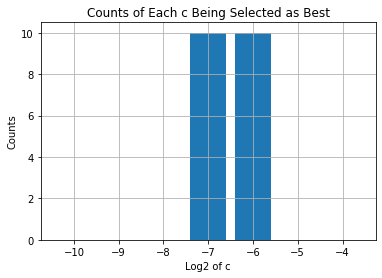

In [169]:
# Prints
best_cs = np.array(best_cs); best_cs_pow = np.log2(best_cs)

# Mean and std of the c
av_c = np.mean(best_cs); std_c = np.std(best_cs)

# Mean and std of the power
av_c_pow = np.mean(best_cs_pow); std_c_pow = np.std(best_cs_pow)

print(f"Average of the c is {av_c} with a standard deviation of {std_c}")
print(f"Average of the powers of c is {av_c_pow} with a standard deviation of {std_c_pow}")

# Mean and std of the errors
av_test = np.mean(c_errors); std_test = np.std(c_errors)
print(f"Average of the test errors is {av_test} with a standard deviation of {std_test}")

# Bar Chart
print("Best c's over cross validations (Log2)")
print(best_cs_pow)
c_pow_counts = np.zeros((len(c_pow_range)))
unique, counts = np.unique(best_cs_pow, return_counts = True)
for unique_pow_ind in range(len(unique)):
    unique_pow = unique[unique_pow_ind]
    loc = np.where(c_pow_range == unique_pow)[0]
    c_pow_counts[loc] = counts[unique_pow_ind]

plt.figure()
plt.title('Counts of Each c Being Selected as Best')
plt.bar(c_pow_range, c_pow_counts)
plt.xlabel('Log2 of c')
plt.ylabel('Counts')
plt.grid()

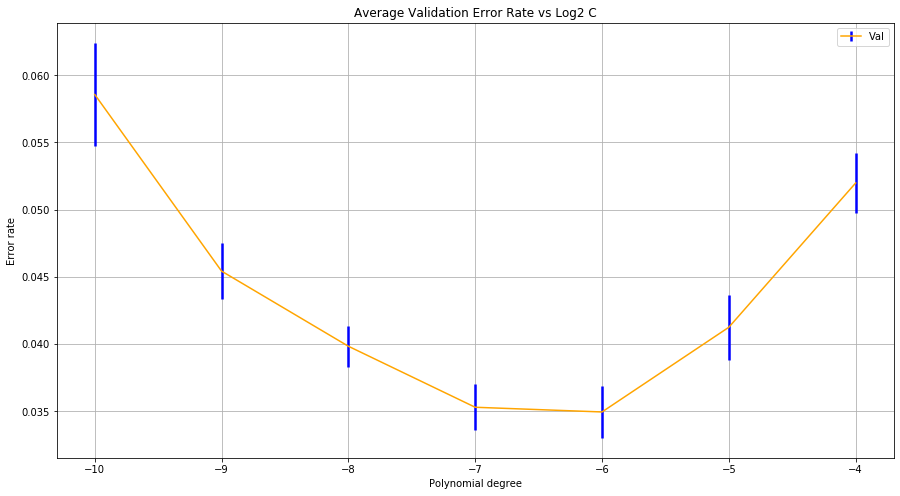

In [185]:
# Cross validation visualisation
av_val_error = np.mean(all_c_errors, axis = 1); std_val_error = np.std(all_c_errors, axis = 1)
plt.figure(figsize = (15,8))
plt.title('Average Validation Error Rate vs Log2 C')
plt.errorbar(c_pow_range, av_val_error, yerr = std_val_error, label = 'Val', elinewidth = 2.5, ecolor = 'b', color = 'orange')
plt.xlabel('Polynomial degree')
plt.ylabel('Error rate')
plt.legend()
plt.grid()